# New Framework

# XAI 

## 1: prototype case selection (5 mol)

In [ ]:
import json, math
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoConfig, AutoModel, AutoTokenizer

ROOT = Path("tox21_chemberta_v4")
DATA = ROOT / "data"
DESC = DATA / "descriptors"
MODEL = ROOT / "model"
PROT = ROOT / "prototype"
OUT_SEL = PROT / "selections"
OUT_SEL.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Load artifacts ----
CONFIG = json.loads((MODEL / "config.json").read_text())
label_names = (DATA / "label_names.txt").read_text(encoding="utf-8").splitlines()
L = len(label_names)
splits = json.loads((DATA / "splits" / "splits.json").read_text())
thresholds = json.loads((MODEL / "thresholds.json").read_text())

smiles = (DATA / "X_smiles.txt").read_text(encoding="utf-8").splitlines()
X_sel = np.load(DESC / "desc_selected.npy").astype(np.float32)     # (N, 256) standardized
y      = np.load(DATA / "y.npy").astype(np.float32)                # -1 for missing
y_mask = np.load(DATA / "y_mask.npy").astype(np.float32)

# optional fragment info (for nitro)
frag_mat = None
frag_names = None
try:
    frag_mat = np.load(DESC / "desc_frags.npy").astype(np.float32)     # (N, 28)
    frag_names = open(DESC / "frag_features.txt","r",encoding="utf-8").read().splitlines()
except Exception:
    pass

tokenizer = AutoTokenizer.from_pretrained(MODEL / "tokenizer")

# ---- Minimal inference model (same arch as train, loss not needed) ----
class MeanPooler(nn.Module):
    def forward(self, hidden_states: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        m = attention_mask.unsqueeze(-1).to(hidden_states.dtype)
        return (hidden_states * m).sum(1) / m.sum(1).clamp(min=1e-6)

class Tox21FusionModel(nn.Module):
    def __init__(self, cfg: dict, n_labels: int):
        super().__init__()
        base = cfg["base_model_name"]
        self.enc_cfg = AutoConfig.from_pretrained(base)
        self.encoder = AutoModel.from_pretrained(base, config=self.enc_cfg)
        if cfg.get("enable_grad_checkpointing", True):
            try: self.encoder.gradient_checkpointing_enable()
            except Exception: pass
        self.pooling = cfg.get("pooling", "mean")
        self.mean_pooler = MeanPooler()
        enc_dim = cfg.get("encoder_embed_dim", getattr(self.enc_cfg, "hidden_size", 768))
        self.desc_mlp = nn.Sequential(
            nn.Linear(cfg["desc_dim_in"], cfg["desc_mlp_hidden"]),
            nn.ReLU(inplace=True),
            nn.Dropout(cfg["dropout"]),
        )
        self.fusion = nn.Sequential(
            nn.Linear(enc_dim + cfg["desc_mlp_hidden"], cfg["fusion_hidden"]),
            nn.ReLU(inplace=True),
            nn.Dropout(cfg["dropout"]),
            nn.Linear(cfg["fusion_hidden"], n_labels),
        )
        self.register_buffer("pos_weight", torch.ones(n_labels))
    def forward(self, input_ids, attention_mask, desc):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=False)
        enc_vec = self.mean_pooler(out.last_hidden_state, attention_mask) if self.pooling=="mean" else out.last_hidden_state[:,0]
        desc_vec = self.desc_mlp(desc)
        return self.fusion(torch.cat([enc_vec, desc_vec], dim=-1))

# load weights
model = Tox21FusionModel(CONFIG, n_labels=L).to(device)
with torch.no_grad():
    pw = np.load(MODEL / "pos_weight.npy")
    model.pos_weight.copy_(torch.tensor(pw, dtype=torch.float32, device=device))
best = MODEL / ("best_model_tuned.pt" if (MODEL / "best_model_tuned.pt").exists() else "best_model.pt")
state = torch.load(best, map_location=device)["model_state"]
model.load_state_dict(state, strict=False)
model.eval()

# ---- Data plumbing (VAL+TEST only for selection) ----
val_idx  = np.array(sorted(splits["val"]), dtype=int)
test_idx = np.array(sorted(splits["test"]), dtype=int)
pool_idx = np.concatenate([val_idx, test_idx], axis=0)

class _IdxDS(Dataset):
    def __init__(self, idxs): self.idxs = np.array(idxs, dtype=int)
    def __len__(self): return len(self.idxs)
    def __getitem__(self, k):
        i = int(self.idxs[k])
        enc = tokenizer(smiles[i], max_length=CONFIG["max_length"], padding=False, truncation=True, add_special_tokens=True, return_tensors=None)
        return {
            "input_ids": torch.tensor(enc["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(enc["attention_mask"], dtype=torch.long),
            "desc": torch.tensor(X_sel[i], dtype=torch.float32),
            "row_id": i,
        }

def _collate(batch):
    pad_id = tokenizer.pad_token_id or 1
    ids_list  = [b["input_ids"] for b in batch]
    attn_list = [b["attention_mask"] for b in batch]
    max_len = max(t.size(0) for t in ids_list)
    B = len(batch)
    ids  = torch.full((B, max_len), pad_id, dtype=torch.long)
    attn = torch.zeros((B, max_len), dtype=torch.long)
    for i,(ii,aa) in enumerate(zip(ids_list, attn_list)):
        Ls = ii.size(0); ids[i,:Ls]=ii; attn[i,:Ls]=aa
    desc = torch.stack([b["desc"] for b in batch], 0)
    row_ids = [b["row_id"] for b in batch]
    return {"input_ids": ids, "attention_mask": attn, "desc": desc, "row_ids": row_ids}

def _infer(indices):
    ds = _IdxDS(indices)
    ld = DataLoader(ds, batch_size=64, shuffle=False, num_workers=0, collate_fn=_collate)
    sigm = lambda x: 1.0/(1.0+np.exp(-x))
    rows, probs = [], []
    with torch.no_grad():
        for b in ld:
            ids  = b["input_ids"].to(device)
            attn = b["attention_mask"].to(device)
            desc = b["desc"].to(device)
            logits = model(ids, attn, desc).cpu().numpy()
            p = sigm(logits)
            probs.append(p); rows += b["row_ids"]
    probs = np.concatenate(probs, 0)
    return np.array(rows, dtype=int), probs

row_ids, probs = _infer(pool_idx)
thr_vec = np.array([thresholds[lbl] for lbl in label_names], dtype=np.float32)
preds = (probs >= thr_vec[None, :]).astype(int)

# ---- Build a dataframe for mining cases ----
df = pd.DataFrame({
    "row_id": row_ids,
    "split": ["val" if i in set(val_idx) else "test" for i in row_ids],
    "smiles": [smiles[i] for i in row_ids],
})
# counts
df["known_labels"] = y_mask[row_ids].sum(axis=1).astype(int)
df["gt_pos"] = np.where(y_mask[row_ids]==1, y[row_ids], 0).sum(axis=1).astype(int)
df["pred_pos"] = preds.sum(axis=1).astype(int)
# closest-to-threshold distance across labels (min over |p - thr|)
df["min_margin"] = np.abs(probs - thr_vec[None,:]).min(axis=1)

# helper to fetch label-specific columns if needed later
def _get_series_for_label(j):
    return pd.Series({
        "AP_prob": probs[:, j].mean()
    })

# ---- Candidate rules ----
sel = []

# 1) Multi-positive (at least 3 predicted positives; prefer with >=6 known labels)
c1 = df[(df["pred_pos"]>=3)].copy()
c1["score"] = c1["pred_pos"] + 0.1*c1["known_labels"]
c1 = c1.sort_values(["score","known_labels"], ascending=[False, False])
if len(c1): sel.append(("multi_positive", int(c1.iloc[0]["row_id"]), "≥3 predicted positives"))

# 2) Borderline (closest margin)
c2 = df.sort_values("min_margin", ascending=True)
if len(c2): sel.append(("borderline", int(c2.iloc[0]["row_id"]), f"closest to a threshold (margin={c2.iloc[0]['min_margin']:.3f})"))

# 3) All-negative, fully known
known_all = (y_mask.sum(axis=1) == L)
zeros_all = (np.where(y_mask==1, y, 0).sum(axis=1) == 0)
cand_neg_full = np.intersect1d(pool_idx, np.where(known_all & zeros_all)[0])
if cand_neg_full.size:
    sel.append(("all_negative", int(cand_neg_full[0]), "all labels known=0"))
else:
    # fallback: pick low predicted positives & low probs
    c3 = df.sort_values(["pred_pos","min_margin"], ascending=[True, False])
    sel.append(("all_negative_fallback", int(c3.iloc[0]["row_id"]), "no fully-known all-zero; fallback to low-positives"))

# 4) Nitro-ARE (nitro aromatic present & SR-ARE high prob or pred=1)
if frag_mat is not None and frag_names is not None and "nitro_aromatic" in frag_names:
    j_nitro = frag_names.index("nitro_aromatic")
    j_are = label_names.index("SR-ARE")
    mask_pool = frag_mat[pool_idx, j_nitro] > 0.5
    cand_idx = pool_idx[mask_pool]
    if cand_idx.size:
        p_are = probs[np.isin(row_ids, cand_idx), j_are]
        # prefer predicted positive first
        preds_are = (p_are >= thresholds["SR-ARE"])
        if preds_are.any():
            pick = int(row_ids[np.where(np.isin(row_ids, cand_idx))[0][preds_are.argmax()]])
            sel.append(("nitro_are", pick, "nitro aromatic & SR-ARE high"))
        else:
            # fallback to highest ARE prob among nitro
            pick = int(row_ids[np.where(np.isin(row_ids, cand_idx))[0][p_are.argmax()]])
            sel.append(("nitro_are_weak", pick, "nitro aromatic & top SR-ARE prob"))
# If nitro data missing, fallback to highest ARE prob overall
if not any(tag.startswith("nitro_are") for tag,_,_ in sel):
    j_are = label_names.index("SR-ARE")
    hi = int(row_ids[np.argmax(probs[:, j_are])])
    sel.append(("top_are_prob", hi, "fallback: top SR-ARE prob"))

# 5) Likely ER false positive (high ER prob, label known=0 if available)
j_er = label_names.index("NR-ER")
known_er0 = (y_mask[:, j_er] == 1) & (y[:, j_er] == 0)
cand = np.intersect1d(pool_idx, np.where(known_er0)[0])
if cand.size:
    # pick with highest ER prob among those known negatives
    idx = int(row_ids[np.argmax(probs[np.isin(row_ids, cand), j_er])])
    sel.append(("er_fp_candidate", idx, "NR-ER prob high but GT=0"))
else:
    # fallback: just highest ER prob overall
    idx = int(row_ids[np.argmax(probs[:, j_er])])
    sel.append(("er_high_prob", idx, "fallback: top NR-ER prob"))

# Deduplicate while keeping first occurrences
picked = []
seen = set()
for tag, idx, reason in sel:
    if idx not in seen:
        picked.append((tag, idx, reason))
        seen.add(idx)
    if len(picked) == 5:
        break

# If <5 (edge case), top up with diverse high-confidence ones
if len(picked) < 5:
    # add most uncertain (small min_margin) not already selected
    remain = df[~df["row_id"].isin(list(seen))].sort_values("min_margin", ascending=True)
    for _, row in remain.iterrows():
        picked.append(("topup_uncertain", int(row["row_id"]), "small margin"))
        if len(picked) == 5:
            break

# Build final table
rows = []
for rank, (tag, idx, reason) in enumerate(picked, start=1):
    pr = probs[row_ids.tolist().index(idx)]
    yk = y_mask[idx]; yt = y[idx]
    known = int(yk.sum())
    gt_pos = int(np.where(yk==1, yt, 0).sum())
    # top-3 predicted labels
    top3 = np.argsort(-pr)[:3]
    rows.append({
        "rank": rank,
        "case_tag": tag,
        "row_id": idx,
        "split": "val" if idx in set(val_idx) else "test",
        "smiles": smiles[idx],
        "known_labels": known,
        "gt_pos": gt_pos,
        "pred_pos": int((pr >= thr_vec).sum()),
        "top1_label": label_names[top3[0]], "top1_prob": float(pr[top3[0]]),
        "top2_label": label_names[top3[1]], "top2_prob": float(pr[top3[1]]),
        "top3_label": label_names[top3[2]], "top3_prob": float(pr[top3[2]]),
        "reason": reason
    })

df_pick = pd.DataFrame(rows)

# Save CSV + JSON manifest
csv_path = OUT_SEL / "selected_cases.csv"
json_path = OUT_SEL / "selected_cases.json"
df_pick.to_csv(csv_path, index=False)
(Path(json_path)).write_text(json.dumps(df_pick.to_dict(orient="records"), indent=2), encoding="utf-8")

# Pretty print
print("[X1] Selected prototype cases (saved to selections/):")
print(df_pick[["rank","case_tag","row_id","split","known_labels","gt_pos","pred_pos","top1_label","top1_prob","reason"]].to_string(index=False))
print("\nFiles:")
print(" ", csv_path)
print(" ", json_path)


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[X1] Selected prototype cases (saved to selections/):
 rank        case_tag  row_id split  known_labels  gt_pos  pred_pos top1_label  top1_prob                                reason
    1  multi_positive    1578  test             8       7        11     SR-p53   0.993824                ≥3 predicted positives
    2      borderline    1843   val             1       0         0  NR-AR-LBD   0.563691 closest to a threshold (margin=0.000)
    3    all_negative      84   val            12       0         1      NR-ER   0.487385                    all labels known=0
    4    top_are_prob    5506   val             8       7         5     SR-ARE   0.972411             fallback: top SR-ARE prob
    5 er_fp_candidate    2177   val            12       0         1      NR-ER   0.545839              NR-ER prob high but GT=0

Files:
  tox21_chemberta_v4\prototype\selections\selected_cases.csv
  tox21_chemberta_v4\prototype\selections\selected_cases.json


## 2: Integrated Gradients (tokens)

loads the 5 cases from prototype/selections/selected_cases.csv

runs IG per label (12) on SMILES tokens

saves per-token attributions, tokens, offsets, and per-label plots under prototype/ig/<rowid>_<tag>/

also writes a small summary CSV per case

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[X2] Running IG for 5 cases...


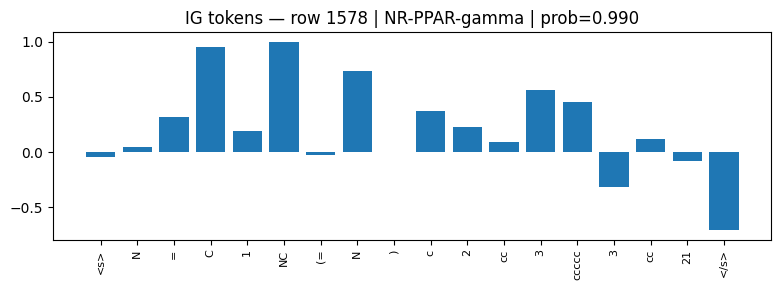

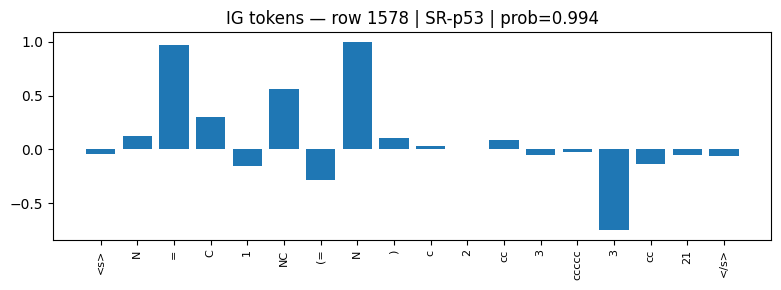

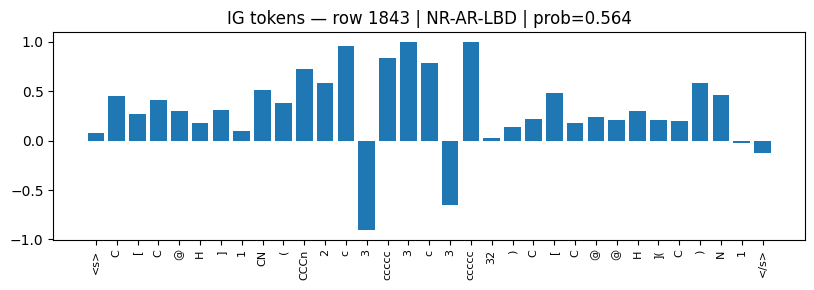

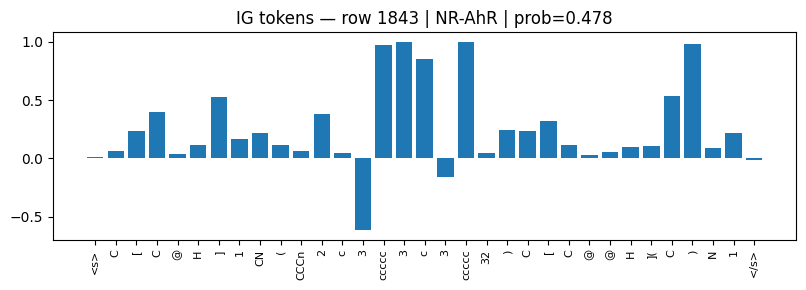

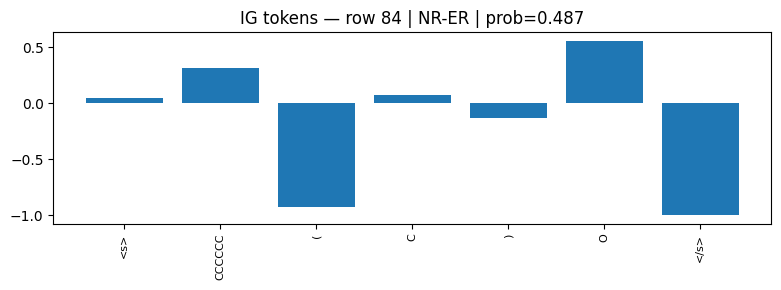

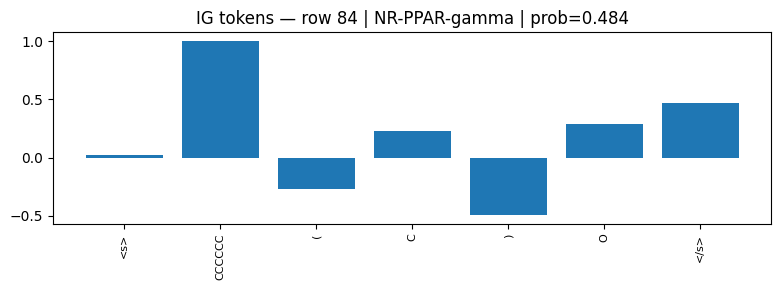

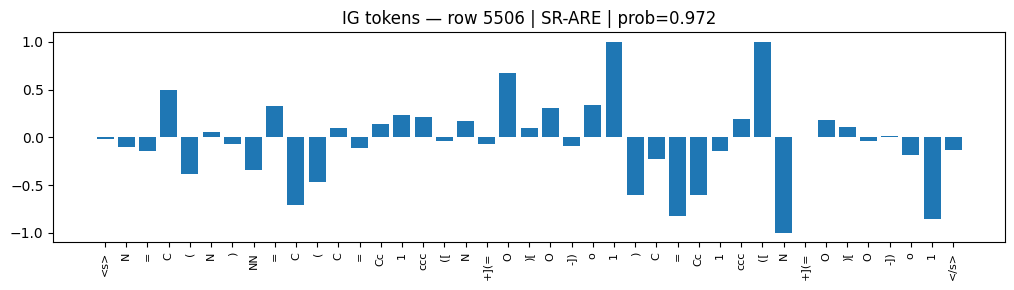

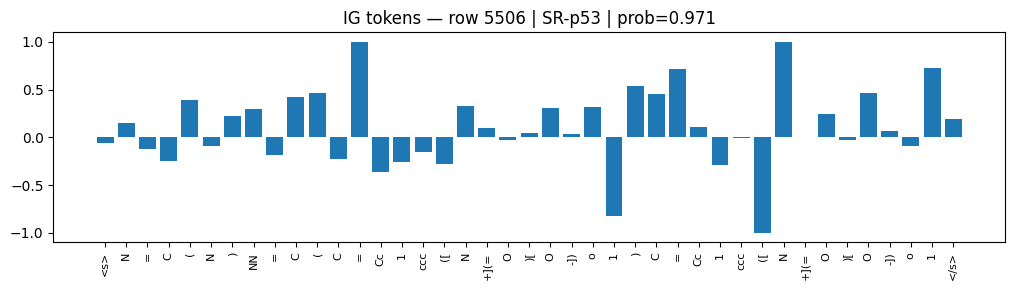

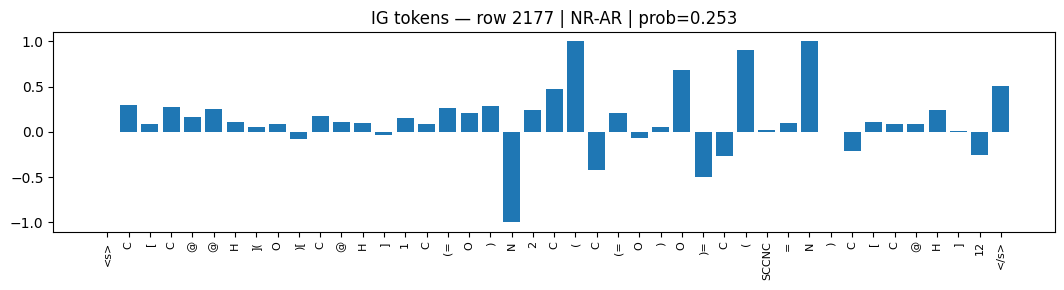

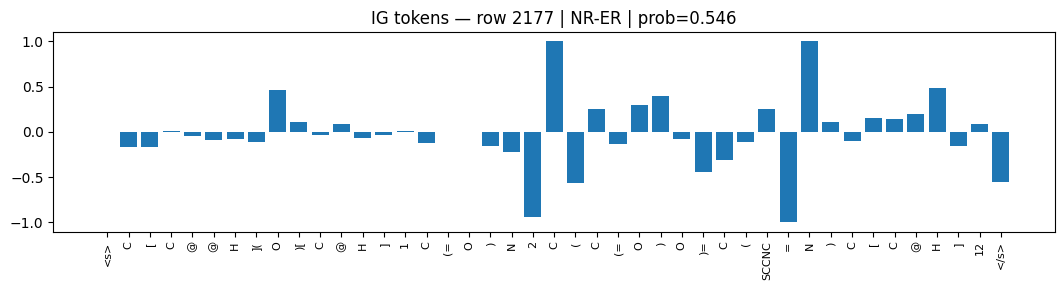

[X2] Done. Results under: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_chemberta_v4\prototype\ig


In [ ]:
import json, math, os, time
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import AutoConfig, AutoModel, AutoTokenizer

ROOT = Path("tox21_chemberta_v4")
DATA = ROOT / "data"
DESC = DATA / "descriptors"
MODEL = ROOT / "model"
PROT = ROOT / "prototype"
SEL_PATH = PROT / "selections" / "selected_cases.csv"
OUT_BASE = PROT / "ig"
OUT_BASE.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Load artifacts ----
CONFIG = json.loads((MODEL / "config.json").read_text())
label_names = (DATA / "label_names.txt").read_text(encoding="utf-8").splitlines()
L = len(label_names)
tokenizer = AutoTokenizer.from_pretrained(MODEL / "tokenizer")

smiles_list = (DATA / "X_smiles.txt").read_text(encoding="utf-8").splitlines()
X_sel = np.load(DESC / "desc_selected.npy").astype(np.float32)

# ---- Minimal inference fusion model (same arch as train) ----
class MeanPooler(nn.Module):
    def forward(self, hidden_states: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        m = attention_mask.unsqueeze(-1).to(hidden_states.dtype)
        return (hidden_states * m).sum(1) / m.sum(1).clamp(min=1e-6)

class Tox21FusionModel(nn.Module):
    def __init__(self, cfg: dict, n_labels: int):
        super().__init__()
        base = cfg["base_model_name"]
        self.enc_cfg = AutoConfig.from_pretrained(base)
        self.encoder = AutoModel.from_pretrained(base, config=self.enc_cfg)
        if cfg.get("enable_grad_checkpointing", True):
            try: self.encoder.gradient_checkpointing_enable()
            except Exception: pass
        self.pooling = cfg.get("pooling", "mean")
        self.mean_pooler = MeanPooler()
        enc_dim = cfg.get("encoder_embed_dim", getattr(self.enc_cfg, "hidden_size", 768))
        self.desc_mlp = nn.Sequential(
            nn.Linear(cfg["desc_dim_in"], cfg["desc_mlp_hidden"]),
            nn.ReLU(inplace=True),
            nn.Dropout(cfg["dropout"]),
        )
        self.fusion = nn.Sequential(
            nn.Linear(enc_dim + cfg["desc_mlp_hidden"], cfg["fusion_hidden"]),
            nn.ReLU(inplace=True),
            nn.Dropout(cfg["dropout"]),
            nn.Linear(cfg["fusion_hidden"], n_labels),
        )
        self.register_buffer("pos_weight", torch.ones(n_labels))

    def forward_ids(self, input_ids, attention_mask, desc):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=False)
        enc_vec = self.mean_pooler(out.last_hidden_state, attention_mask) if self.pooling=="mean" else out.last_hidden_state[:,0]
        desc_vec = self.desc_mlp(desc)
        return self.fusion(torch.cat([enc_vec, desc_vec], dim=-1))

    def forward_embeds(self, inputs_embeds, attention_mask, desc):
        out = self.encoder(inputs_embeds=inputs_embeds, attention_mask=attention_mask, output_hidden_states=False)
        enc_vec = self.mean_pooler(out.last_hidden_state, attention_mask) if self.pooling=="mean" else out.last_hidden_state[:,0]
        desc_vec = self.desc_mlp(desc)
        return self.fusion(torch.cat([enc_vec, desc_vec], dim=-1))

# load weights
model = Tox21FusionModel(CONFIG, n_labels=L).to(device)
best = MODEL / ("best_model_tuned.pt" if (MODEL / "best_model_tuned.pt").exists() else "best_model.pt")
state = torch.load(best, map_location=device)["model_state"]
model.load_state_dict(state, strict=False)
model.eval()

embed_layer = model.encoder.get_input_embeddings()  # (vocab_size, hidden_dim)
pad_id = tokenizer.pad_token_id or 1

def sigmoid_np(x): return 1.0/(1.0+np.exp(-x))

@torch.no_grad()
def predict_probs_for_row(i: int):
    enc = tokenizer(smiles_list[i], max_length=CONFIG["max_length"], padding=False, truncation=True, add_special_tokens=True, return_tensors="pt")
    ids = enc["input_ids"].to(device)
    att = enc["attention_mask"].to(device)
    desc = torch.tensor(X_sel[i][None, :], dtype=torch.float32, device=device)
    logits = model.forward_ids(ids, att, desc).cpu().numpy()
    return sigmoid_np(logits)[0], enc

def integrated_gradients_tokens(i: int, target_j: int, steps: int = 64, baseline: str = "zeros"):
    """
    Returns per-token IG attribution (length = sequence length).
    """
    enc = tokenizer(
        smiles_list[i],
        max_length=CONFIG["max_length"], padding=False, truncation=True, add_special_tokens=True,
        return_tensors="pt", return_offsets_mapping=True
    )
    ids = enc["input_ids"].to(device)          # (1, T)
    att = enc["attention_mask"].to(device)     # (1, T)
    offsets = enc["offset_mapping"][0].tolist()
    desc = torch.tensor(X_sel[i][None, :], dtype=torch.float32, device=device)

    # embeddings
    inp_emb = embed_layer(ids)                 # (1, T, D)
    if baseline == "pad":
        base_ids = torch.full_like(ids, pad_id)
        base_emb = embed_layer(base_ids)
    else:  # zeros in embedding space
        base_emb = torch.zeros_like(inp_emb)

    # path increments
    delta = inp_emb - base_emb
    total_grad = torch.zeros_like(inp_emb)

    # IG integral (Riemann sum)
    for s in range(1, steps+1):
        alpha = float(s) / steps
        emb_s = (base_emb + alpha * delta).detach().clone().requires_grad_(True)
        logits = model.forward_embeds(emb_s, att, desc)               # (1, L)
        logit_t = logits[0, target_j]
        # gradients wrt emb_s
        grads = torch.autograd.grad(logit_t, emb_s, retain_graph=False, create_graph=False)[0]  # (1,T,D)
        total_grad += grads

    avg_grad = total_grad / steps
    ig = (delta * avg_grad).sum(dim=-1).squeeze(0)   # (T,)
    ig = ig * att.squeeze(0)                         # zero-out pads
    ig_np = ig.detach().cpu().numpy()

    # normalize to signed values in [-1,1] per sequence (robust)
    if np.allclose(ig_np, 0):
        norm = ig_np
    else:
        q = np.quantile(np.abs(ig_np[att.squeeze(0).cpu().numpy()==1]), 0.95)
        q = max(q, 1e-6)
        norm = np.clip(ig_np / q, -1.0, 1.0)

    token_ids = ids.squeeze(0).cpu().tolist()
    tokens = tokenizer.convert_ids_to_tokens(token_ids)
    return {
        "tokens": tokens,
        "offsets": offsets,
        "attribution": norm.tolist(),   # signed importance per token
        "raw_attribution": ig_np.tolist()
    }

# ---- Run IG for selected cases ----
df_sel = pd.read_csv(SEL_PATH)
print(f"[X2] Running IG for {len(df_sel)} cases...")
all_manifest = []

for _, row in df_sel.iterrows():
    row_id = int(row["row_id"])
    tag = str(row["case_tag"])
    smi = smiles_list[row_id]
    case_dir = OUT_BASE / f"{row_id}_{tag}"
    case_dir.mkdir(parents=True, exist_ok=True)

    # probs for info + choose top-2 labels for plots
    probs, enc = predict_probs_for_row(row_id)
    top_idx = np.argsort(-probs)[:2]

    # Save tokens for reference
    token_ids = enc["input_ids"][0].tolist()
    tokens = tokenizer.convert_ids_to_tokens(token_ids)
    with open(case_dir / "tokens.txt", "w", encoding="utf-8") as f:
        f.write("\n".join(tokens))

    # IG per label
    attrib_mat = []
    for j in range(L):
        out = integrated_gradients_tokens(row_id, j, steps=64, baseline="zeros")
        attrib_mat.append(out["attribution"])
        if j in top_idx:
            # quick plot
            vals = np.array(out["attribution"], dtype=float)
            tok = out["tokens"]
            T = len(tok)
            plt.figure(figsize=(max(8, T*0.25), 3.0))
            plt.bar(range(T), vals)
            plt.xticks(range(T), tok, rotation=90, fontsize=8)
            plt.title(f"IG tokens — row {row_id} | {label_names[j]} | prob={probs[j]:.3f}")
            plt.tight_layout()
            plt.savefig(case_dir / f"ig_tokens_{label_names[j].replace('/','-')}.png", dpi=200)
            plt.show()

    attrib_mat = np.array(attrib_mat, dtype=np.float32)  # (L, T)
    np.save(case_dir / "ig_token_attributions.npy", attrib_mat)

    # Per-label summary (top tokens by |IG|)
    summaries = []
    for j in range(L):
        vals = attrib_mat[j]
        idxs = np.argsort(-np.abs(vals))[:8]
        top_tokens = [tokens[k] for k in idxs]
        top_scores = [float(vals[k]) for k in idxs]
        summaries.append({
            "label": label_names[j],
            "prob": float(probs[j]),
            "top_tokens": " ".join(top_tokens),
            "top_scores": ",".join(f"{s:.3f}" for s in top_scores)
        })
    pd.DataFrame(summaries).to_csv(case_dir / "ig_top_tokens.csv", index=False)

    # Manifest entry
    all_manifest.append({
        "row_id": row_id,
        "case_tag": tag,
        "smiles": smi,
        "dir": str(case_dir),
        "top1_label": label_names[top_idx[0]],
        "top1_prob": float(probs[top_idx[0]]),
        "top2_label": label_names[top_idx[1]],
        "top2_prob": float(probs[top_idx[1]]),
    })

# Save global manifest
pd.DataFrame(all_manifest).to_csv(OUT_BASE / "manifest.csv", index=False)
print(f"[X2] Done. Results under: {OUT_BASE.resolve()}")


## 3: Attention Rollout

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[X3] Running attention rollout for 5 cases...


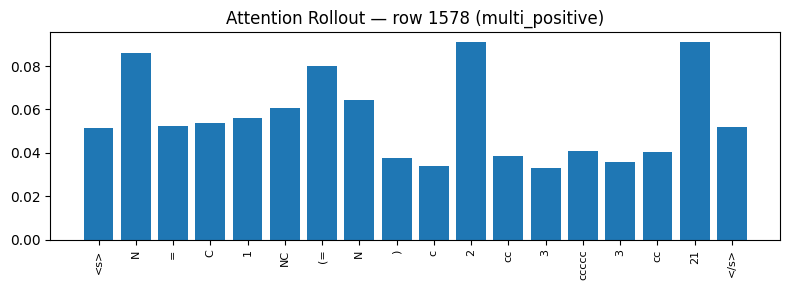

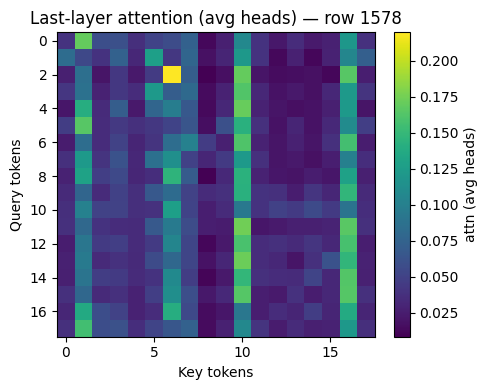

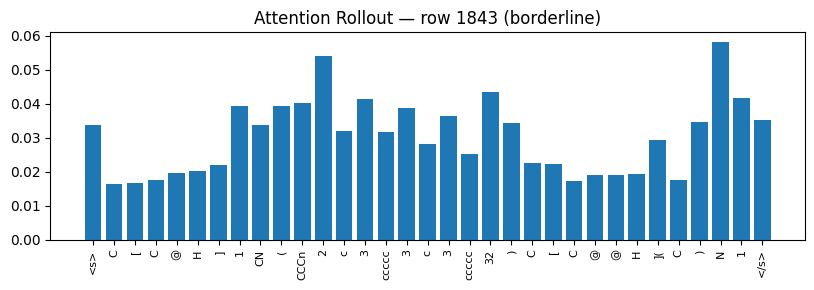

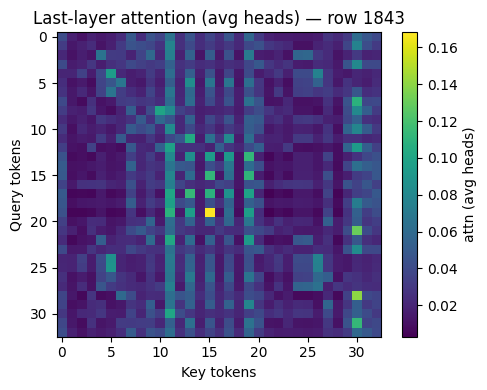

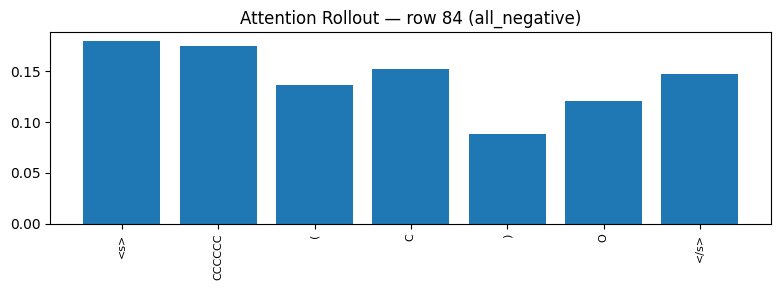

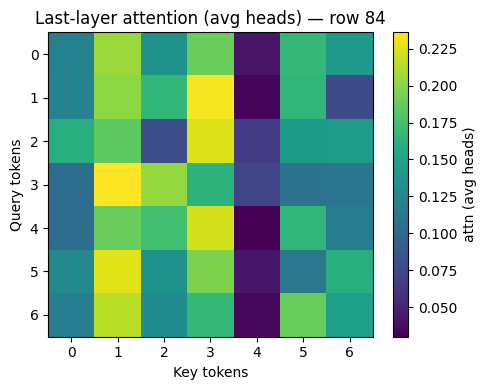

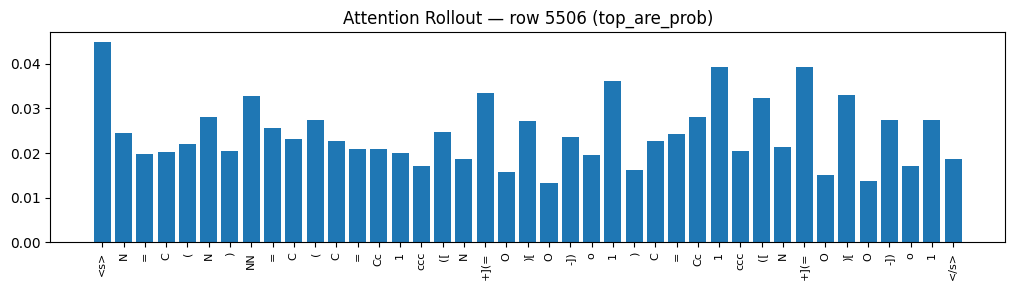

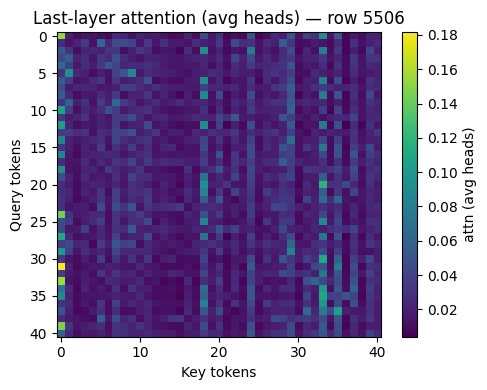

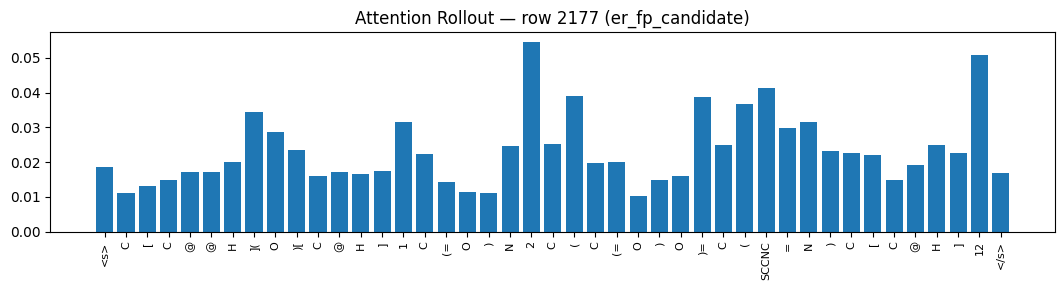

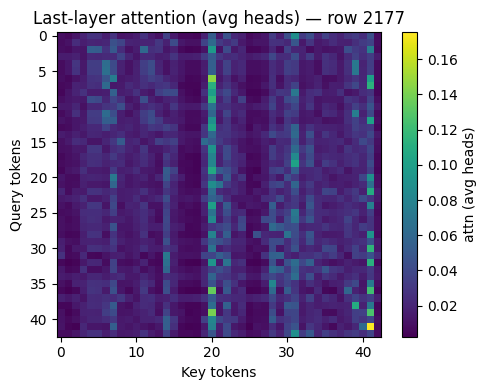

[X3] Done. Results under: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_chemberta_v4\prototype\attn


In [ ]:
import json, math
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import AutoConfig, AutoModel, AutoTokenizer

ROOT = Path("tox21_chemberta_v4")
DATA = ROOT / "data"
DESC = DATA / "descriptors"
MODEL = ROOT / "model"
PROT = ROOT / "prototype"
SEL_PATH = PROT / "selections" / "selected_cases.csv"
OUT_BASE = PROT / "attn"
OUT_BASE.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Load artifacts ----
CONFIG = json.loads((MODEL / "config.json").read_text())
label_names = (DATA / "label_names.txt").read_text(encoding="utf-8").splitlines()
tokenizer = AutoTokenizer.from_pretrained(MODEL / "tokenizer")

smiles_list = (DATA / "X_smiles.txt").read_text(encoding="utf-8").splitlines()

# ---- Minimal encoder-only wrapper (we only need attentions) ----
class TinyEncoder(nn.Module):
    def __init__(self, base_model_name: str):
        super().__init__()
        self.cfg = AutoConfig.from_pretrained(base_model_name)
        self.enc = AutoModel.from_pretrained(base_model_name, config=self.cfg)
        try: self.enc.gradient_checkpointing_enable()
        except Exception: pass
    def forward(self, **kwargs):
        return self.enc(**kwargs)

enc = TinyEncoder(CONFIG["base_model_name"]).to(device)
enc.eval()

pad_id = tokenizer.pad_token_id or 1
cls_id = tokenizer.cls_token_id if tokenizer.cls_token_id is not None else 0  # Roberta: <s> id = 0

def _encode_tokens(smi: str):
    enc_out = tokenizer(
        smi, max_length=CONFIG["max_length"], padding=False, truncation=True,
        add_special_tokens=True, return_tensors="pt"
    )
    ids = enc_out["input_ids"].to(device)           # (1, T)
    att = enc_out["attention_mask"].to(device)      # (1, T)
    tokens = tokenizer.convert_ids_to_tokens(ids[0].tolist())
    return ids, att, tokens

@torch.no_grad()
def attention_rollout(ids: torch.Tensor, att_mask: torch.Tensor, add_residual: bool=True, residual_factor: float=1.0):
    """
    Abnar & Zuidema (2020): rollout across layers. Returns per-token score from <s> to tokens.
    """
    # get attentions: list[L] of (B, H, T, T)
    out = enc(input_ids=ids, attention_mask=att_mask, output_attentions=True, output_hidden_states=False)
    attns = out.attentions
    # average over heads -> (L, T, T)
    A = [a.mean(dim=1)[0] for a in attns]  # each (T, T)
    T = A[0].shape[-1]

    # mask pads to avoid flow into padding tokens
    mask_vec = att_mask[0].to(A[0].dtype)  # (T,)
    mask_mat = torch.outer(mask_vec, mask_vec)  # (T, T)

    # normalize each row to sum 1 (after masking)
    A_norm = []
    for M in A:
        M = M * mask_mat  # zero rows/cols of pads
        # add small epsilon to avoid zero-row divide
        row_sums = M.sum(dim=-1, keepdim=True) + 1e-12
        M = M / row_sums
        if add_residual:
            I = torch.eye(T, device=M.device, dtype=M.dtype)
            M = residual_factor * M + (1.0 - residual_factor) * I  # simple residual mix
            # or common variant: (M + I)/2  -> set residual_factor=0.5 to emulate
        A_norm.append(M)

    # rollout: multiply across layers in order
    R = A_norm[0]
    for k in range(1, len(A_norm)):
        R = torch.matmul(R, A_norm[k])

    # score from CLS position (assume first token)
    cls_pos = 0
    scores = R[cls_pos] * mask_vec  # (T,)
    # normalize to sum 1 over non-pad tokens
    ssum = scores.sum().clamp(min=1e-12)
    scores = scores / ssum
    return scores.detach().cpu().numpy(), A[-1].detach().cpu().numpy()  # rollout vector, last-layer (T,T)

# ---- Run on selected cases ----
df_sel = pd.read_csv(SEL_PATH)
print(f"[X3] Running attention rollout for {len(df_sel)} cases...")
manifest = []

for _, row in df_sel.iterrows():
    row_id = int(row["row_id"]); tag = str(row["case_tag"])
    smi = smiles_list[row_id]
    case_dir = OUT_BASE / f"{row_id}_{tag}"
    case_dir.mkdir(parents=True, exist_ok=True)

    # tokens & attentions
    ids, attn, tokens = _encode_tokens(smi)
    rollout_vec, last_att = attention_rollout(ids, attn, add_residual=True, residual_factor=0.5)

    # save artifacts
    np.save(case_dir / "attn_rollout.npy", rollout_vec.astype(np.float32))
    np.save(case_dir / "last_layer_attn_avg.npy", last_att.astype(np.float32))
    (case_dir / "tokens.txt").write_text("\n".join(tokens), encoding="utf-8")

    # csv with token scores
    pd.DataFrame({"token": tokens, "rollout_score": rollout_vec}).to_csv(case_dir / "attn_rollout_tokens.csv", index=False)

    # bar plot of rollout
    T = len(tokens)
    plt.figure(figsize=(max(8, T*0.25), 3.0))
    plt.bar(range(T), rollout_vec)
    plt.xticks(range(T), tokens, rotation=90, fontsize=8)
    plt.title(f"Attention Rollout — row {row_id} ({tag})")
    plt.tight_layout()
    plt.savefig(case_dir / "attn_rollout.png", dpi=200)
    plt.show()

    # last-layer heatmap (avg heads)
    plt.figure(figsize=(5, 4))
    plt.imshow(last_att, aspect="auto", interpolation="nearest")
    plt.colorbar(label="attn (avg heads)")
    plt.title(f"Last-layer attention (avg heads) — row {row_id}")
    plt.xlabel("Key tokens"); plt.ylabel("Query tokens")
    plt.tight_layout()
    plt.savefig(case_dir / "last_layer_attn_heatmap.png", dpi=200)
    plt.show()

    manifest.append({
        "row_id": row_id,
        "case_tag": tag,
        "dir": str(case_dir),
        "n_tokens": T
    })

pd.DataFrame(manifest).to_csv(OUT_BASE / "manifest.csv", index=False)
print(f"[X3] Done. Results under: {OUT_BASE.resolve()}")


## 4: SAHP

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[X4] Kernel SHAP per-label for 5 cases (background=64, features=256, labels=12)


  0%|          | 0/1 [00:00<?, ?it/s]

[X4] SHAP shape sample — label NR-AR: raw=(1, 256), vec=(256,)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

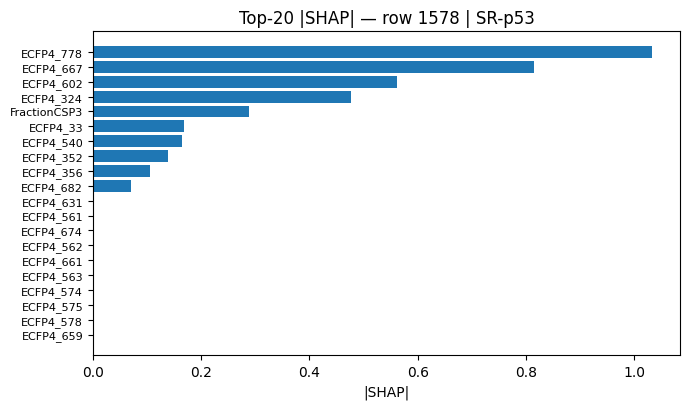

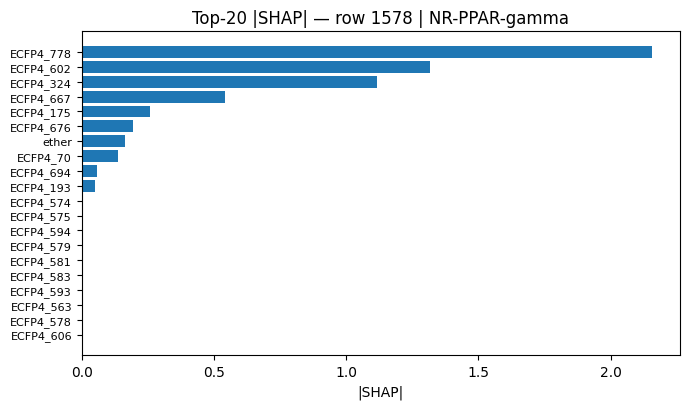

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

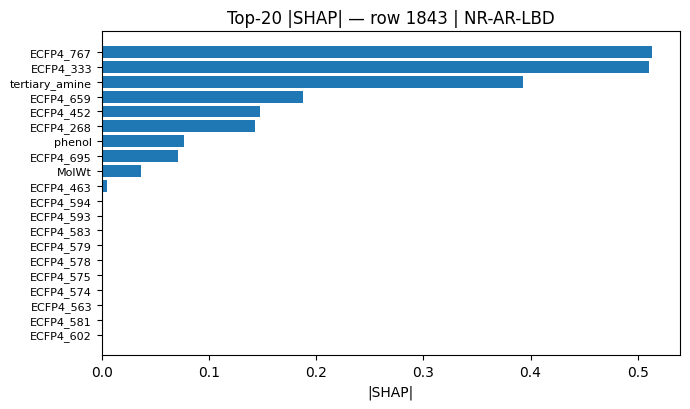

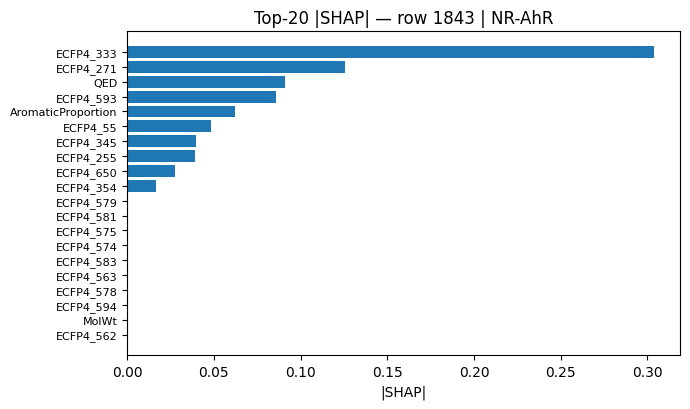

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

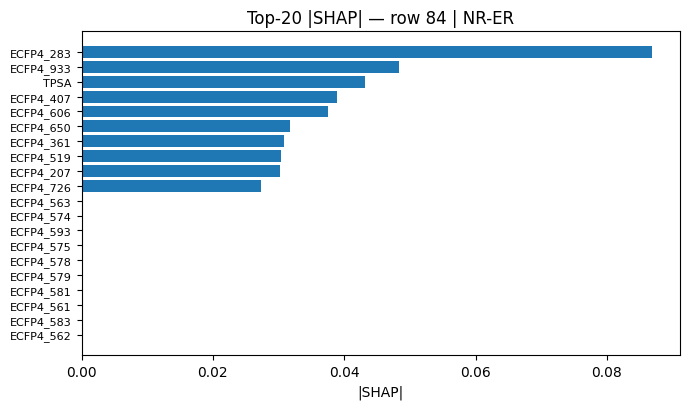

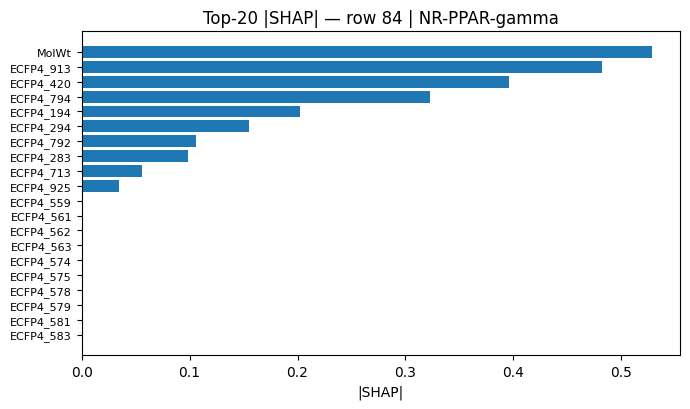

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

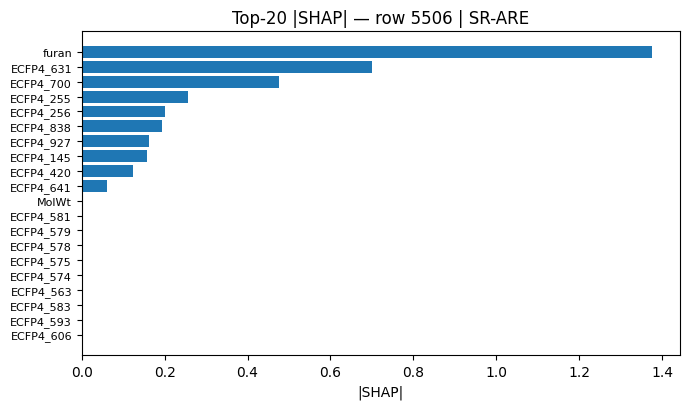

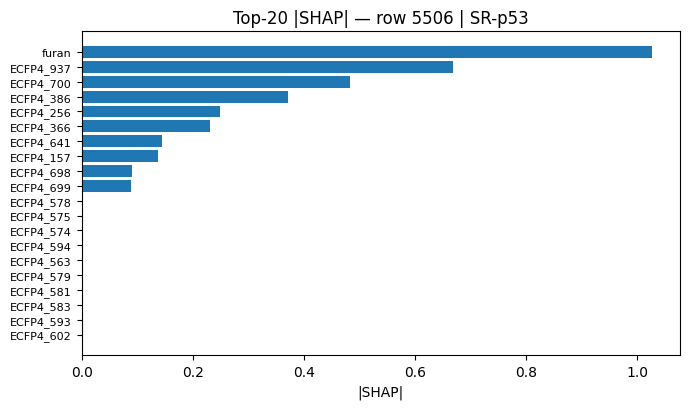

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

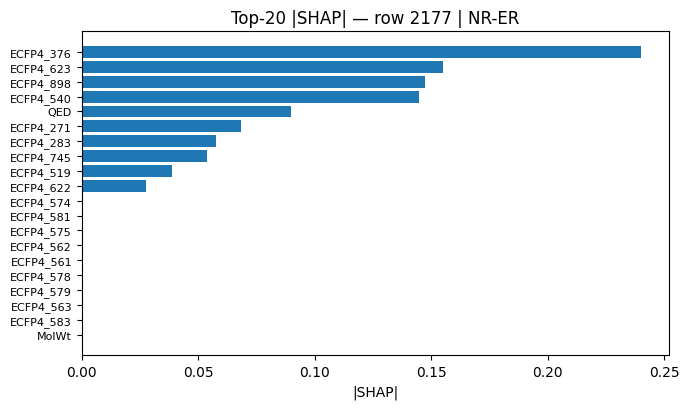

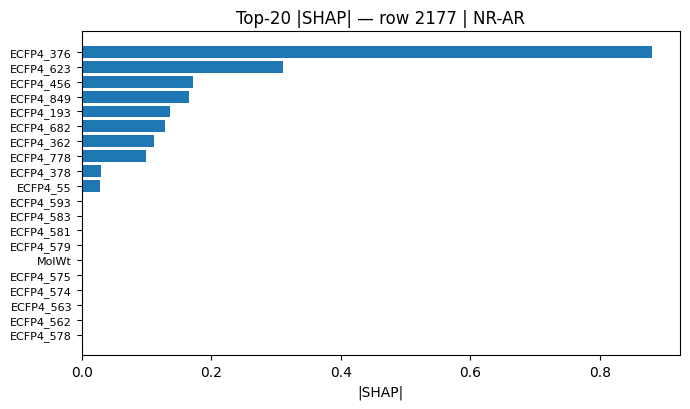

[X4] Done. Results under: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_chemberta_v4\prototype\shap


In [ ]:
# === CELL X4 (robust v2): SHAP on descriptors — per-label KernelExplainer, shape-safe ===
import os, json
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import AutoConfig, AutoModel, AutoTokenizer

try:
    import shap
    _HAS_SHAP = True
except Exception:
    _HAS_SHAP = False
    print("[X4][ERROR] shap is not installed. Please run: pip install shap==0.43.0")

ROOT = Path("tox21_chemberta_v4")
DATA = ROOT / "data"
DESC = DATA / "descriptors"
MODEL = ROOT / "model"
PROT = ROOT / "prototype"
SEL_PATH = PROT / "selections" / "selected_cases.csv"
OUT_BASE = PROT / "shap"
OUT_BASE.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Load artifacts ----
CONFIG = json.loads((MODEL / "config.json").read_text())
label_names = (DATA / "label_names.txt").read_text(encoding="utf-8").splitlines()
L = len(label_names)
feature_names = (DESC / "feature_names_selected.txt").read_text(encoding="utf-8").splitlines()
assert len(feature_names) == CONFIG["desc_dim_in"] == 256, f"Descriptor dim mismatch: got {len(feature_names)}"

smiles_list = (DATA / "X_smiles.txt").read_text(encoding="utf-8").splitlines()
X_sel = np.load(DESC / "desc_selected.npy").astype(np.float32)     # (N, 256)
splits = json.loads((DATA / "splits" / "splits.json").read_text())
train_idx = np.array(sorted(splits["train"]), dtype=int)

tokenizer = AutoTokenizer.from_pretrained(MODEL / "tokenizer")

# ---- Fusion model (inference parts) ----
class MeanPooler(nn.Module):
    def forward(self, hidden_states: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        m = attention_mask.unsqueeze(-1).to(hidden_states.dtype)
        return (hidden_states * m).sum(1) / m.sum(1).clamp(min=1e-6)

class Tox21FusionModel(nn.Module):
    def __init__(self, cfg: dict, n_labels: int):
        super().__init__()
        base = cfg["base_model_name"]
        self.enc_cfg = AutoConfig.from_pretrained(base)
        self.encoder = AutoModel.from_pretrained(base, config=self.enc_cfg)
        if cfg.get("enable_grad_checkpointing", True):
            try: self.encoder.gradient_checkpointing_enable()
            except Exception: pass
        self.pooling = cfg.get("pooling", "mean")
        self.mean_pooler = MeanPooler()
        enc_dim = cfg.get("encoder_embed_dim", getattr(self.enc_cfg, "hidden_size", 768))
        self.desc_mlp = nn.Sequential(
            nn.Linear(cfg["desc_dim_in"], cfg["desc_mlp_hidden"]),
            nn.ReLU(inplace=True),
            nn.Dropout(cfg["dropout"]),
        )
        self.fusion = nn.Sequential(
            nn.Linear(enc_dim + cfg["desc_mlp_hidden"], cfg["fusion_hidden"]),
            nn.ReLU(inplace=True),
            nn.Dropout(cfg["dropout"]),
            nn.Linear(cfg["fusion_hidden"], n_labels),
        )
        self.register_buffer("pos_weight", torch.ones(n_labels))

    def encode_tokens(self, input_ids, attention_mask):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=False)
        if self.pooling == "mean":
            return self.mean_pooler(out.last_hidden_state, attention_mask)   # (B, H)
        else:
            return out.last_hidden_state[:, 0]

    def desc_to_logits_with_encvec(self, desc, enc_vec):
        desc_vec = self.desc_mlp(desc)
        logits = self.fusion(torch.cat([enc_vec, desc_vec], dim=-1))
        return logits

# load weights (frozen)
model = Tox21FusionModel(CONFIG, n_labels=L).to(device).eval()
best = MODEL / ("best_model_tuned.pt" if (MODEL / "best_model_tuned.pt").exists() else "best_model.pt")
state = torch.load(best, map_location=device)["model_state"]
model.load_state_dict(state, strict=False)
for p in model.parameters(): p.requires_grad = False

@torch.no_grad()
def fixed_enc_vec_for_smiles(smi: str):
    enc = tokenizer(smi, max_length=CONFIG["max_length"], padding=False, truncation=True, add_special_tokens=True, return_tensors="pt")
    ids = enc["input_ids"].to(device)
    att = enc["attention_mask"].to(device)
    return model.encode_tokens(ids, att)  # (1, H)

class DescOnly(nn.Module):
    """Head that takes descriptors and uses a fixed token embedding (enc_vec)."""
    def __init__(self, big_model: Tox21FusionModel, enc_vec_fixed: torch.Tensor):
        super().__init__()
        self.desc_mlp = big_model.desc_mlp
        self.fusion   = big_model.fusion
        self.enc_vec  = enc_vec_fixed.detach()
    def forward(self, x: torch.Tensor):
        B = x.size(0)
        h = self.enc_vec.expand(B, -1)
        z = self.desc_mlp(x)
        return self.fusion(torch.cat([h, z], dim=-1))  # (B, L)

# ---- Background set for SHAP (kept small for speed) ----
rng = np.random.default_rng(42)
bg_n = min(64, len(train_idx))
bg_idx = rng.choice(train_idx, size=bg_n, replace=False)
X_bg = X_sel[bg_idx]  # (bg_n, 256)
np.save(OUT_BASE / "background_indices.npy", bg_idx)

def _sv_to_vec(sv, d):
    """Normalize SHAP output to a flat (d,) vector across SHAP versions."""
    arr = np.array(sv)
    if arr.ndim == 2 and arr.shape[0] == 1 and arr.shape[1] == d:
        return arr[0]
    if arr.ndim == 2 and arr.shape[1] == 1 and arr.shape[0] == d:
        return arr[:, 0]
    if arr.ndim == 1 and arr.shape[0] == d:
        return arr
    # fallback: ravel and check length
    vec = arr.ravel()
    if vec.size != d:
        raise ValueError(f"Unexpected SHAP shape {arr.shape}, expected (*,{d}) or ({d},*).")
    return vec

# ---- Run per selected case ----
df_sel = pd.read_csv(SEL_PATH)
print(f"[X4] Kernel SHAP per-label for {len(df_sel)} cases "
      f"(background={bg_n}, features={len(feature_names)}, labels={L})")

manifest = []
if not _HAS_SHAP:
    print("[X4][ABORT] shap missing; install shap and re-run.")
else:
    first_shape_printed = False
    for _, row in df_sel.iterrows():
        row_id = int(row["row_id"]); tag = str(row["case_tag"])
        smi = smiles_list[row_id]
        case_dir = OUT_BASE / f"{row_id}_{tag}"
        case_dir.mkdir(parents=True, exist_ok=True)

        enc_vec = fixed_enc_vec_for_smiles(smi)    # (1, H)
        head = DescOnly(model, enc_vec).to(device).eval()

        x0 = X_sel[row_id:row_id+1]                # (1, 256)
        S = np.zeros((L, X_sel.shape[1]), dtype=np.float32)  # (L, 256)

        bg_small = X_bg[:min(64, len(X_bg))]       # keep fast
        for j in range(L):
            # Return a 1-D vector (B,), not (B,1) — this prevents (256,1) SHAP shapes
            def f_j(x_np):
                x_t = torch.tensor(x_np, dtype=torch.float32, device=device)
                with torch.no_grad():
                    out = head(x_t)[:, j]    # (B,)
                return out.cpu().numpy()

            expl = shap.KernelExplainer(f_j, bg_small, link="identity")
            sv = expl.shap_values(x0, nsamples=256)   # array (1, 256) expected
            sv_vec = _sv_to_vec(sv, X_sel.shape[1])   # -> (256,)
            S[j] = sv_vec.astype(np.float32)

            if not first_shape_printed:
                print(f"[X4] SHAP shape sample — label {label_names[j]}: raw={np.array(sv).shape}, vec={sv_vec.shape}")
                first_shape_printed = True

        # save raw matrix
        np.save(case_dir / "shap_desc_values.npy", S)

        # compute probs from desc-only head (for picking top-2 plots)
        with torch.no_grad():
            logits = head(torch.tensor(x0, dtype=torch.float32, device=device)).cpu().numpy()[0]
            probs  = 1.0/(1.0+np.exp(-logits))
        top_idx = np.argsort(-probs)[:2]

        # top-20 plots per top label
        for j in top_idx:
            vals = S[j]
            order = np.argsort(-np.abs(vals))[:20]
            df_top = pd.DataFrame({
                "feature": [feature_names[k] for k in order],
                "shap_value": vals[order],
                "abs_shap": np.abs(vals[order])
            })
            df_top.to_csv(case_dir / f"shap_top20_{label_names[j].replace('/','-')}.csv", index=False)

            plt.figure(figsize=(7, 4.2))
            plt.barh(range(len(order)), df_top["abs_shap"][::-1])
            plt.yticks(range(len(order)), df_top["feature"][::-1], fontsize=8)
            plt.xlabel("|SHAP|")
            plt.title(f"Top-20 |SHAP| — row {row_id} | {label_names[j]}")
            plt.tight_layout()
            plt.savefig(case_dir / f"shap_top20_{label_names[j].replace('/','-')}.png", dpi=200)
            plt.show()

        manifest.append({
            "row_id": row_id,
            "case_tag": tag,
            "dir": str(case_dir),
            "bg_n": int(bg_n),
            "features": len(feature_names),
            "note": "KernelExplainer (per-label, scalar output, shape-safe)"
        })

    pd.DataFrame(manifest).to_csv(OUT_BASE / "manifest.csv", index=False)
    print(f"[X4] Done. Results under: {OUT_BASE.resolve()}")


## 5: Occlusion (descriptors + tokens), batched

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[X5] Running occlusion for 5 cases...


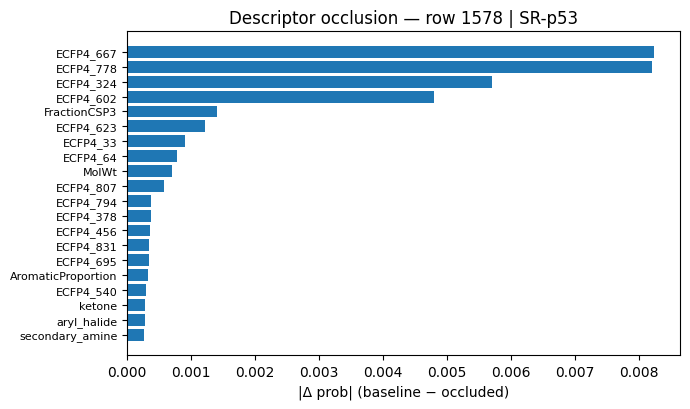

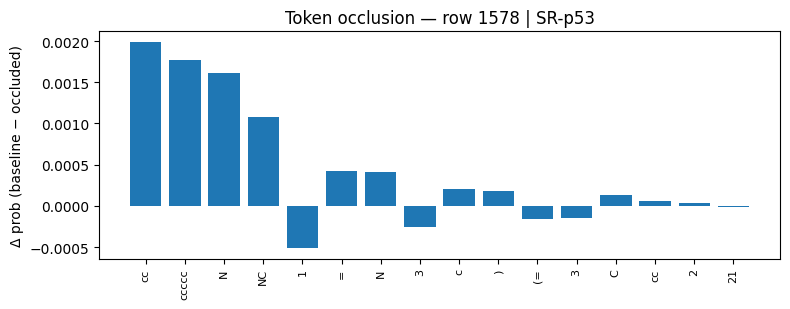

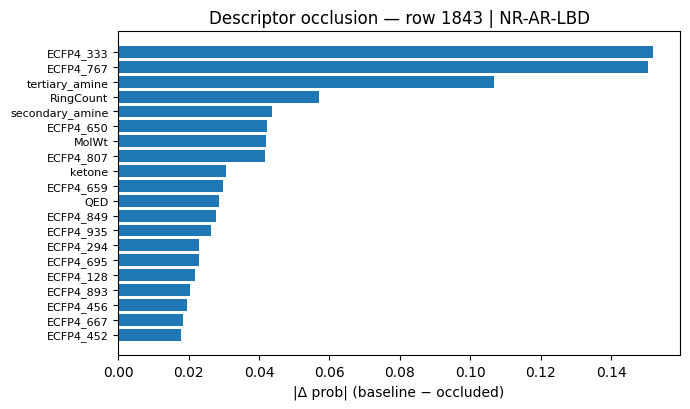

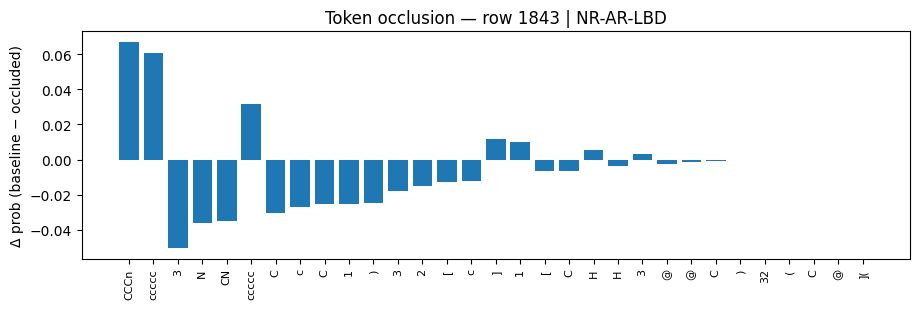

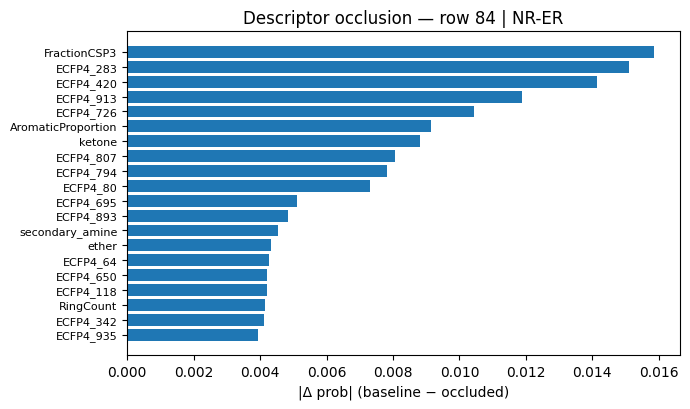

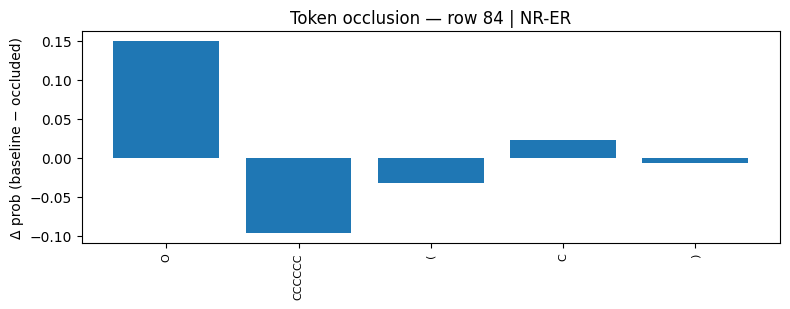

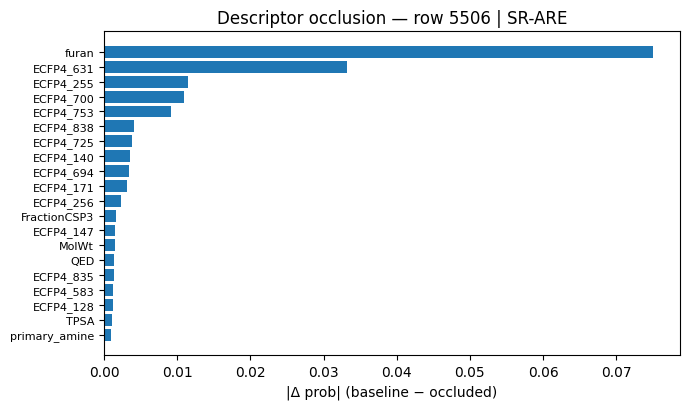

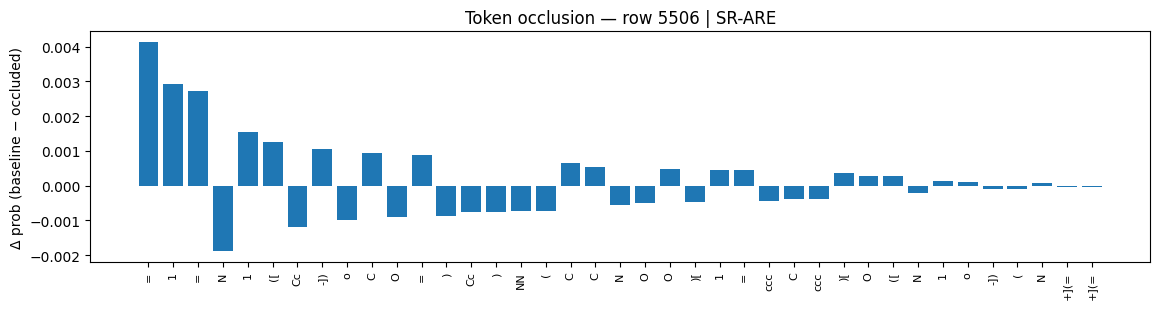

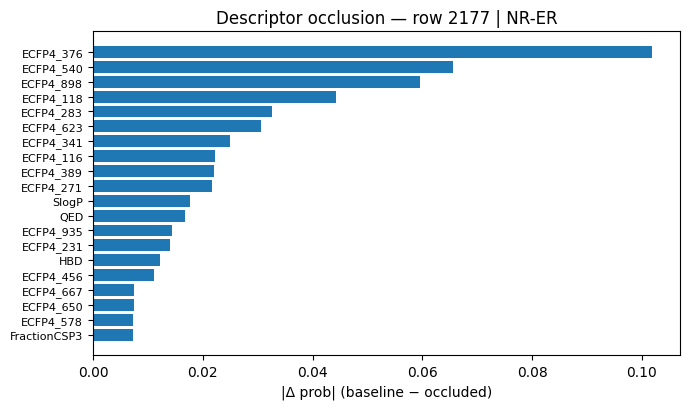

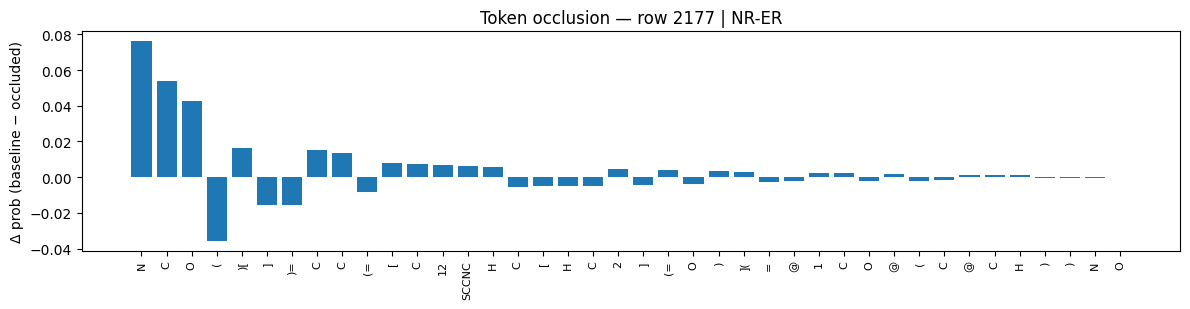

[X5] Done. Results under: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_chemberta_v4\prototype\occlusion
Saved per-case: desc_occlusion_delta.npy, token_occlusion_delta.npy, tokens.txt, baseline_probs.npy, summary CSV/PNGs.


In [ ]:
import json, math
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import AutoConfig, AutoModel, AutoTokenizer

ROOT = Path("tox21_chemberta_v4")
DATA = ROOT / "data"
DESC = DATA / "descriptors"
MODEL = ROOT / "model"
PROT = ROOT / "prototype"
SEL_PATH = PROT / "selections" / "selected_cases.csv"
OUT_BASE = PROT / "occlusion"
OUT_BASE.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Load artifacts ----
CONFIG = json.loads((MODEL / "config.json").read_text())
label_names = (DATA / "label_names.txt").read_text(encoding="utf-8").splitlines()
L = len(label_names)

smiles_list = (DATA / "X_smiles.txt").read_text(encoding="utf-8").splitlines()
X_sel = np.load(DESC / "desc_selected.npy").astype(np.float32)     # (N, 256) standardized
feature_names = (DESC / "feature_names_selected.txt").read_text(encoding="utf-8").splitlines()
assert X_sel.shape[1] == len(feature_names) == CONFIG["desc_dim_in"] == 256, "Descriptor dim mismatch."

tokenizer = AutoTokenizer.from_pretrained(MODEL / "tokenizer")
pad_id  = tokenizer.pad_token_id or 1
mask_id = tokenizer.mask_token_id if tokenizer.mask_token_id is not None else pad_id
cls_id  = tokenizer.cls_token_id  if tokenizer.cls_token_id  is not None else 0
sep_id  = tokenizer.sep_token_id  if tokenizer.sep_token_id  is not None else None  # Roberta uses </s>

# ---- Minimal fusion model (inference) ----
class MeanPooler(nn.Module):
    def forward(self, hidden_states: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        m = attention_mask.unsqueeze(-1).to(hidden_states.dtype)
        return (hidden_states * m).sum(1) / m.sum(1).clamp(min=1e-6)

class Tox21FusionModel(nn.Module):
    def __init__(self, cfg: dict, n_labels: int):
        super().__init__()
        base = cfg["base_model_name"]
        self.enc_cfg = AutoConfig.from_pretrained(base)
        self.encoder = AutoModel.from_pretrained(base, config=self.enc_cfg)
        if cfg.get("enable_grad_checkpointing", True):
            try: self.encoder.gradient_checkpointing_enable()
            except Exception: pass
        self.pooling = cfg.get("pooling", "mean")
        self.mean_pooler = MeanPooler()
        enc_dim = cfg.get("encoder_embed_dim", getattr(self.enc_cfg, "hidden_size", 768))
        self.desc_mlp = nn.Sequential(
            nn.Linear(cfg["desc_dim_in"], cfg["desc_mlp_hidden"]),
            nn.ReLU(inplace=True),
            nn.Dropout(cfg["dropout"]),
        )
        self.fusion = nn.Sequential(
            nn.Linear(enc_dim + cfg["desc_mlp_hidden"], cfg["fusion_hidden"]),
            nn.ReLU(inplace=True),
            nn.Dropout(cfg["dropout"]),
            nn.Linear(cfg["fusion_hidden"], n_labels),
        )
        self.register_buffer("pos_weight", torch.ones(n_labels))

    def forward(self, input_ids, attention_mask, desc):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=False)
        enc_vec = self.mean_pooler(out.last_hidden_state, attention_mask) if self.pooling=="mean" else out.last_hidden_state[:,0]
        desc_vec = self.desc_mlp(desc)
        logits = self.fusion(torch.cat([enc_vec, desc_vec], dim=-1))
        return logits

@torch.no_grad()
def _sigmoid(x): return 1.0/(1.0+np.exp(-x))

# Load weights
model = Tox21FusionModel(CONFIG, n_labels=L).to(device).eval()
best = MODEL / ("best_model_tuned.pt" if (MODEL / "best_model_tuned.pt").exists() else "best_model.pt")
state = torch.load(best, map_location=device)["model_state"]
model.load_state_dict(state, strict=False)

# ---- Helpers ----
def encode_smiles(smi: str):
    enc = tokenizer(
        smi, max_length=CONFIG["max_length"], padding=False, truncation=True,
        add_special_tokens=True, return_tensors="pt"
    )
    ids = enc["input_ids"]        # (1, T)
    att = enc["attention_mask"]   # (1, T)
    tokens = tokenizer.convert_ids_to_tokens(ids[0].tolist())
    return ids.to(device), att.to(device), tokens

def forward_probs(ids, att, desc):
    with torch.no_grad():
        logits = model(ids, att, desc).cpu().numpy()
        return _sigmoid(logits)  # (B, L)

def is_special(token_id: int, token_str: str):
    if token_id == pad_id or token_id == cls_id or (sep_id is not None and token_id == sep_id):
        return True
    # heuristic for Roberta special tokens
    return token_str in ["<s>", "</s>", "<pad>", "<mask>"]

def occlude_descriptors(desc_vec: np.ndarray, ids, att, batch_size: int = 128):
    """
    desc_vec: (1, D) standardized; zeroing one feature approximates 'remove' (mean imputed)
    Returns: delta_probs (L, D) where delta = baseline_prob - occluded_prob
    """
    D = desc_vec.shape[1]
    base_probs = forward_probs(ids, att, torch.tensor(desc_vec, dtype=torch.float32, device=device))[0]  # (L,)

    # Build a batch of D variants with one feature zeroed each
    X = np.repeat(desc_vec, D, axis=0)         # (D, D)
    for j in range(D): X[j, j] = 0.0           # zero feature j
    X_t = torch.tensor(X, dtype=torch.float32, device=device)

    # Repeat token ids/att for batching
    ids_rep = ids.expand(D, -1)                # (D, T)
    att_rep = att.expand(D, -1)

    # Batched forward
    probs_list = []
    for start in range(0, D, batch_size):
        end = min(D, start + batch_size)
        p = forward_probs(ids_rep[start:end], att_rep[start:end], X_t[start:end])  # (B, L)
        probs_list.append(p)
    occl_probs = np.vstack(probs_list)         # (D, L)

    # delta per feature -> transpose to (L, D)
    delta = (base_probs[None, :] - occl_probs).T
    return base_probs, delta  # (L,), (L, D)

def occlude_tokens(ids_base: torch.Tensor, att_base: torch.Tensor, desc_vec: np.ndarray, tokens: list, batch_size: int = 64):
    """
    Replace each non-special token with [MASK] (or PAD fallback), compute delta probs.
    Returns: delta_probs (L, T) aligned to tokens; special tokens get 0.
    """
    ids_base = ids_base.clone()
    att_base = att_base.clone()
    T = ids_base.size(1)
    base_probs = forward_probs(ids_base, att_base, torch.tensor(desc_vec, dtype=torch.float32, device=device))[0]  # (L,)

    # Build variants for non-special positions
    occl_ids = []
    idx_positions = []
    ids_np = ids_base[0].cpu().numpy().copy()
    for t in range(T):
        tok_id = int(ids_np[t])
        tok_str = tokens[t]
        if att_base[0, t].item() == 0 or is_special(tok_id, tok_str):
            continue
        v = ids_np.copy()
        v[t] = mask_id
        occl_ids.append(v)
        idx_positions.append(t)

    if len(occl_ids) == 0:
        return base_probs, np.zeros((L, T), dtype=np.float32)

    occl_ids = torch.tensor(np.stack(occl_ids, axis=0), dtype=torch.long, device=device)  # (V, T)
    occl_att = att_base.expand(occl_ids.size(0), -1)                                      # (V, T)
    desc_rep = torch.tensor(np.repeat(desc_vec, occl_ids.size(0), axis=0), dtype=torch.float32, device=device)

    # Batched forward
    probs_list = []
    for start in range(0, occl_ids.size(0), batch_size):
        end = min(occl_ids.size(0), start + batch_size)
        p = forward_probs(occl_ids[start:end], occl_att[start:end], desc_rep[start:end])  # (B, L)
        probs_list.append(p)
    occl_probs = np.vstack(probs_list)  # (V, L)

    # Fill into (L, T) vector with zeros for special/pad positions
    delta = np.zeros((L, T), dtype=np.float32)
    for k, t in enumerate(idx_positions):
        delta[:, t] = base_probs - occl_probs[k]
    return base_probs, delta

# ---- Run on selected cases ----
df_sel = pd.read_csv(SEL_PATH)
print(f"[X5] Running occlusion for {len(df_sel)} cases...")

manifest = []

for _, row in df_sel.iterrows():
    row_id = int(row["row_id"]); tag = str(row["case_tag"])
    smi = smiles_list[row_id]
    case_dir = OUT_BASE / f"{row_id}_{tag}"
    case_dir.mkdir(parents=True, exist_ok=True)

    # Encode tokens, get desc vector
    ids, att, tokens = encode_smiles(smi)
    desc_vec = X_sel[row_id:row_id+1]  # (1, D)

    # --- Descriptor occlusion
    base_probs_d, delta_desc = occlude_descriptors(desc_vec, ids, att, batch_size=128)  # (L,), (L, D)
    np.save(case_dir / "desc_occlusion_delta.npy", delta_desc.astype(np.float32))
    np.save(case_dir / "baseline_probs.npy", base_probs_d.astype(np.float32))

    # --- Token occlusion
    base_probs_t, delta_tok = occlude_tokens(ids, att, desc_vec, tokens, batch_size=64)  # (L,), (L, T)
    np.save(case_dir / "token_occlusion_delta.npy", delta_tok.astype(np.float32))
    (case_dir / "tokens.txt").write_text("\n".join(tokens), encoding="utf-8")

    # --- Quick summaries for the top label (by baseline prob)
    top_label = int(np.argmax(base_probs_d))
    # Descriptors: top-20 |delta|
    order_d = np.argsort(-np.abs(delta_desc[top_label]))[:20]
    df_top_d = pd.DataFrame({
        "feature": [feature_names[j] for j in order_d],
        "delta_prob": delta_desc[top_label, order_d],
        "abs_delta": np.abs(delta_desc[top_label, order_d])
    })
    df_top_d.to_csv(case_dir / f"desc_top20_{label_names[top_label].replace('/','-')}.csv", index=False)

    plt.figure(figsize=(7, 4.2))
    plt.barh(range(len(order_d)), df_top_d["abs_delta"][::-1])
    plt.yticks(range(len(order_d)), df_top_d["feature"][::-1], fontsize=8)
    plt.xlabel("|Δ prob| (baseline − occluded)")
    plt.title(f"Descriptor occlusion — row {row_id} | {label_names[top_label]}")
    plt.tight_layout()
    plt.savefig(case_dir / f"desc_top20_{label_names[top_label].replace('/','-')}.png", dpi=200)
    plt.show()

    # Tokens: bar over non-special tokens (top-40 by |delta|)
    tok_vals = delta_tok[top_label]
    idx_real = [t for t in range(len(tokens)) if not is_special(tokenizer.convert_tokens_to_ids(tokens[t]), tokens[t]) and att[0, t].item()==1]
    if len(idx_real) > 0:
        order_t = sorted(idx_real, key=lambda t: -abs(tok_vals[t]))[:min(40, len(idx_real))]
        plt.figure(figsize=(max(8, len(order_t)*0.3), 3.2))
        plt.bar(range(len(order_t)), [tok_vals[t] for t in order_t])
        plt.xticks(range(len(order_t)), [tokens[t] for t in order_t], rotation=90, fontsize=8)
        plt.ylabel("Δ prob (baseline − occluded)")
        plt.title(f"Token occlusion — row {row_id} | {label_names[top_label]}")
        plt.tight_layout()
        plt.savefig(case_dir / f"token_top_{label_names[top_label].replace('/','-')}.png", dpi=200)
        plt.show()

    manifest.append({
        "row_id": row_id,
        "case_tag": tag,
        "dir": str(case_dir),
        "n_tokens": len(tokens),
        "desc_dim": int(X_sel.shape[1]),
        "top_label": label_names[top_label],
        "baseline_prob_top": float(base_probs_d[top_label])
    })

pd.DataFrame(manifest).to_csv(OUT_BASE / "manifest.csv", index=False)
print(f"[X5] Done. Results under: {OUT_BASE.resolve()}")
print("Saved per-case: desc_occlusion_delta.npy, token_occlusion_delta.npy, tokens.txt, baseline_probs.npy, summary CSV/PNGs.")

## 6: Calibration via deletion curves

In [ ]:
import json, math, os
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from transformers import AutoConfig, AutoModel, AutoTokenizer

# -------- Paths --------
ROOT = Path("tox21_chemberta_v4")
DATA = ROOT / "data"
DESC = DATA / "descriptors"
MODEL = ROOT / "model"
PROT = ROOT / "prototype"

SEL_CSV   = PROT / "selections" / "selected_cases.csv"
IG_DIR    = PROT / "ig"
ATTN_DIR  = PROT / "attn"
SHAP_DIR  = PROT / "shap"
OCC_DIR   = PROT / "occlusion"

CALIB_DIR = PROT / "calibration"
CURVE_DIR = CALIB_DIR / "curves"
CALIB_DIR.mkdir(parents=True, exist_ok=True)
CURVE_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------- Config / data --------
CONFIG = json.loads((MODEL / "config.json").read_text())
label_names = (DATA / "label_names.txt").read_text(encoding="utf-8").splitlines()
L = len(label_names)
feature_names = (DESC / "feature_names_selected.txt").read_text(encoding="utf-8").splitlines()
assert len(feature_names) == CONFIG["desc_dim_in"] == 256, "Descriptor dim mismatch."

smiles_list = (DATA / "X_smiles.txt").read_text(encoding="utf-8").splitlines()
X_sel = np.load(DESC / "desc_selected.npy").astype(np.float32)  # (N, 256)

tokenizer = AutoTokenizer.from_pretrained(MODEL / "tokenizer")
pad_id  = tokenizer.pad_token_id or 1
mask_id = tokenizer.mask_token_id if tokenizer.mask_token_id is not None else pad_id
cls_id  = tokenizer.cls_token_id  if tokenizer.cls_token_id  is not None else 0
sep_id  = tokenizer.sep_token_id  if tokenizer.sep_token_id  is not None else None  # Roberta uses </s>

# -------- Inference model (fusion) --------
class MeanPooler(nn.Module):
    def forward(self, hidden_states: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        m = attention_mask.unsqueeze(-1).to(hidden_states.dtype)
        return (hidden_states * m).sum(1) / m.sum(1).clamp(min=1e-6)

class Tox21FusionModel(nn.Module):
    def __init__(self, cfg: dict, n_labels: int):
        super().__init__()
        base = cfg["base_model_name"]
        self.enc_cfg = AutoConfig.from_pretrained(base)
        self.encoder = AutoModel.from_pretrained(base, config=self.enc_cfg)
        try:
            if cfg.get("enable_grad_checkpointing", True):
                self.encoder.gradient_checkpointing_enable()
        except Exception:
            pass
        self.pooling = cfg.get("pooling", "mean")
        self.mean_pooler = MeanPooler()
        enc_dim = cfg.get("encoder_embed_dim", getattr(self.enc_cfg, "hidden_size", 768))
        self.desc_mlp = nn.Sequential(
            nn.Linear(cfg["desc_dim_in"], cfg["desc_mlp_hidden"]),
            nn.ReLU(inplace=True),
            nn.Dropout(cfg["dropout"]),
        )
        self.fusion = nn.Sequential(
            nn.Linear(enc_dim + cfg["desc_mlp_hidden"], cfg["fusion_hidden"]),
            nn.ReLU(inplace=True),
            nn.Dropout(cfg["dropout"]),
            nn.Linear(cfg["fusion_hidden"], n_labels),
        )
        self.register_buffer("pos_weight", torch.ones(n_labels))
    def forward(self, input_ids, attention_mask, desc):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=False)
        enc_vec = self.mean_pooler(out.last_hidden_state, attention_mask) if self.pooling=="mean" else out.last_hidden_state[:,0]
        z = self.desc_mlp(desc)
        return self.fusion(torch.cat([enc_vec, z], dim=-1))

model = Tox21FusionModel(CONFIG, n_labels=L).to(device).eval()
best = MODEL / ("best_model_tuned.pt" if (MODEL / "best_model_tuned.pt").exists() else "best_model.pt")
state = torch.load(best, map_location=device)["model_state"]
model.load_state_dict(state, strict=False)

def _sigmoid_np(x): return 1.0/(1.0+np.exp(-x))
@torch.no_grad()
def forward_probs(ids, att, desc):
    logits = model(ids, att, desc).cpu().numpy()
    return _sigmoid_np(logits)  # (B, L)

def _encode_ids(smi: str):
    enc = tokenizer(smi, max_length=CONFIG["max_length"], padding=False, truncation=True, add_special_tokens=True, return_tensors="pt")
    ids = enc["input_ids"].to(device)
    att = enc["attention_mask"].to(device)
    tokens = tokenizer.convert_ids_to_tokens(ids[0].tolist())
    return ids, att, tokens

def _is_special(tok_id: int, tok_str: str):
    if tok_id in (pad_id, cls_id) or (sep_id is not None and tok_id == sep_id):
        return True
    return tok_str in ["<s>", "</s>", "<pad>", "<mask>"]

# -------- Deletion curve builder --------
FRACTIONS = [0.05, 0.10, 0.20, 0.40, 0.60, 0.80, 1.00]
EPS = 1e-6

def deletion_curve_tokens(smi: str, desc_vec: np.ndarray, scores: np.ndarray, ignore_mask: np.ndarray):
    """
    smi: str, desc_vec: (1,D), scores: (T,) non-negative importance per token (specials masked to 0),
    ignore_mask: (T,) bool, True for tokens we must never mask (special/pad).
    Returns DataFrame with fraction, prob[j] for all labels, and drop wrt baseline.
    """
    ids, att, tokens = _encode_ids(smi)
    base_probs = forward_probs(ids, att, torch.tensor(desc_vec, dtype=torch.float32, device=device))[0]  # (L,)
    T = ids.size(1)
    ranks = np.argsort(-scores)  # high to low
    # ensure we never mask ignore positions
    ranks = [t for t in ranks if not ignore_mask[t] and att[0, t].item()==1]
    rows = []
    for frac in FRACTIONS:
        k = max(1, int(math.ceil(len(ranks) * frac)))
        mask_positions = set(ranks[:k])
        # build masked ids
        ids_mod = ids.clone()
        for t in mask_positions:
            ids_mod[0, t] = mask_id
        probs = forward_probs(ids_mod, att, torch.tensor(desc_vec, dtype=torch.float32, device=device))[0]
        rows.append({"fraction": frac, "base_prob_vec": base_probs, "prob_vec": probs})
    return base_probs, rows

def deletion_curve_desc(smi: str, desc_vec: np.ndarray, scores: np.ndarray):
    """
    desc_vec: (1,D), scores: (D,) non-negative importance per feature.
    zero top-k features cumulatively; keep tokens intact.
    """
    ids, att, tokens = _encode_ids(smi)
    base_probs = forward_probs(ids, att, torch.tensor(desc_vec, dtype=torch.float32, device=device))[0]
    D = desc_vec.shape[1]
    ranks = np.argsort(-scores)
    rows = []
    for frac in FRACTIONS:
        k = max(1, int(math.ceil(D * frac)))
        X = desc_vec.copy()
        X[0, ranks[:k]] = 0.0  # zero top-k features
        probs = forward_probs(ids, att, torch.tensor(X, dtype=torch.float32, device=device))[0]
        rows.append({"fraction": frac, "base_prob_vec": base_probs, "prob_vec": probs})
    return base_probs, rows

def area_under_deletion(rows, label_j):
    """
    rows: list of dicts from deletion_curve_*; use normalized drop wrt baseline prob:
    drop_norm = max(0, (base - prob) / max(base, EPS)); integrate over fractions (trapezoid).
    """
    fracs = np.array([r["fraction"] for r in rows], dtype=float)
    base = np.array([r["base_prob_vec"][label_j] for r in rows], dtype=float)
    probs = np.array([r["prob_vec"][label_j] for r in rows], dtype=float)
    b = base[0]
    drops = np.maximum(0.0, (b - probs) / max(b, EPS))
    # trapezoidal AUC on [0,1]
    auc = float(np.trapz(drops, fracs))
    return auc, drops, fracs, b, probs

# -------- Load selections --------
df_sel = pd.read_csv(SEL_CSV)
print(f"[X6] Calibrating on {len(df_sel)} prototype cases...")
methods = ["ig_tokens", "attn_tokens", "shap_desc", "occl_desc"]

per_case_auc_rows = []  # one row per (case,label,method)
# main loop over cases
for _, row in df_sel.iterrows():
    row_id = int(row["row_id"]); tag = str(row["case_tag"])
    smi = smiles_list[row_id]
    case_key = f"{row_id}_{tag}"

    # load IG tokens (L,T) + tokens for ignore mask
    ig_path = IG_DIR / case_key / "ig_token_attributions.npy"
    tokens_txt = (IG_DIR / case_key / "tokens.txt")
    if not ig_path.exists() or not tokens_txt.exists():
        raise FileNotFoundError(f"Missing IG outputs for case {case_key}")
    IG = np.load(ig_path)  # (L, T)
    tok_list = tokens_txt.read_text(encoding="utf-8").splitlines()

    # load Attention rollout (T,)
    attn_roll = np.load(ATTN_DIR / case_key / "attn_rollout.npy")  # (T,)

    # load SHAP descriptors (L, D)
    S = np.load(SHAP_DIR / case_key / "shap_desc_values.npy")  # (L, 256)

    # load Occlusion descriptors (L, D)
    OCC_D = np.load(OCC_DIR / case_key / "desc_occlusion_delta.npy")  # (L, 256)

    # descriptor vector
    desc_vec = X_sel[row_id:row_id+1]  # (1, 256)

    # token ignore mask
    ids0, att0, toks0 = _encode_ids(smi)
    T = ids0.size(1)
    ignore = np.zeros((T,), dtype=bool)
    for t in range(T):
        tok_id = int(ids0[0, t].item())
        tok_str = toks0[t]
        if _is_special(tok_id, tok_str) or att0[0, t].item() == 0:
            ignore[t] = True

    # normalize token scores to non-negative
    attn_scores = np.clip(attn_roll, 0, None)
    attn_scores[ignore] = 0.0

    # per-label processing
    for j, lbl in enumerate(label_names):
        # IG importance per token (abs, ignore specials)
        ig_scores = np.abs(IG[j])
        ig_scores[ignore] = 0.0

        # SHAP |values|
        shap_scores = np.abs(S[j])

        # Occl (desc) |delta|
        occl_desc_scores = np.abs(OCC_D[j])

        # --- deletion curves ---
        # tokens: IG
        _, rows_ig = deletion_curve_tokens(smi, desc_vec, ig_scores, ignore)
        auc_ig, drops_ig, fracs, base_j, probs_ig = area_under_deletion(rows_ig, j)

        # tokens: Attention
        _, rows_attn = deletion_curve_tokens(smi, desc_vec, attn_scores, ignore)
        auc_attn, drops_attn, _, _, _ = area_under_deletion(rows_attn, j)

        # desc: SHAP
        _, rows_shap = deletion_curve_desc(smi, desc_vec, shap_scores)
        auc_shap, drops_shap, _, _, _ = area_under_deletion(rows_shap, j)

        # desc: Occlusion (desc)
        _, rows_occ = deletion_curve_desc(smi, desc_vec, occl_desc_scores)
        auc_occ, drops_occ, _, _, _ = area_under_deletion(rows_occ, j)

        # save per-case curves to CSV (for traceability)
        case_curve_dir = CURVE_DIR / case_key
        case_curve_dir.mkdir(parents=True, exist_ok=True)

        def _save_curve(name, fracs, drops, base, probs):
            dfc = pd.DataFrame({
                "fraction": fracs,
                "drop_norm": drops,
                "prob": probs,
                "baseline_prob": [base]*len(fracs),
                "label": [lbl]*len(fracs),
                "method": [name]*len(fracs),
                "case": [case_key]*len(fracs)
            })
            dfc.to_csv(case_curve_dir / f"{name}_{lbl.replace('/','-')}.csv", index=False)

        _save_curve("ig_tokens",   fracs, drops_ig,   base_j, probs_ig)
        _save_curve("attn_tokens", fracs, drops_attn, base_j, probs_ig)  # probs from same shape ok
        _save_curve("shap_desc",   fracs, drops_shap, base_j, probs_ig)
        _save_curve("occl_desc",   fracs, drops_occ,  base_j, probs_ig)

        # record AUCs
        per_case_auc_rows += [
            {"case": case_key, "label": lbl, "method": "ig_tokens",   "auc": auc_ig},
            {"case": case_key, "label": lbl, "method": "attn_tokens", "auc": auc_attn},
            {"case": case_key, "label": lbl, "method": "shap_desc",   "auc": auc_shap},
            {"case": case_key, "label": lbl, "method": "occl_desc",   "auc": auc_occ},
        ]

# -------- Aggregate to per-label method scores --------
df_auc = pd.DataFrame(per_case_auc_rows)
df_auc.to_csv(CALIB_DIR / "aucs_per_case.csv", index=False)

# Average AUC across cases (per label, per method)
df_scores = df_auc.groupby(["label", "method"], as_index=False)["auc"].mean().rename(columns={"auc": "mean_auc"})
# Optional: rescale per label to [0,1] by min-max (makes softmax more stable if ranges vary)
def _minmax(x):
    if x.max() - x.min() < 1e-8:
        return np.ones_like(x) * 0.25  # equal weights if indistinguishable
    return (x - x.min()) / (x.max() - x.min())
df_scores["mm"] = df_scores.groupby("label")["mean_auc"].transform(_minmax)

# Softmax to weights per label across 4 methods
TEMP = 0.5  # temperature <1 sharpens differences
def _softmax_grp(vals):
    z = (vals / max(TEMP, 1e-6)).to_numpy()
    z = z - z.max()  # numerical stability
    e = np.exp(z)
    return e / e.sum()

df_scores["weight"] = df_scores.groupby("label")["mm"].transform(_softmax_grp)

# Save summary table
df_scores[["label","method","mean_auc","weight"]].to_csv(CALIB_DIR / "faithfulness_scores.csv", index=False)

# Save weights as JSON {label: {method: weight}}
weights = {}
for lbl in label_names:
    dd = df_scores[df_scores["label"] == lbl][["method","weight"]]
    weights[lbl] = {m: float(w) for m, w in zip(dd["method"], dd["weight"])}
(CALIB_DIR / "weights.json").write_text(json.dumps(weights, indent=2), encoding="utf-8")

print("[X6] Done.")
print("  • Per-case curves →", CURVE_DIR)
print("  • Per-case AUCs   →", CALIB_DIR / "aucs_per_case.csv")
print("  • Scores+weights  →", CALIB_DIR / "faithfulness_scores.csv")
print("  • Weights JSON    →", CALIB_DIR / "weights.json")

# Pretty print a compact weights table
pivot = df_scores.pivot(index="label", columns="method", values="weight").fillna(0.0)
print("\n[X6] Per-label method weights (softmax, sum=1):")
print(pivot.round(3).to_string())


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[X6] Calibrating on 5 prototype cases...
[X6] Done.
  • Per-case curves → tox21_chemberta_v4\prototype\calibration\curves
  • Per-case AUCs   → tox21_chemberta_v4\prototype\calibration\aucs_per_case.csv
  • Scores+weights  → tox21_chemberta_v4\prototype\calibration\faithfulness_scores.csv
  • Weights JSON    → tox21_chemberta_v4\prototype\calibration\weights.json

[X6] Per-label method weights (softmax, sum=1):
method         attn_tokens  ig_tokens  occl_desc  shap_desc
label                                                      
NR-AR                0.312      0.534      0.081      0.072
NR-AR-LBD            0.252      0.544      0.074      0.131
NR-AhR               0.332      0.520      0.070      0.077
NR-Aromatase         0.068      0.131      0.502      0.299
NR-ER                0.272      0.569      0.082      0.077
NR-ER-LBD            0.360      0.483      0.091      0.065
NR-PPAR-gamma        0.165      0.633      0.116      0.086
SR-ARE               0.065      0.080      0.

## 7: X-CAP fusion

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[X7] Fusing explanations for 5 cases...


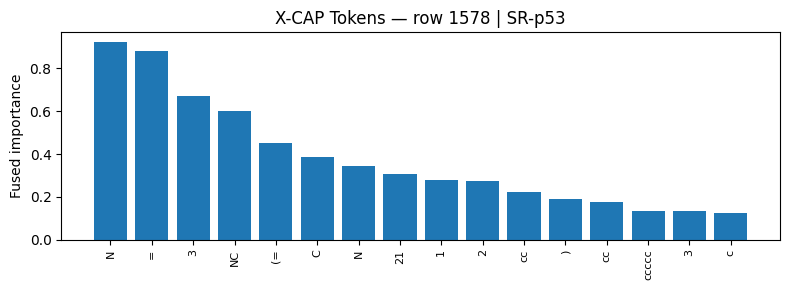

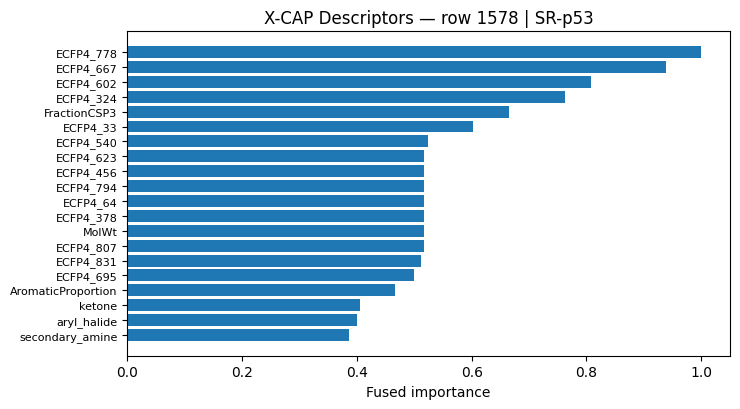

[X7] Case 1578_multi_positive — top label=SR-p53 | Δp(top-K tokens+descs)=0.278
      Saved → tox21_chemberta_v4\prototype\xcap\1578_multi_positive


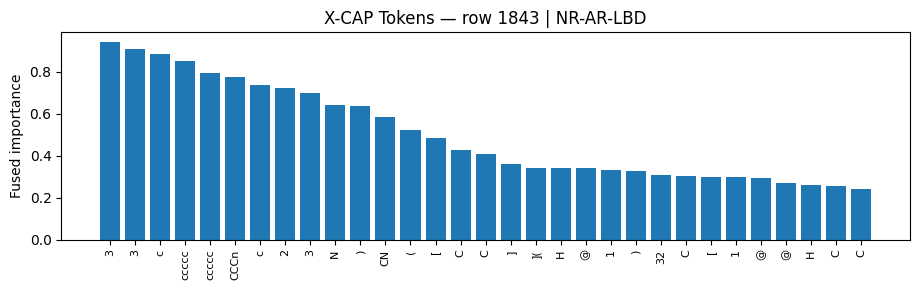

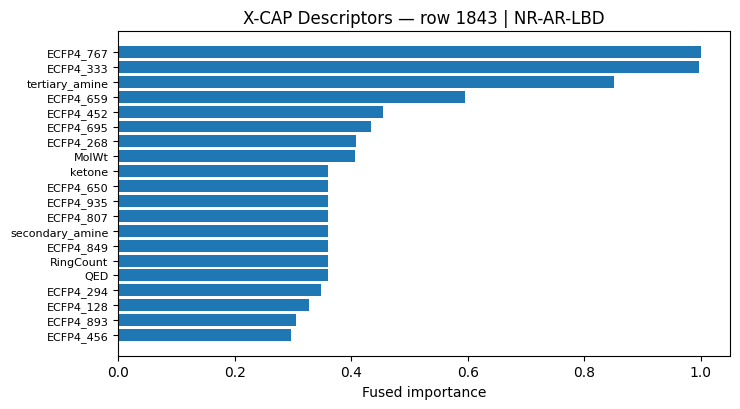

[X7] Case 1843_borderline — top label=NR-AR-LBD | Δp(top-K tokens+descs)=0.400
      Saved → tox21_chemberta_v4\prototype\xcap\1843_borderline


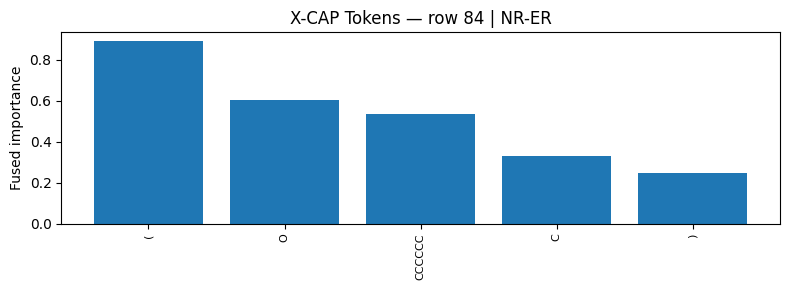

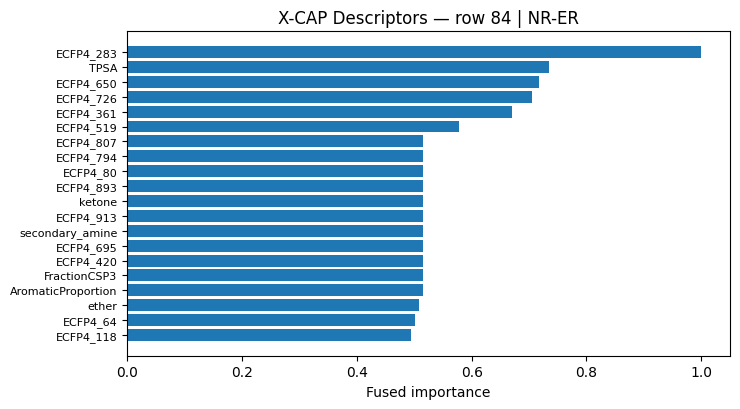

[X7] Case 84_all_negative — top label=NR-ER | Δp(top-K tokens+descs)=-0.042
      Saved → tox21_chemberta_v4\prototype\xcap\84_all_negative


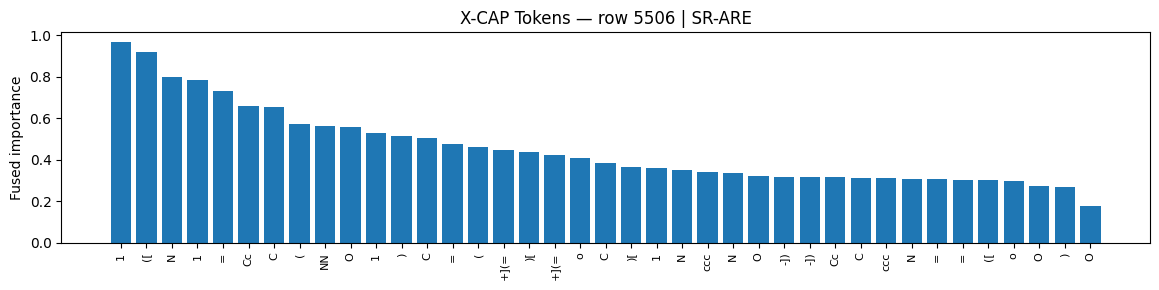

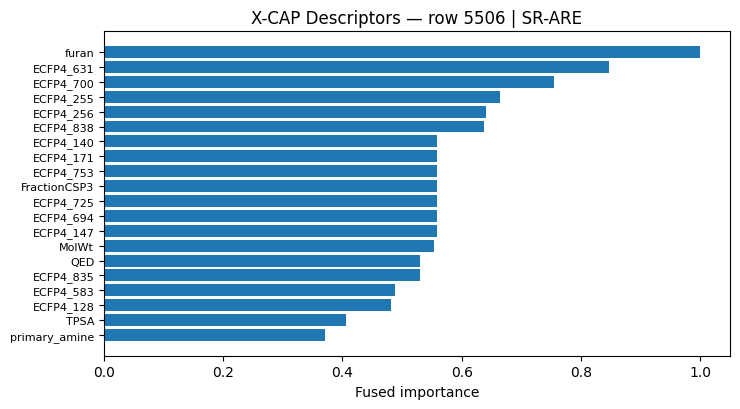

[X7] Case 5506_top_are_prob — top label=SR-ARE | Δp(top-K tokens+descs)=0.357
      Saved → tox21_chemberta_v4\prototype\xcap\5506_top_are_prob


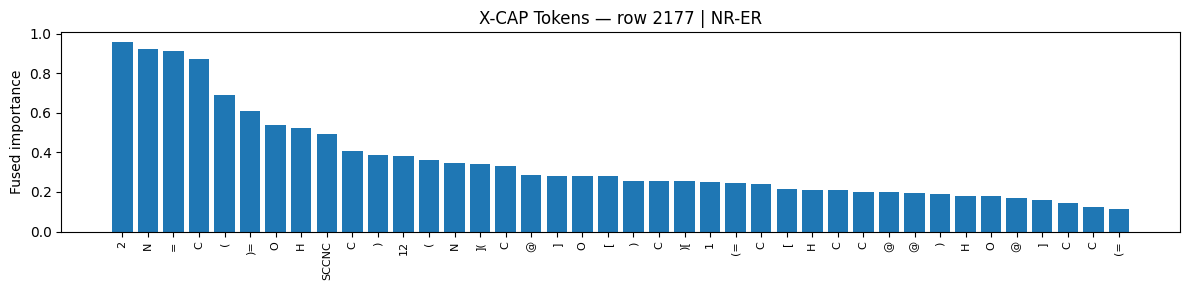

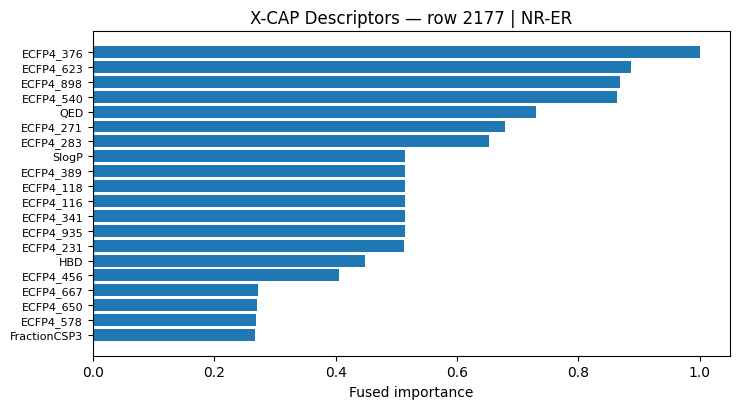

[X7] Case 2177_er_fp_candidate — top label=NR-ER | Δp(top-K tokens+descs)=0.004
      Saved → tox21_chemberta_v4\prototype\xcap\2177_er_fp_candidate

[X7] Done. Outputs per case in: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_chemberta_v4\prototype\xcap
  - token_fused.npy / token_uncertainty.npy
  - desc_fused.npy / desc_uncertainty.npy
  - xcap_* plots + top20 CSVs
  - counterfactual_delta.csv


In [ ]:
import json, math
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import AutoConfig, AutoModel, AutoTokenizer

# -------- Paths --------
ROOT = Path("tox21_chemberta_v4")
DATA = ROOT / "data"
DESC = DATA / "descriptors"
MODEL = ROOT / "model"
PROT = ROOT / "prototype"

SEL_CSV   = PROT / "selections" / "selected_cases.csv"
IG_DIR    = PROT / "ig"
ATTN_DIR  = PROT / "attn"
SHAP_DIR  = PROT / "shap"
OCC_DIR   = PROT / "occlusion"
CALIB_DIR = PROT / "calibration"
XCAP_DIR  = PROT / "xcap"
XCAP_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------- Load config/data --------
CONFIG = json.loads((MODEL / "config.json").read_text())
label_names = (DATA / "label_names.txt").read_text(encoding="utf-8").splitlines()
L = len(label_names)
feature_names = (DESC / "feature_names_selected.txt").read_text(encoding="utf-8").splitlines()
assert len(feature_names) == CONFIG["desc_dim_in"] == 256, "Descriptor dim mismatch."

smiles_list = (DATA / "X_smiles.txt").read_text(encoding="utf-8").splitlines()
X_sel = np.load(DESC / "desc_selected.npy").astype(np.float32)  # (N, 256)

# weights.json from X6
weights = json.loads((CALIB_DIR / "weights.json").read_text())

# -------- Inference model (for counterfactual check) --------
tokenizer = AutoTokenizer.from_pretrained(MODEL / "tokenizer")
pad_id  = tokenizer.pad_token_id or 1
mask_id = tokenizer.mask_token_id if tokenizer.mask_token_id is not None else pad_id
cls_id  = tokenizer.cls_token_id  if tokenizer.cls_token_id  is not None else 0
sep_id  = tokenizer.sep_token_id  if tokenizer.sep_token_id  is not None else None

class MeanPooler(nn.Module):
    def forward(self, hidden_states: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        m = attention_mask.unsqueeze(-1).to(hidden_states.dtype)
        return (hidden_states * m).sum(1) / m.sum(1).clamp(min=1e-6)

class Tox21FusionModel(nn.Module):
    def __init__(self, cfg: dict, n_labels: int):
        super().__init__()
        base = cfg["base_model_name"]
        self.enc_cfg = AutoConfig.from_pretrained(base)
        self.encoder = AutoModel.from_pretrained(base, config=self.enc_cfg)
        try:
            if cfg.get("enable_grad_checkpointing", True):
                self.encoder.gradient_checkpointing_enable()
        except Exception:
            pass
        self.pooling = cfg.get("pooling", "mean")
        self.mean_pooler = MeanPooler()
        enc_dim = cfg.get("encoder_embed_dim", getattr(self.enc_cfg, "hidden_size", 768))
        self.desc_mlp = nn.Sequential(
            nn.Linear(cfg["desc_dim_in"], cfg["desc_mlp_hidden"]),
            nn.ReLU(inplace=True),
            nn.Dropout(cfg["dropout"]),
        )
        self.fusion = nn.Sequential(
            nn.Linear(enc_dim + cfg["desc_mlp_hidden"], cfg["fusion_hidden"]),
            nn.ReLU(inplace=True),
            nn.Dropout(cfg["dropout"]),
            nn.Linear(cfg["fusion_hidden"], n_labels),
        )
    def forward(self, input_ids, attention_mask, desc):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=False)
        enc_vec = self.mean_pooler(out.last_hidden_state, attention_mask) if self.pooling=="mean" else out.last_hidden_state[:,0]
        z = self.desc_mlp(desc)
        return self.fusion(torch.cat([enc_vec, z], dim=-1))

@torch.no_grad()
def _sigmoid_np(x): return 1.0/(1.0+np.exp(-x))
@torch.no_grad()
def forward_probs(model, ids, att, desc):
    logits = model(ids, att, desc).cpu().numpy()
    return _sigmoid_np(logits)[0]  # (L,)

def _encode_ids(smi: str):
    enc = tokenizer(smi, max_length=CONFIG["max_length"], padding=False, truncation=True, add_special_tokens=True, return_tensors="pt")
    ids = enc["input_ids"].to(device)
    att = enc["attention_mask"].to(device)
    tokens = tokenizer.convert_ids_to_tokens(ids[0].tolist())
    return ids, att, tokens

def _is_special(tok_id: int, tok_str: str):
    if tok_id in (pad_id, cls_id) or (sep_id is not None and tok_id == sep_id):
        return True
    return tok_str in ["<s>", "</s>", "<pad>", "<mask>"]

# Load model weights
model = Tox21FusionModel(CONFIG, n_labels=L).to(device).eval()
best = MODEL / ("best_model_tuned.pt" if (MODEL / "best_model_tuned.pt").exists() else "best_model.pt")
state = torch.load(best, map_location=device)["model_state"]
model.load_state_dict(state, strict=False)

# -------- Normalization helpers --------
def _clip01(x, q=0.95):
    x = np.array(x, dtype=float)
    x = np.where(np.isfinite(x), x, 0.0)
    if x.ndim == 1:
        base = np.abs(x)
        if base.sum() == 0: return np.zeros_like(x)
        thresh = np.quantile(base[base>0], q) if (base>0).any() else 1.0
        thresh = max(thresh, 1e-6)
        return np.clip(base / thresh, 0.0, 1.0)
    else:
        # per-row
        out = np.zeros_like(x, dtype=float)
        for i in range(x.shape[0]):
            out[i] = _clip01(x[i], q=q)
        return out

def _renorm_weights(token_w, desc_w):
    # token: IG + ATTN; descriptor: SHAP + OCCL
    t_sum = token_w.get("ig_tokens", 0.0) + token_w.get("attn_tokens", 0.0)
    d_sum = desc_w.get("shap_desc", 0.0) + desc_w.get("occl_desc", 0.0)
    if t_sum < 1e-8: t_sum = 1.0
    if d_sum < 1e-8: d_sum = 1.0
    t = { "ig": token_w.get("ig_tokens", 0.0)/t_sum, "attn": token_w.get("attn_tokens", 0.0)/t_sum }
    d = { "shap": desc_w.get("shap_desc", 0.0)/d_sum, "occl": desc_w.get("occl_desc", 0.0)/d_sum }
    return t, d

# -------- Main fusion loop --------
df_sel = pd.read_csv(SEL_CSV)
print(f"[X7] Fusing explanations for {len(df_sel)} cases...")

for _, row in df_sel.iterrows():
    row_id = int(row["row_id"]); tag = str(row["case_tag"])
    smi = smiles_list[row_id]
    case_key = f"{row_id}_{tag}"
    case_dir = XCAP_DIR / case_key
    case_dir.mkdir(parents=True, exist_ok=True)

    # Load inputs
    IG = np.load( (IG_DIR / case_key / "ig_token_attributions.npy") )          # (L, T)
    tokens = (IG_DIR / case_key / "tokens.txt").read_text(encoding="utf-8").splitlines()
    ATT = np.load( (ATTN_DIR / case_key / "attn_rollout.npy") )                # (T,)
    SH = np.load( (SHAP_DIR / case_key / "shap_desc_values.npy") )             # (L, 256)
    OC = np.load( (OCC_DIR / case_key / "desc_occlusion_delta.npy") )          # (L, 256)

    # Tokens ignore mask
    ids0, att0, toks0 = _encode_ids(smi)
    T = len(tokens)
    ignore = np.zeros((T,), dtype=bool)
    for t_i in range(T):
        tok_id = int(ids0[0, t_i].item())
        tok_str = toks0[t_i]
        if _is_special(tok_id, tok_str) or att0[0, t_i].item() == 0:
            ignore[t_i] = True

    # Prepare arrays
    token_fused = np.zeros_like(IG, dtype=np.float32)       # (L, T)
    token_unc   = np.zeros_like(IG, dtype=np.float32)
    desc_fused  = np.zeros_like(SH, dtype=np.float32)       # (L, 256)
    desc_unc    = np.zeros_like(SH, dtype=np.float32)

    # Normalize attention once
    att_scores = _clip01(ATT)  # (T,)
    att_scores[ignore] = 0.0

    # Per label fusion
    for j, lbl in enumerate(label_names):
        w = weights[lbl]
        wt_tok, wt_desc = _renorm_weights(
            {"ig_tokens": w.get("ig_tokens", 0.0), "attn_tokens": w.get("attn_tokens", 0.0)},
            {"shap_desc": w.get("shap_desc", 0.0), "occl_desc": w.get("occl_desc", 0.0)}
        )

        # Token side: normalize IG per label, combine with ATT
        igj = np.array(IG[j], dtype=float)
        ig_norm = _clip01(igj)  # abs+percentile
        ig_norm[ignore] = 0.0

        stack_tok = np.stack([ig_norm, att_scores], axis=0)  # (2, T)
        # fused (weighted arithmetic mean within modality)
        token_fused[j] = (wt_tok["ig"] * ig_norm + wt_tok["attn"] * att_scores).astype(np.float32)
        # uncertainty = std across methods (after z-normalize across tokens)
        # z-score per method for comparability
        def _z(x): 
            m, s = x.mean(), x.std() if x.std() > 1e-8 else 1.0
            return (x - m) / s
        z_tok = np.stack([_z(ig_norm), _z(att_scores)], axis=0)
        token_unc[j] = z_tok.std(axis=0).astype(np.float32)

        # Descriptor side: normalize |SHAP| and |Occl|
        shj = np.abs(SH[j])
        ocj = np.abs(OC[j])
        sh_norm  = _clip01(shj)   # (256,)
        oc_norm  = _clip01(ocj)
        stack_desc = np.stack([sh_norm, oc_norm], axis=0)  # (2, 256)
        desc_fused[j] = (wt_desc["shap"] * sh_norm + wt_desc["occl"] * oc_norm).astype(np.float32)

        z_desc = np.stack([_z(sh_norm), _z(oc_norm)], axis=0)
        desc_unc[j] = z_desc.std(axis=0).astype(np.float32)

    # Save arrays
    np.save(case_dir / "token_fused.npy", token_fused)
    np.save(case_dir / "token_uncertainty.npy", token_unc)
    np.save(case_dir / "desc_fused.npy", desc_fused)
    np.save(case_dir / "desc_uncertainty.npy", desc_unc)
    (case_dir / "tokens.txt").write_text("\n".join(tokens), encoding="utf-8")

    # Quick visualization for the top label by baseline prob
    # (reuse baseline probs saved in occlusion step if available; otherwise recompute)
    base_probs_path = OCC_DIR / case_key / "baseline_probs.npy"
    if base_probs_path.exists():
        base_probs = np.load(base_probs_path)
    else:
        base_probs = forward_probs(model, ids0, att0, torch.tensor(X_sel[row_id:row_id+1], dtype=torch.float32, device=device))
    top_label = int(np.argmax(base_probs))
    lbl_name = label_names[top_label]

    # --- Plots: top tokens & descriptors by fused score ---
    # Tokens: take real (non-special) tokens only
    tok_vals = token_fused[top_label].copy()
    idx_real = [t for t in range(T) if not ignore[t]]
    order_tok = sorted(idx_real, key=lambda t: -tok_vals[t])[:min(40, len(idx_real))]

    plt.figure(figsize=(max(8, len(order_tok)*0.3), 3.0))
    plt.bar(range(len(order_tok)), [tok_vals[t] for t in order_tok])
    plt.xticks(range(len(order_tok)), [tokens[t] for t in order_tok], rotation=90, fontsize=8)
    plt.ylabel("Fused importance")
    plt.title(f"X-CAP Tokens — row {row_id} | {lbl_name}")
    plt.tight_layout()
    plt.savefig(case_dir / f"xcap_tokens_{lbl_name.replace('/','-')}.png", dpi=200)
    plt.show()

    # Descriptors: top 20
    desc_vals = desc_fused[top_label]
    order_desc = np.argsort(-desc_vals)[:20]
    df_top_desc = pd.DataFrame({
        "feature": [feature_names[k] for k in order_desc],
        "fused_importance": desc_vals[order_desc],
        "uncertainty": desc_unc[top_label, order_desc]
    })
    df_top_desc.to_csv(case_dir / f"xcap_desc_top20_{lbl_name.replace('/','-')}.csv", index=False)

    plt.figure(figsize=(7.5, 4.2))
    plt.barh(range(len(order_desc)), df_top_desc["fused_importance"][::-1])
    plt.yticks(range(len(order_desc)), df_top_desc["feature"][::-1], fontsize=8)
    plt.xlabel("Fused importance")
    plt.title(f"X-CAP Descriptors — row {row_id} | {lbl_name}")
    plt.tight_layout()
    plt.savefig(case_dir / f"xcap_desc_top20_{lbl_name.replace('/','-')}.png", dpi=200)
    plt.show()

    # --- Counterfactual check: remove top-K tokens + descriptors and measure Δprob per label ---
    K_tok = min(5, len(idx_real))
    K_desc = 5
    top_tok_idx = sorted(idx_real, key=lambda t: -token_fused[top_label, t])[:K_tok]
    top_desc_idx = np.argsort(-desc_fused[top_label])[:K_desc]

    # Build masked inputs
    ids_cf = ids0.clone()
    for t_i in top_tok_idx:
        ids_cf[0, t_i] = mask_id
    X_cf = X_sel[row_id:row_id+1].copy()
    X_cf[0, top_desc_idx] = 0.0

    base_probs_vec = base_probs
    cf_probs_vec = forward_probs(model, ids_cf, att0, torch.tensor(X_cf, dtype=torch.float32, device=device))
    delta = base_probs_vec - cf_probs_vec  # (L,)

    # Save counterfactual deltas
    df_delta = pd.DataFrame({
        "label": label_names,
        "delta_prob": delta
    }).sort_values("delta_prob", ascending=False)
    df_delta.to_csv(case_dir / "counterfactual_delta.csv", index=False)

    print(f"[X7] Case {case_key} — top label={lbl_name} | Δp(top-K tokens+descs)={delta[top_label]:.3f}")
    print(f"      Saved → {case_dir}")

print("\n[X7] Done. Outputs per case in:", XCAP_DIR.resolve())
print("  - token_fused.npy / token_uncertainty.npy")
print("  - desc_fused.npy / desc_uncertainty.npy")
print("  - xcap_* plots + top20 CSVs")
print("  - counterfactual_delta.csv")


## 8: Agreement metrics (methods ↔ fused), tokens & descriptors

In [ ]:
import json, math
from pathlib import Path
import numpy as np
import pandas as pd

ROOT = Path("tox21_chemberta_v4")
DATA = ROOT / "data"
DESC = DATA / "descriptors"
MODEL = ROOT / "model"
PROT = ROOT / "prototype"

SEL_CSV   = PROT / "selections" / "selected_cases.csv"
IG_DIR    = PROT / "ig"
ATTN_DIR  = PROT / "attn"
SHAP_DIR  = PROT / "shap"
OCC_DIR   = PROT / "occlusion"
XCAP_DIR  = PROT / "xcap"

METRICS_DIR = PROT / "metrics"
METRICS_DIR.mkdir(parents=True, exist_ok=True)

label_names = (DATA / "label_names.txt").read_text(encoding="utf-8").splitlines()
feature_names = (DESC / "feature_names_selected.txt").read_text(encoding="utf-8").splitlines()
L = len(label_names)
D = len(feature_names)

# ---------- helpers ----------
def _rank(arr):
    """Spearman-friendly ranks with average ties (numpy-only)."""
    arr = np.asarray(arr, dtype=float)
    # handle NaNs as very small values to avoid dropping indices
    arr = np.where(np.isfinite(arr), arr, -1e30)
    # ranks of values: tie-average
    sorter = np.argsort(arr, kind="mergesort")
    inv = np.empty_like(sorter)
    inv[sorter] = np.arange(arr.size)
    arr_sorted = arr[sorter]
    # find run starts/ends
    diffs = np.diff(arr_sorted)
    run_starts = np.r_[0, np.where(diffs != 0)[0] + 1]
    run_ends   = np.r_[np.where(diffs != 0)[0] + 1, arr.size]
    ranks = np.empty(arr.size, dtype=float)
    for s,e in zip(run_starts, run_ends):
        # average rank in the run
        avg = 0.5*(s + (e-1)) + 1.0  # 1-based ranks
        ranks[s:e] = avg
    return ranks[inv]

def spearman_rho(x, y):
    x = np.asarray(x); y = np.asarray(y)
    if x.size != y.size or x.size == 0:
        return np.nan
    rx, ry = _rank(x), _rank(y)
    # Pearson corr of ranks
    rx = rx - rx.mean(); ry = ry - ry.mean()
    sx = np.sqrt((rx*rx).sum()); sy = np.sqrt((ry*ry).sum())
    if sx < 1e-12 or sy < 1e-12:
        return np.nan
    return float((rx*ry).sum() / (sx*sy))

def topk_jaccard(a_vals, b_vals, k):
    """Jaccard of indices of top-k absolute values."""
    k = int(min(k, len(a_vals), len(b_vals)))
    if k <= 0: return np.nan
    ai = set(np.argsort(-np.abs(a_vals))[:k].tolist())
    bi = set(np.argsort(-np.abs(b_vals))[:k].tolist())
    inter = len(ai & bi); union = len(ai | bi)
    return float(inter/union) if union > 0 else np.nan

# ---------- main loop ----------
df_sel = pd.read_csv(SEL_CSV)
rows_tok = []
rows_desc = []

for _, row in df_sel.iterrows():
    row_id = int(row["row_id"]); tag = str(row["case_tag"])
    case_key = f"{row_id}_{tag}"

    # --- load per-case artifacts ---
    # tokens
    IG = np.load(IG_DIR / case_key / "ig_token_attributions.npy")      # (L, T)
    tokens = (IG_DIR / case_key / "tokens.txt").read_text(encoding="utf-8").splitlines()
    ATT = np.load(ATTN_DIR / case_key / "attn_rollout.npy")            # (T,)
    XCAP_tok = np.load(XCAP_DIR / case_key / "token_fused.npy")        # (L, T)

    # descriptors
    SHAP = np.load(SHAP_DIR / case_key / "shap_desc_values.npy")       # (L, D)
    OCC  = np.load(OCC_DIR / case_key / "desc_occlusion_delta.npy")    # (L, D)
    XCAP_desc = np.load(XCAP_DIR / case_key / "desc_fused.npy")        # (L, D)

    T = len(tokens)

    # --- compute metrics per label ---
    for j, lbl in enumerate(label_names):
        # TOKENS: compare abs(IG_j) vs ATT, and each vs XCAP fused token scores
        ig = np.abs(IG[j])
        att = np.maximum(ATT, 0.0)  # rollout is non-neg
        fused_t = XCAP_tok[j]

        # pad/truncate safety (shouldn't be needed, but robust)
        m = min(len(ig), len(att), len(fused_t))
        ig, att, fused_t = ig[:m], att[:m], fused_t[:m]

        # Spearman
        rho_ig_att   = spearman_rho(ig, att)
        rho_ig_fused = spearman_rho(ig, fused_t)
        rho_att_fused= spearman_rho(att, fused_t)

        # Jaccard @5 and @10
        jac5_ig_att    = topk_jaccard(ig, att, 5)
        jac10_ig_att   = topk_jaccard(ig, att, 10)
        jac5_ig_fused  = topk_jaccard(ig, fused_t, 5)
        jac10_ig_fused = topk_jaccard(ig, fused_t, 10)
        jac5_att_fused = topk_jaccard(att, fused_t, 5)
        jac10_att_fused= topk_jaccard(att, fused_t, 10)

        rows_tok.append({
            "case": case_key, "label": lbl, "T": m,
            "rho(IG,ATTN)": rho_ig_att,
            "rho(IG,FUSED)": rho_ig_fused,
            "rho(ATTN,FUSED)": rho_att_fused,
            "J@5(IG,ATTN)": jac5_ig_att,   "J@10(IG,ATTN)": jac10_ig_att,
            "J@5(IG,FUSED)": jac5_ig_fused,"J@10(IG,FUSED)": jac10_ig_fused,
            "J@5(ATTN,FUSED)": jac5_att_fused,"J@10(ATTN,FUSED)": jac10_att_fused,
        })

        # DESCRIPTORS: compare |SHAP_j| vs |OCC_j|, and each vs XCAP fused desc
        sh = np.abs(SHAP[j])
        oc = np.abs(OCC[j])
        fused_d = XCAP_desc[j]

        # Spearman
        rho_sh_oc   = spearman_rho(sh, oc)
        rho_sh_fus  = spearman_rho(sh, fused_d)
        rho_oc_fus  = spearman_rho(oc, fused_d)

        # Jaccard @10 and @20
        jac10_sh_oc  = topk_jaccard(sh, oc, 10)
        jac20_sh_oc  = topk_jaccard(sh, oc, 20)
        jac10_sh_fus = topk_jaccard(sh, fused_d, 10)
        jac20_sh_fus = topk_jaccard(sh, fused_d, 20)
        jac10_oc_fus = topk_jaccard(oc, fused_d, 10)
        jac20_oc_fus = topk_jaccard(oc, fused_d, 20)

        rows_desc.append({
            "case": case_key, "label": lbl, "D": len(fused_d),
            "rho(SHAP,OCCL)": rho_sh_oc,
            "rho(SHAP,FUSED)": rho_sh_fus,
            "rho(OCCL,FUSED)": rho_oc_fus,
            "J@10(SHAP,OCCL)": jac10_sh_oc, "J@20(SHAP,OCCL)": jac20_sh_oc,
            "J@10(SHAP,FUSED)": jac10_sh_fus, "J@20(SHAP,FUSED)": jac20_sh_fus,
            "J@10(OCCL,FUSED)": jac10_oc_fus, "J@20(OCCL,FUSED)": jac20_oc_fus,
        })

# ---------- save per-case metrics ----------
df_tok = pd.DataFrame(rows_tok)
df_desc = pd.DataFrame(rows_desc)
df_tok.to_csv(METRICS_DIR / "tokens_agreement_per_case.csv", index=False)
df_desc.to_csv(METRICS_DIR / "descriptors_agreement_per_case.csv", index=False)

# ---------- aggregate summaries ----------
def agg(df, cols_keep, cols_metric):
    g = df.groupby(cols_keep, as_index=False)[cols_metric].mean()
    g_std = df.groupby(cols_keep, as_index=False)[cols_metric].std().add_suffix("_std")
    # merge means and stds side by side
    out = g.copy()
    for c in cols_metric:
        out[c+"_std"] = g_std[c+"_std"]
    return out

tok_cols = ["rho(IG,ATTN)","rho(IG,FUSED)","rho(ATTN,FUSED)",
            "J@5(IG,ATTN)","J@10(IG,ATTN)","J@5(IG,FUSED)","J@10(IG,FUSED)",
            "J@5(ATTN,FUSED)","J@10(ATTN,FUSED)"]
desc_cols = ["rho(SHAP,OCCL)","rho(SHAP,FUSED)","rho(OCCL,FUSED)",
             "J@10(SHAP,OCCL)","J@20(SHAP,OCCL)",
             "J@10(SHAP,FUSED)","J@20(SHAP,FUSED)",
             "J@10(OCCL,FUSED)","J@20(OCCL,FUSED)"]

# Per-label summary (mean±std across cases)
tok_by_label = agg(df_tok, ["label"], tok_cols)
desc_by_label = agg(df_desc, ["label"], desc_cols)
tok_by_label.to_csv(METRICS_DIR / "tokens_agreement_by_label.csv", index=False)
desc_by_label.to_csv(METRICS_DIR / "descriptors_agreement_by_label.csv", index=False)

# Global overall summary (mean across all cases & labels)
tok_overall = df_tok[tok_cols].mean().to_frame("mean").join(df_tok[tok_cols].std().to_frame("std"))
desc_overall = df_desc[desc_cols].mean().to_frame("mean").join(df_desc[desc_cols].std().to_frame("std"))
tok_overall.to_csv(METRICS_DIR / "tokens_agreement_overall.csv")
desc_overall.to_csv(METRICS_DIR / "descriptors_agreement_overall.csv")

print("[X8] Saved:")
print("  •", METRICS_DIR / "tokens_agreement_per_case.csv")
print("  •", METRICS_DIR / "descriptors_agreement_per_case.csv")
print("  •", METRICS_DIR / "tokens_agreement_by_label.csv")
print("  •", METRICS_DIR / "descriptors_agreement_by_label.csv")
print("  •", METRICS_DIR / "tokens_agreement_overall.csv")
print("  •", METRICS_DIR / "descriptors_agreement_overall.csv")

# quick console peek (overall means)
print("\n[X8] Overall (tokens) — means:")
print(tok_overall["mean"].round(3).to_string())
print("\n[X8] Overall (descriptors) — means:")
print(desc_overall["mean"].round(3).to_string())


[X8] Saved:
  • tox21_chemberta_v4\prototype\metrics\tokens_agreement_per_case.csv
  • tox21_chemberta_v4\prototype\metrics\descriptors_agreement_per_case.csv
  • tox21_chemberta_v4\prototype\metrics\tokens_agreement_by_label.csv
  • tox21_chemberta_v4\prototype\metrics\descriptors_agreement_by_label.csv
  • tox21_chemberta_v4\prototype\metrics\tokens_agreement_overall.csv
  • tox21_chemberta_v4\prototype\metrics\descriptors_agreement_overall.csv

[X8] Overall (tokens) — means:
rho(IG,ATTN)        0.010
rho(IG,FUSED)       0.776
rho(ATTN,FUSED)     0.287
J@5(IG,ATTN)        0.180
J@10(IG,ATTN)       0.415
J@5(IG,FUSED)       0.775
J@10(IG,FUSED)      0.794
J@5(ATTN,FUSED)     0.216
J@10(ATTN,FUSED)    0.497

[X8] Overall (descriptors) — means:
rho(SHAP,OCCL)      0.193
rho(SHAP,FUSED)     0.281
rho(OCCL,FUSED)     0.987
J@10(SHAP,OCCL)     0.322
J@20(SHAP,OCCL)     0.175
J@10(SHAP,FUSED)    0.388
J@20(SHAP,FUSED)    0.193
J@10(OCCL,FUSED)    0.639
J@20(OCCL,FUSED)    0.949


## 9: Stability (descriptor jitter + token dropout)

In [ ]:
import json, math, random
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import AutoConfig, AutoModel, AutoTokenizer

ROOT = Path("tox21_chemberta_v4")
DATA = ROOT / "data"
DESC = DATA / "descriptors"
MODEL = ROOT / "model"
PROT = ROOT / "prototype"

SEL_CSV   = PROT / "selections" / "selected_cases.csv"
IG_DIR    = PROT / "ig"
ATTN_DIR  = PROT / "attn"
SHAP_DIR  = PROT / "shap"
OCC_DIR   = PROT / "occlusion"
CALIB_DIR = PROT / "calibration"
XCAP_DIR  = PROT / "xcap"
STAB_DIR  = PROT / "stability"
STAB_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Load config & artifacts ----
CONFIG = json.loads((MODEL / "config.json").read_text())
label_names = (DATA / "label_names.txt").read_text(encoding="utf-8").splitlines()
L = len(label_names)
feature_names = (DESC / "feature_names_selected.txt").read_text(encoding="utf-8").splitlines()
assert len(feature_names) == CONFIG["desc_dim_in"] == 256, "Descriptor dim mismatch."

smiles_list = (DATA / "X_smiles.txt").read_text(encoding="utf-8").splitlines()
X_sel = np.load(DESC / "desc_selected.npy").astype(np.float32)  # (N,256)

weights = json.loads((CALIB_DIR / "weights.json").read_text())

tokenizer = AutoTokenizer.from_pretrained(MODEL / "tokenizer")
pad_id  = tokenizer.pad_token_id or 1
mask_id = tokenizer.mask_token_id if tokenizer.mask_token_id is not None else pad_id
cls_id  = tokenizer.cls_token_id  if tokenizer.cls_token_id  is not None else 0
sep_id  = tokenizer.sep_token_id  if tokenizer.sep_token_id  is not None else None

# ---- Inference model (fusion) ----
class MeanPooler(nn.Module):
    def forward(self, hidden_states: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        m = attention_mask.unsqueeze(-1).to(hidden_states.dtype)
        return (hidden_states * m).sum(1) / m.sum(1).clamp(min=1e-6)

class Tox21FusionModel(nn.Module):
    def __init__(self, cfg: dict, n_labels: int):
        super().__init__()
        base = cfg["base_model_name"]
        self.enc_cfg = AutoConfig.from_pretrained(base)
        self.encoder = AutoModel.from_pretrained(base, config=self.enc_cfg)
        try:
            if cfg.get("enable_grad_checkpointing", True):
                self.encoder.gradient_checkpointing_enable()
        except Exception:
            pass
        self.pooling = cfg.get("pooling", "mean")
        self.mean_pooler = MeanPooler()
        enc_dim = cfg.get("encoder_embed_dim", getattr(self.enc_cfg, "hidden_size", 768))
        self.desc_mlp = nn.Sequential(
            nn.Linear(cfg["desc_dim_in"], cfg["desc_mlp_hidden"]),
            nn.ReLU(inplace=True),
            nn.Dropout(cfg["dropout"]),
        )
        self.fusion = nn.Sequential(
            nn.Linear(enc_dim + cfg["desc_mlp_hidden"], cfg["fusion_hidden"]),
            nn.ReLU(inplace=True),
            nn.Dropout(cfg["dropout"]),
            nn.Linear(cfg["fusion_hidden"], n_labels),
        )
    def forward(self, input_ids=None, attention_mask=None, desc=None, inputs_embeds=None):
        if inputs_embeds is not None:
            out = self.encoder(inputs_embeds=inputs_embeds, attention_mask=attention_mask, output_hidden_states=False)
        else:
            out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=False)
        enc_vec = self.mean_pooler(out.last_hidden_state, attention_mask) if self.pooling=="mean" else out.last_hidden_state[:,0]
        z = self.desc_mlp(desc)
        return self.fusion(torch.cat([enc_vec, z], dim=-1))

model = Tox21FusionModel(CONFIG, n_labels=L).to(device).eval()
state = torch.load(MODEL / ("best_model_tuned.pt" if (MODEL / "best_model_tuned.pt").exists() else "best_model.pt"),
                   map_location=device)["model_state"]
model.load_state_dict(state, strict=False)

embed_layer = model.encoder.get_input_embeddings()

# ---- Small helpers ----
def _sigmoid_np(x): return 1.0/(1.0+np.exp(-x))
@torch.no_grad()
def forward_probs(ids, att, desc):
    logits = model(ids, att, desc).cpu().numpy()[0]
    return _sigmoid_np(logits)  # (L,)

def _encode_ids(smi: str):
    enc = tokenizer(smi, max_length=CONFIG["max_length"], padding=False, truncation=True,
                    add_special_tokens=True, return_tensors="pt")
    ids = enc["input_ids"].to(device)
    att = enc["attention_mask"].to(device)
    tokens = tokenizer.convert_ids_to_tokens(ids[0].tolist())
    return ids, att, tokens

def _is_special(tok_id: int, tok_str: str):
    if tok_id in (pad_id, cls_id) or (sep_id is not None and tok_id == sep_id):
        return True
    return tok_str in ["<s>", "</s>", "<pad>", "<mask>"]

def _clip01(x, q=0.95):
    x = np.array(x, dtype=float)
    x = np.where(np.isfinite(x), x, 0.0)
    if x.ndim == 1:
        base = np.abs(x)
        if base.sum() == 0: return np.zeros_like(x)
        thr = np.quantile(base[base>0], q) if (base>0).any() else 1.0
        thr = max(thr, 1e-6)
        return np.clip(base / thr, 0.0, 1.0)
    out = np.zeros_like(x, dtype=float)
    for i in range(x.shape[0]):
        out[i] = _clip01(x[i], q=q)
    return out

def _z(x):
    x = np.asarray(x, dtype=float)
    m, s = x.mean(), x.std()
    if s < 1e-8: s = 1.0
    return (x - m) / s

def spearman_rho(x, y):
    x = np.asarray(x); y = np.asarray(y)
    if x.size != y.size or x.size == 0: return np.nan
    rx = pd.Series(x).rank(method="average").to_numpy()
    ry = pd.Series(y).rank(method="average").to_numpy()
    rx -= rx.mean(); ry -= ry.mean()
    sx = np.sqrt((rx*rx).sum()); sy = np.sqrt((ry*ry).sum())
    if sx < 1e-12 or sy < 1e-12: return np.nan
    return float((rx*ry).sum() / (sx*sy))

def cosine_sim(x, y):
    x = np.asarray(x); y = np.asarray(y)
    nx = np.linalg.norm(x); ny = np.linalg.norm(y)
    if nx < 1e-12 or ny < 1e-12: return np.nan
    return float(np.dot(x, y) / (nx * ny))

def jaccard_topk(a, b, k):
    k = int(min(k, len(a), len(b)))
    if k <= 0: return np.nan
    ia = set(np.argsort(-np.abs(a))[:k].tolist())
    ib = set(np.argsort(-np.abs(b))[:k].tolist())
    u = len(ia | ib); i = len(ia & ib)
    return float(i/u) if u > 0 else np.nan

# ---- Integrated Gradients for tokens given ids/att (top-label) ----
def ig_tokens_for_label(ids, att, desc_vec, target_j, steps=32):
    # Build baseline and delta in embedding space
    inp_emb = embed_layer(ids)
    base_emb = torch.zeros_like(inp_emb)
    delta = inp_emb - base_emb
    total_grad = torch.zeros_like(inp_emb)

    for s in range(1, steps+1):
        alpha = float(s) / steps
        emb_s = (base_emb + alpha * delta).detach().clone().requires_grad_(True)
        logits = model(inputs_embeds=emb_s, attention_mask=att, desc=desc_vec)  # (1, L)
        logit_t = logits[0, target_j]
        grads = torch.autograd.grad(logit_t, emb_s, retain_graph=False, create_graph=False)[0]
        total_grad += grads

    avg_grad = total_grad / steps
    ig = (delta * avg_grad).sum(dim=-1).squeeze(0)   # (T,)
    ig = ig * att.squeeze(0)
    ig_np = ig.detach().cpu().numpy()
    # robust normalize to [0,1] via percentile on abs
    return _clip01(ig_np)

# ---- Occlusion (descriptor) for top-label only (fast) ----
def occlusion_desc_toplabel(ids, att, desc_np, top_j, batch=128):
    D = desc_np.shape[1]
    base_probs = forward_probs(ids, att, torch.tensor(desc_np, dtype=torch.float32, device=device))
    base = base_probs[top_j]
    X = np.repeat(desc_np, D, axis=0)
    for j in range(D): X[j, j] = 0.0
    X_t = torch.tensor(X, dtype=torch.float32, device=device)
    ids_rep = ids.expand(D, -1); att_rep = att.expand(D, -1)
    # batched forward
    probs = []
    for s in range(0, D, batch):
        e = min(D, s + batch)
        p = model(ids_rep[s:e], att_rep[s:e], X_t[s:e]).detach().cpu().numpy()
        p = _sigmoid_np(p)  # (B, L)
        probs.append(p)
    p_all = np.vstack(probs)  # (D, L)
    delta = base - p_all[:, top_j]  # (D,)
    return np.abs(delta)

# ---- Main params ----
TRIALS = 8
DESC_NOISE_STD = 0.02   # in standardized space
TOKEN_DROPOUT_FRAC = 0.05  # 5% of non-special, excluding top fused tokens

# ---- Run per selected case ----
df_sel = pd.read_csv(SEL_CSV)
print(f"[X9] Stability: {len(df_sel)} cases, trials={TRIALS}, desc_noise={DESC_NOISE_STD}, token_dropout={TOKEN_DROPOUT_FRAC*100:.1f}%")

for _, row in df_sel.iterrows():
    row_id = int(row["row_id"]); tag = str(row["case_tag"])
    smi = smiles_list[row_id]
    case_key = f"{row_id}_{tag}"
    out_dir = STAB_DIR / case_key
    out_dir.mkdir(parents=True, exist_ok=True)

    # --- load baseline fused maps & artifacts ---
    tokens = (XCAP_DIR / case_key / "tokens.txt").read_text(encoding="utf-8").splitlines()
    tok_fused = np.load(XCAP_DIR / case_key / "token_fused.npy")   # (L, T)
    desc_fused = np.load(XCAP_DIR / case_key / "desc_fused.npy")   # (L, 256)

    # baseline probs & top label
    if (OCC_DIR / case_key / "baseline_probs.npy").exists():
        base_probs = np.load(OCC_DIR / case_key / "baseline_probs.npy")
    else:
        ids0, att0, _ = _encode_ids(smi)
        base_probs = forward_probs(ids0, att0, torch.tensor(X_sel[row_id:row_id+1], dtype=torch.float32, device=device))
    top_label = int(np.argmax(base_probs))
    lbl = label_names[top_label]
    w_lbl = weights[lbl]
    # modality-renormalized weights
    tok_w_sum = (w_lbl.get("ig_tokens",0.0) + w_lbl.get("attn_tokens",0.0)) or 1.0
    desc_w_sum = (w_lbl.get("shap_desc",0.0) + w_lbl.get("occl_desc",0.0)) or 1.0
    w_ig   = w_lbl.get("ig_tokens",0.0)/tok_w_sum
    w_att  = w_lbl.get("attn_tokens",0.0)/tok_w_sum
    w_shap = w_lbl.get("shap_desc",0.0)/desc_w_sum
    w_occ  = w_lbl.get("occl_desc",0.0)/desc_w_sum

    # needed inputs
    ids0, att0, toks0 = _encode_ids(smi)
    desc0 = X_sel[row_id:row_id+1]  # (1,256)

    # also load method pieces for fusion under perturbations
    ATT_base = np.load(ATTN_DIR / case_key / "attn_rollout.npy")      # (T,)
    SHAP_base = np.load(SHAP_DIR / case_key / "shap_desc_values.npy") # (L,256)

    # build ignore mask for tokens (specials/pads)
    T = len(tokens)
    ignore = np.zeros(T, dtype=bool)
    for t in range(T):
        tok_id = int(ids0[0, t].item())
        if _is_special(tok_id, tokens[t]) or att0[0, t].item()==0:
            ignore[t] = True

    # identify top fused tokens for top label to exclude from dropout
    fused_top_tok = tok_fused[top_label].copy()
    idx_real = [t for t in range(T) if not ignore[t]]
    protect_k = max(1, int(0.10*len(idx_real)))  # protect top 10% fused tokens
    protect_idx = set(sorted(idx_real, key=lambda t: -fused_top_tok[t])[:protect_k])

    # --- containers for metrics ---
    rec_desc = []
    rec_tok  = []

    # ===== X9a: Descriptor noise stability =====
    for trial in range(TRIALS):
        rng = np.random.default_rng(1000 + row_id*97 + trial)
        noise = rng.normal(0.0, DESC_NOISE_STD, size=desc0.shape).astype(np.float32)
        desc_p = desc0 + noise

        # recompute OCCL (desc) for top label under noise
        oc_norm = _clip01( occlusion_desc_toplabel(ids0, att0, desc_p, top_label) )  # (256,)
        shap_norm = _clip01( np.abs(SHAP_base[top_label]) )

        fused_desc_p = (w_shap * shap_norm + w_occ * oc_norm).astype(np.float32)

        # compare to baseline fused desc
        base_desc = desc_fused[top_label]
        rec_desc.append({
            "trial": trial,
            "spearman": spearman_rho(base_desc, fused_desc_p),
            "cosine": cosine_sim(base_desc, fused_desc_p),
            "J@20": jaccard_topk(base_desc, fused_desc_p, 20)
        })

    df_desc = pd.DataFrame(rec_desc)
    df_desc.to_csv(out_dir / "stability_desc_trials.csv", index=False)

    # ===== X9b: Token dropout stability =====
    # re-use ATT rollout per perturbation (it changes if ids change), and IG for top label only
    for trial in range(TRIALS):
        rng = np.random.default_rng(2000 + row_id*101 + trial)

        # choose dropout set = 5% of non-special tokens not in protect_idx (at least 1)
        pool = [t for t in idx_real if t not in protect_idx]
        drop_k = max(1, int(round(len(idx_real) * TOKEN_DROPOUT_FRAC)))
        drop_idx = set(rng.choice(pool, size=min(drop_k, len(pool)), replace=False).tolist()) if len(pool) > 0 else set()

        # build perturbed ids (mask dropped tokens)
        ids_p = ids0.clone()
        for t in drop_idx:
            ids_p[0, t] = mask_id

        # recompute attention rollout (avg heads)
        with torch.no_grad():
            out = model.encoder(input_ids=ids_p, attention_mask=att0, output_attentions=True, output_hidden_states=False)
            attns = out.attentions  # list of (1,H,T,T)
            A = [a.mean(dim=1)[0] for a in attns]  # (T,T) per layer
            Tn = A[0].shape[0]
            mask_vec = att0[0].to(A[0].dtype)
            mask_mat = torch.outer(mask_vec, mask_vec)
            A_norm = []
            for M in A:
                M = M * mask_mat
                row_sums = M.sum(dim=-1, keepdim=True) + 1e-12
                M = M / row_sums
                I = torch.eye(Tn, device=M.device, dtype=M.dtype)
                M = 0.5*M + 0.5*I
                A_norm.append(M)
            R = A_norm[0]
            for k in range(1, len(A_norm)): R = torch.matmul(R, A_norm[k])
            att_roll_p = (R[0] * mask_vec).detach().cpu().numpy()
            att_roll_p = att_roll_p / max(att_roll_p.sum(), 1e-12)
        att_norm_p = _clip01(att_roll_p)
        att_norm_p[ignore] = 0.0

        # recompute IG for top label under ids_p
        desc_t = torch.tensor(desc0, dtype=torch.float32, device=device)
        ig_norm_p = ig_tokens_for_label(ids_p, att0, desc_t, target_j=top_label, steps=32)
        ig_norm_p[ignore] = 0.0

        # fuse tokens with same per-label weights
        fused_tok_p = (w_ig*ig_norm_p + w_att*att_norm_p).astype(np.float32)

        # compare to baseline fused tokens (top label)
        base_tok = tok_fused[top_label]
        rec_tok.append({
            "trial": trial,
            "spearman": spearman_rho(base_tok, fused_tok_p),
            "cosine": cosine_sim(base_tok, fused_tok_p),
            "J@10": jaccard_topk(base_tok, fused_tok_p, 10),
            "drop_count": int(len(drop_idx))
        })

    df_tok = pd.DataFrame(rec_tok)
    df_tok.to_csv(out_dir / "stability_tokens_trials.csv", index=False)

    # ---- summary files (mean ± std) ----
    summ = {
        "case": case_key,
        "top_label": lbl,
        "desc_spearman_mean": float(df_desc["spearman"].mean()),
        "desc_spearman_std": float(df_desc["spearman"].std(ddof=0)),
        "desc_cosine_mean": float(df_desc["cosine"].mean()),
        "desc_cosine_std": float(df_desc["cosine"].std(ddof=0)),
        "desc_J@20_mean": float(df_desc["J@20"].mean()),
        "desc_J@20_std": float(df_desc["J@20"].std(ddof=0)),
        "tok_spearman_mean": float(df_tok["spearman"].mean()),
        "tok_spearman_std": float(df_tok["spearman"].std(ddof=0)),
        "tok_cosine_mean": float(df_tok["cosine"].mean()),
        "tok_cosine_std": float(df_tok["cosine"].std(ddof=0)),
        "tok_J@10_mean": float(df_tok["J@10"].mean()),
        "tok_J@10_std": float(df_tok["J@10"].std(ddof=0)),
        "avg_drop_tokens": float(df_tok["drop_count"].mean())
    }
    pd.DataFrame([summ]).to_csv(out_dir / "stability_summary.csv", index=False)

    print(f"[X9] {case_key} — top={lbl} | desc ρ={summ['desc_spearman_mean']:.3f}±{summ['desc_spearman_std']:.3f} "
          f"| tok ρ={summ['tok_spearman_mean']:.3f}±{summ['tok_spearman_std']:.3f} (avg drop {summ['avg_drop_tokens']:.1f} tokens)")
    
print(f"\n[X9] Done. Per-case outputs in: {STAB_DIR.resolve()}")
print("  - stability_desc_trials.csv / stability_tokens_trials.csv")
print("  - stability_summary.csv (means ± stds)")


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[X9] Stability: 5 cases, trials=8, desc_noise=0.02, token_dropout=5.0%
[X9] 1578_multi_positive — top=SR-p53 | desc ρ=0.987±0.007 | tok ρ=0.880±0.124 (avg drop 1.0 tokens)
[X9] 1843_borderline — top=NR-AR-LBD | desc ρ=0.982±0.009 | tok ρ=0.869±0.051 (avg drop 2.0 tokens)
[X9] 84_all_negative — top=NR-ER | desc ρ=0.983±0.005 | tok ρ=0.932±0.084 (avg drop 1.0 tokens)
[X9] 5506_top_are_prob — top=SR-ARE | desc ρ=0.991±0.003 | tok ρ=0.721±0.119 (avg drop 2.0 tokens)
[X9] 2177_er_fp_candidate — top=NR-ER | desc ρ=0.988±0.002 | tok ρ=0.899±0.040 (avg drop 2.0 tokens)

[X9] Done. Per-case outputs in: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_chemberta_v4\prototype\stability
  - stability_desc_trials.csv / stability_tokens_trials.csv
  - stability_summary.csv (means ± stds)


## 10: Results Packet

In [ ]:
from pathlib import Path
import json, math, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT = Path("tox21_chemberta_v4")
PROT = ROOT / "prototype"
DATA = ROOT / "data"
DESC = DATA / "descriptors"

REPORT = PROT / "report"
FIGS   = REPORT / "figs"
CASES  = REPORT / "cases"
REPORT.mkdir(parents=True, exist_ok=True)
FIGS.mkdir(parents=True, exist_ok=True)
CASES.mkdir(parents=True, exist_ok=True)

# --- Inputs from previous steps ---
CALIB_DIR = PROT / "calibration"
IG_DIR    = PROT / "ig"
ATTN_DIR  = PROT / "attn"
SHAP_DIR  = PROT / "shap"
OCC_DIR   = PROT / "occlusion"
XCAP_DIR  = PROT / "xcap"
METRICS_DIR = PROT / "metrics"
STAB_DIR    = PROT / "stability"

label_names = (DATA / "label_names.txt").read_text(encoding="utf-8").splitlines()
feature_names = (DESC / "feature_names_selected.txt").read_text(encoding="utf-8").splitlines()

# =============== 1) Global figures: weights + faithfulness AUCs ===============
scores_csv = CALIB_DIR / "faithfulness_scores.csv"
aucs_csv   = CALIB_DIR / "aucs_per_case.csv"

assert scores_csv.exists(), "Missing X6 faithfulness_scores.csv"
assert aucs_csv.exists(),   "Missing X6 aucs_per_case.csv"

df_scores = pd.read_csv(scores_csv)   # columns: label,method,mean_auc,weight
df_aucs   = pd.read_csv(aucs_csv)     # columns: case,label,method,auc

# Heatmap helper
def save_heatmap(pivot_df: pd.DataFrame, title: str, outfile: Path, vmin=None, vmax=None, fmt="{:.2f}"):
    plt.figure(figsize=(10, max(3, 0.5 * len(pivot_df.index))))
    data = pivot_df.to_numpy()
    im = plt.imshow(data, aspect="auto", vmin=vmin, vmax=vmax)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(pivot_df.shape[1]), pivot_df.columns, rotation=45, ha="right")
    plt.yticks(range(pivot_df.shape[0]), pivot_df.index)
    plt.title(title)
    # annotate
    for i in range(pivot_df.shape[0]):
        for j in range(pivot_df.shape[1]):
            plt.text(j, i, fmt.format(data[i, j]), ha="center", va="center", fontsize=8)
    plt.tight_layout()
    plt.savefig(outfile, dpi=200)
    plt.close()

# Weights heatmap (labels × methods)
pivot_w = df_scores.pivot(index="label", columns="method", values="weight").reindex(index=label_names)
save_heatmap(pivot_w, "Per-label method weights (softmax, sum=1)", FIGS / "weights_heatmap.png", vmin=0.0, vmax=1.0)

# Mean AUC heatmap (faithfulness) across cases
df_auc_mean = (df_aucs.groupby(["label","method"], as_index=False)["auc"].mean())
pivot_auc = df_auc_mean.pivot(index="label", columns="method", values="auc").reindex(index=label_names)
save_heatmap(pivot_auc, "Deletion AUC (↑ more faithful) — mean across 5 cases", FIGS / "auc_heatmap.png", fmt="{:.3f}")

# =============== 2) Agreement + stability summaries ===============
# Agreement overall (from X8)
tok_overall = METRICS_DIR / "tokens_agreement_overall.csv"
desc_overall = METRICS_DIR / "descriptors_agreement_overall.csv"
tok_label = METRICS_DIR / "tokens_agreement_by_label.csv"
desc_label = METRICS_DIR / "descriptors_agreement_by_label.csv"

agree_info = {}
if tok_overall.exists() and desc_overall.exists():
    agree_info["tokens_overall"] = pd.read_csv(tok_overall, index_col=0)
    agree_info["descriptors_overall"] = pd.read_csv(desc_overall, index_col=0)
else:
    print("[X10][WARN] Missing agreement overall CSVs — skipping overall tables.")

# Stability summaries (from X9)
stab_summaries = []
if STAB_DIR.exists():
    for case_dir in sorted(STAB_DIR.glob("*_*")):
        summ = case_dir / "stability_summary.csv"
        if summ.exists():
            df = pd.read_csv(summ)
            df["case_key"] = case_dir.name
            stab_summaries.append(df)
stab_summary_df = pd.concat(stab_summaries, ignore_index=True) if stab_summaries else pd.DataFrame()

if not stab_summary_df.empty:
    stab_summary_df.to_csv(REPORT / "stability_summary_all_cases.csv", index=False)
else:
    print("[X10][WARN] No stability summaries found — did X9 run?")

# =============== 3) Per-case panels (copy assets + small tables) ===============
sel_csv = PROT / "selections" / "selected_cases.csv"
assert sel_csv.exists(), "Missing selected cases CSV from X1."
df_sel = pd.read_csv(sel_csv)

case_cards = []  # html chunks

for _, row in df_sel.iterrows():
    row_id = int(row["row_id"]); tag = str(row["case_tag"])
    case_key = f"{row_id}_{tag}"
    case_src = XCAP_DIR / case_key
    case_dst = CASES / case_key
    case_dst.mkdir(parents=True, exist_ok=True)

    # Copy X-CAP plots if present (token + desc for top label)
    # Find top label from counterfactual or baseline probs saved by X7/X5
    cf_csv = case_src / "counterfactual_delta.csv"
    if cf_csv.exists():
        df_cf = pd.read_csv(cf_csv)
        top_label = str(df_cf.sort_values("delta_prob", ascending=False)["label"].iloc[0])
    else:
        # fallback: look for any xcap_tokens_*.png and derive label
        token_pngs = list(case_src.glob("xcap_tokens_*.png"))
        top_label = token_pngs[0].stem.replace("xcap_tokens_","") if token_pngs else "UNKNOWN"

    tok_png = case_src / f"xcap_tokens_{top_label.replace('/','-')}.png"
    desc_png = case_src / f"xcap_desc_top20_{top_label.replace('/','-')}.png"
    tok_rel = desc_rel = None
    if tok_png.exists():
        shutil.copy2(tok_png, case_dst / tok_png.name)
        tok_rel = f"cases/{case_key}/{tok_png.name}"
    if desc_png.exists():
        shutil.copy2(desc_png, case_dst / desc_png.name)
        desc_rel = f"cases/{case_key}/{desc_png.name}"

    # Copy & link CSVs (top20 desc, counterfactual)
    desc_csv = case_src / f"xcap_desc_top20_{top_label.replace('/','-')}.csv"
    cf_rel = desc_csv_rel = None
    if desc_csv.exists():
        shutil.copy2(desc_csv, case_dst / desc_csv.name)
        desc_csv_rel = f"cases/{case_key}/{desc_csv.name}"
    if cf_csv.exists():
        shutil.copy2(cf_csv, case_dst / cf_csv.name)
        cf_rel = f"cases/{case_key}/{cf_csv.name}"

    # Build a small HTML card for the case
    parts = [f"<h3>Case {case_key} — top label: {top_label}</h3>"]
    sub = []
    if tok_rel:  sub.append(f'<div style="flex:1; padding-right:8px;"><h4>Tokens (X-CAP)</h4><img src="../{tok_rel}" style="max-width:100%;"></div>')
    if desc_rel: sub.append(f'<div style="flex:1; padding-left:8px;"><h4>Descriptors (X-CAP Top-20)</h4><img src="../{desc_rel}" style="max-width:100%;"></div>')
    if sub:
        parts.append('<div style="display:flex; gap:16px;">' + "".join(sub) + "</div>")
    links = []
    if desc_csv_rel: links.append(f'<a href="../{desc_csv_rel}">Top-20 descriptors (CSV)</a>')
    if cf_rel:       links.append(f'<a href="../{cf_rel}">Counterfactual Δp (CSV)</a>')
    if links:
        parts.append("<p>" + " | ".join(links) + "</p>")
    case_cards.append("\n".join(parts))

# =============== 4) Global HTML assembly ===============
def df_to_html_table(df: pd.DataFrame, floatfmt=3, max_rows=30):
    if df is None or df.empty:
        return "<p><em>No data available.</em></p>"
    df2 = df.copy()
    for c in df2.select_dtypes(include=[float]).columns:
        df2[c] = df2[c].round(floatfmt)
    if len(df2) > max_rows:
        df2 = df2.head(max_rows)
    return df2.to_html(index=False, escape=False)

html_parts = []
html_parts.append("""
<!doctype html>
<html><head><meta charset="utf-8"><title>X-CAP Prototype Report</title>
<style>
body { font-family: system-ui, -apple-system, Segoe UI, Roboto, Arial, sans-serif; margin: 24px; color: #222; }
h1 { margin-top: 0; }
h2 { margin-top: 32px; border-bottom: 1px solid #eee; padding-bottom: 4px; }
h3 { margin-top: 24px; }
.card { border: 1px solid #e5e7eb; border-radius: 10px; padding: 16px; margin: 16px 0; }
.small { color: #666; font-size: 0.9em; }
table { border-collapse: collapse; width: 100%; }
th, td { border: 1px solid #e5e7eb; padding: 6px 8px; text-align: left; }
</style></head><body>
<h1>X-CAP Prototype Report</h1>
<p class="small">Auto-generated from your notebook artifacts in <code>tox21_chemberta_v4/prototype</code>.</p>
""")

html_parts.append("<h2>1) Method weights & faithfulness</h2>")
html_parts.append('<div class="card">')
html_parts.append('<h3>Per-label method weights</h3>')
html_parts.append(f'<img src="figs/weights_heatmap.png" style="max-width:100%;">')
html_parts.append('<p class="small">Source: calibration/faithfulness_scores.csv</p>')
html_parts.append('<h3>Deletion AUC (mean across 5 cases)</h3>')
html_parts.append(f'<img src="figs/auc_heatmap.png" style="max-width:100%;">')
html_parts.append('<p class="small">Higher is better (faster probability drop when deleting most-important factors).</p>')
html_parts.append('</div>')

html_parts.append("<h2>2) Agreement metrics (overall)</h2>")
html_parts.append('<div class="card">')
if "tokens_overall" in agree_info and "descriptors_overall" in agree_info:
    html_parts.append('<h3>Tokens — overall means ± std</h3>')
    tok_tab = agree_info["tokens_overall"].copy()
    tok_tab = tok_tab.reset_index().rename(columns={"index":"metric"})
    html_parts.append(df_to_html_table(tok_tab))
    html_parts.append('<h3>Descriptors — overall means ± std</h3>')
    desc_tab = agree_info["descriptors_overall"].copy()
    desc_tab = desc_tab.reset_index().rename(columns={"index":"metric"})
    html_parts.append(df_to_html_table(desc_tab))
else:
    html_parts.append("<p><em>Agreement overall tables not found. Run X8.</em></p>")
html_parts.append('</div>')

html_parts.append("<h2>3) Stability summary</h2>")
html_parts.append('<div class="card">')
if not stab_summary_df.empty:
    # reorder columns nicely
    keep_cols = ["case","top_label","desc_spearman_mean","desc_cosine_mean","desc_J@20_mean","tok_spearman_mean","tok_cosine_mean","tok_J@10_mean","avg_drop_tokens"]
    for c in keep_cols:
        if c not in stab_summary_df.columns:
            stab_summary_df[c] = np.nan
    html_parts.append(df_to_html_table(stab_summary_df[keep_cols]))
    html_parts.append('<p class="small">Per-case means over perturbation trials (descriptor jitter σ=0.02; token dropout ≈5%).</p>')
else:
    html_parts.append("<p><em>No stability results found. Run X9.</em></p>")
html_parts.append('</div>')

html_parts.append("<h2>4) Case panels</h2>")
if case_cards:
    for card in case_cards:
        html_parts.append(f'<div class="card">{card}</div>')
else:
    html_parts.append('<div class="card"><p><em>No case visuals found. Run X7.</em></p></div>')

html_parts.append("""
<hr>
<p class="small">
This report collects artifacts from X6–X9: calibration weights, deletion-faithfulness AUCs, agreement stats, stability, and X-CAP per-case panels (tokens + descriptors + counterfactual Δp).
</p>
</body></html>
""")

# write HTML
(REPORT / "index.html").write_text("\n".join(html_parts), encoding="utf-8")

print("[X10] Report built:")
print("  ", (REPORT / "index.html").resolve())
print("[X10] Figures:")
for p in FIGS.glob("*.png"): print("   -", p.name)
print("[X10] Case panels:")
for d in sorted(CASES.glob("*_*")):
    toks = list(d.glob("xcap_tokens_*.png"))
    desc = list(d.glob("xcap_desc_top20_*.png"))
    print(f"   - {d.name}: tokens={len(toks)} imgs, desc={len(desc)} imgs")


[X10] Report built:
   D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_chemberta_v4\prototype\report\index.html
[X10] Figures:
   - auc_heatmap.png
   - weights_heatmap.png
[X10] Case panels:
   - 1578_multi_positive: tokens=0 imgs, desc=0 imgs
   - 1843_borderline: tokens=1 imgs, desc=1 imgs
   - 2177_er_fp_candidate: tokens=0 imgs, desc=0 imgs
   - 5506_top_are_prob: tokens=1 imgs, desc=1 imgs
   - 84_all_negative: tokens=0 imgs, desc=0 imgs


# disso 

In [ ]:
# === CELL X11 (fixed): Harvest facts for Rank 1 & Rank 5 write-up ===
from pathlib import Path
import json, numpy as np, pandas as pd

ROOT = Path("tox21_chemberta_v4")
DATA = ROOT / "data"
PROT = ROOT / "prototype"
MODEL = ROOT / "model"
DESC = DATA / "descriptors"

# Inputs
sel_json = PROT / "selections" / "selected_cases.json"
weights_json = PROT / "calibration" / "weights.json"
aucs_csv = PROT / "calibration" / "aucs_per_case.csv"
thresholds_json = MODEL / "thresholds.json"

label_names = (DATA / "label_names.txt").read_text(encoding="utf-8").splitlines()
feature_names = (DESC / "feature_names_selected.txt").read_text(encoding="utf-8").splitlines()

assert sel_json.exists(), "Missing selections JSON (X1)."
assert weights_json.exists(), "Missing weights.json (X6)."
assert aucs_csv.exists(), "Missing aucs_per_case.csv (X6)."
assert thresholds_json.exists(), "Missing thresholds.json (M5)."

cases = json.loads(sel_json.read_text(encoding="utf-8"))
df_aucs = pd.read_csv(aucs_csv)
weights = json.loads(weights_json.read_text(encoding="utf-8"))
thresholds = json.loads(thresholds_json.read_text(encoding="utf-8"))

XCAP_DIR = PROT / "xcap"
OCC_DIR  = PROT / "occlusion"

# Helper to load per-case X-CAP & occlusion bits
def load_case_artifacts(row_id: int, case_tag: str):
    case_key = f"{row_id}_{case_tag}"
    xcap_dir = XCAP_DIR / case_key
    occl_dir = OCC_DIR / case_key

    token_fused = np.load(xcap_dir / "token_fused.npy")                     # (L,T)
    token_unc = np.load(xcap_dir / "token_uncertainty.npy")                  # (L,T)
    tokens = (xcap_dir / "tokens.txt").read_text(encoding="utf-8").splitlines()
    desc_fused = np.load(xcap_dir / "desc_fused.npy")                        # (L,256)
    desc_unc = np.load(xcap_dir / "desc_uncertainty.npy")                    # (L,256)

    # NOTE: counterfactual is saved by X7 under XCAP case dir
    cf_csv = xcap_dir / "counterfactual_delta.csv"
    cf_df = pd.read_csv(cf_csv) if cf_csv.exists() else None

    # Baseline probs saved by X5 under occlusion case dir (optional)
    base_probs_npy = occl_dir / "baseline_probs.npy"
    base_probs = np.load(base_probs_npy) if base_probs_npy.exists() else None

    return {
        "case_key": case_key,
        "tokens": tokens,
        "token_fused": token_fused,
        "token_unc": token_unc,
        "desc_fused": desc_fused,
        "desc_unc": desc_unc,
        "cf_df": cf_df,
        "base_probs": base_probs,
    }

# Load tox21 for ground-truth label value per case/label
tox21 = pd.read_csv(DATA / "tox21.csv").reset_index(drop=True)

# We’ll pull rank 1 and rank 5
want_ranks = {1, 5}
selected = [c for c in cases if int(c.get("rank", -1)) in want_ranks]
selected = sorted(selected, key=lambda x: x["rank"])

facts_all = []

for c in selected:
    rank = int(c["rank"]); tag = c["case_tag"]; row_id = int(c["row_id"])
    smi = c["smiles"]; split = c["split"]
    gt_pos = c["gt_pos"]; pred_pos = c["pred_pos"]
    top1_label = c["top1_label"]; top1_prob = float(c["top1_prob"])
    top2_label, top2_prob = c["top2_label"], float(c["top2_prob"])
    top3_label, top3_prob = c["top3_label"], float(c["top3_prob"])

    art = load_case_artifacts(row_id, tag)

    # Top label details
    LBL = top1_label
    j = label_names.index(LBL)
    thr = float(thresholds[LBL])
    pred_is_pos = top1_prob >= thr

    # Ground-truth value for this label (if present)
    gt_val = None
    if row_id < len(tox21) and LBL in tox21.columns and pd.notna(tox21.loc[row_id, LBL]):
        try:
            gt_val = int(tox21.loc[row_id, LBL])
        except Exception:
            gt_val = float(tox21.loc[row_id, LBL])

    # Baseline prob for that label from occlusion step (if available)
    base_prob_lbl = None
    if art["base_probs"] is not None:
        base_prob_lbl = float(art["base_probs"][j])

    # X-CAP fused tokens & uncertainty (top 12; skip obvious specials)
    tok_scores = art["token_fused"][j]
    tok_unc = art["token_unc"][j]
    keep_idx = [t for t, tok in enumerate(art["tokens"]) if tok not in ["<s>", "</s>", "<pad>", "<mask>"]]
    order_tok = sorted(keep_idx, key=lambda t: -tok_scores[t])[:min(12, len(keep_idx))]
    top_tokens = [{
        "token": art["tokens"][t],
        "score": float(tok_scores[t]),
        "uncertainty": float(tok_unc[t])
    } for t in order_tok]

    # X-CAP fused descriptors & uncertainty (top 15)
    desc_scores = art["desc_fused"][j]
    desc_unc = art["desc_unc"][j]
    order_desc = np.argsort(-desc_scores)[:15]
    top_desc = [{
        "feature": feature_names[k],
        "score": float(desc_scores[k]),
        "uncertainty": float(desc_unc[k])
    } for k in order_desc]

    # Counterfactual Δprob for this label (from X7, under XCAP dir)
    delta_prob = None
    if art["cf_df"] is not None:
        row_lbl = art["cf_df"][art["cf_df"]["label"] == LBL]
        if not row_lbl.empty:
            delta_prob = float(row_lbl["delta_prob"].iloc[0])

    # Per-label method weights (from X6)
    w = weights.get(LBL, {})
    weights_lbl = {
        "ig_tokens": float(w.get("ig_tokens", 0.0)),
        "attn_tokens": float(w.get("attn_tokens", 0.0)),
        "shap_desc": float(w.get("shap_desc", 0.0)),
        "occl_desc": float(w.get("occl_desc", 0.0)),
    }

    # Per-case deletion AUCs for this case+label (from X6)
    case_key = art["case_key"]
    auc_rows = df_aucs[(df_aucs["case"] == case_key) & (df_aucs["label"] == LBL)]
    aucs_lbl = {m: None for m in ["ig_tokens","attn_tokens","shap_desc","occl_desc"]}
    for _, r in auc_rows.iterrows():
        aucs_lbl[str(r["method"])] = float(r["auc"])

    facts = {
        "rank": rank,
        "case_tag": tag,
        "row_id": row_id,
        "split": split,
        "smiles": smi,
        "gt_pos": gt_pos,
        "pred_pos": pred_pos,
        "top3": [
            {"label": top1_label, "prob": top1_prob},
            {"label": top2_label, "prob": top2_prob},
            {"label": top3_label, "prob": top3_prob},
        ],
        "top_label": {
            "name": LBL,
            "threshold": thr,
            "pred_positive": bool(pred_is_pos),
            "baseline_prob": base_prob_lbl,
            "ground_truth": gt_val,
            "weights": weights_lbl,
            "deletion_auc": aucs_lbl,
            "counterfactual_delta_prob": delta_prob,
            "xcap_top_tokens": top_tokens,
            "xcap_top_descriptors": top_desc,
        }
    }
    facts_all.append(facts)

# Save JSON
out_dir = PROT / "report"
out_dir.mkdir(parents=True, exist_ok=True)
(out_dir / "facts_rank1_rank5.json").write_text(json.dumps(facts_all, indent=2), encoding="utf-8")

# Safe formatting helpers
def fmt_num(x):
    if x is None or (isinstance(x, float) and (np.isnan(x) or np.isinf(x))):
        return "NA"
    try:
        return f"{float(x):.3f}"
    except Exception:
        return str(x)

# Pretty print
for f in facts_all:
    print("\n" + "="*80)
    print(f"[CASE] rank={f['rank']} | tag={f['case_tag']} | row_id={f['row_id']} | split={f['split']}")
    print(f" SMILES: {f['smiles']}")
    print(f" Known positives (gt_pos)={f['gt_pos']} | Predicted positives={f['pred_pos']}")
    print(" Top-3 predicted:")
    for t in f["top3"]:
        print(f"   - {t['label']:12s} p={t['prob']:.3f}")
    TL = f["top_label"]
    print(f"\n [TOP LABEL] {TL['name']}")
    print(f"   baseline_prob={fmt_num(TL['baseline_prob'])} | threshold={fmt_num(TL['threshold'])} | pred_positive={TL['pred_positive']} | ground_truth={TL['ground_truth']}")
    print(f"   weights: IG={fmt_num(TL['weights']['ig_tokens'])} | ATTN={fmt_num(TL['weights']['attn_tokens'])} | SHAP={fmt_num(TL['weights']['shap_desc'])} | OCCL={fmt_num(TL['weights']['occl_desc'])}")
    print(f"   deletion AUCs: {TL['deletion_auc']}")
    print(f"   counterfactual Δprob (remove top-K fused tokens+descs): {fmt_num(TL['counterfactual_delta_prob'])}")
    print("   X-CAP top tokens (token | score | uncert):")
    for tt in TL["xcap_top_tokens"]:
        print(f"     • {tt['token']:<10s} {fmt_num(tt['score'])}  (u={fmt_num(tt['uncertainty'])})")
    print("   X-CAP top descriptors (feature | score | uncert):")
    for dd in TL["xcap_top_descriptors"]:
        print(f"     • {dd['feature']:<24s} {fmt_num(dd['score'])}  (u={fmt_num(dd['uncertainty'])})")

print("\n[SAVED] facts file →", (out_dir / "facts_rank1_rank5.json").resolve())



[CASE] rank=1 | tag=multi_positive | row_id=1578 | split=test
 SMILES: N=C1NC(=N)c2cc3ccccc3cc21
 Known positives (gt_pos)=7 | Predicted positives=11
 Top-3 predicted:
   - SR-p53       p=0.994
   - NR-PPAR-gamma p=0.990
   - NR-AR-LBD    p=0.962

 [TOP LABEL] SR-p53
   baseline_prob=0.994 | threshold=0.754 | pred_positive=True | ground_truth=1
   weights: IG=0.608 | ATTN=0.222 | SHAP=0.082 | OCCL=0.088
   deletion AUCs: {'ig_tokens': 0.006153428911984, 'attn_tokens': 0.0037730428669325, 'shap_desc': 0.1430044463108682, 'occl_desc': 0.1852475467502575}
   counterfactual Δprob (remove top-K fused tokens+descs): 0.278
   X-CAP top tokens (token | score | uncert):
     • N          0.923  (u=0.839)
     • =          0.883  (u=1.064)
     • 3          0.669  (u=1.046)
     • NC         0.599  (u=0.260)
     • (=         0.449  (u=0.541)
     • C          0.387  (u=0.003)
     • N          0.346  (u=0.911)
     • 21         0.309  (u=1.105)
     • 1          0.280  (u=0.279)
     • 2      

## 0: setup 

In [4]:
# === 0. SETUP (paths fixed to your layout) ===
# installs (safe to re-run; comment out if your env already has them)
# !pip -q install rdkit-pypi transformers captum scikit-learn pyyaml tqdm

import os, json, pathlib, warnings
from typing import Dict
import numpy as np
import pandas as pd

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

warnings.filterwarnings("ignore")

# --- Paths (UPDATED) ---
ROOT = pathlib.Path("implementation")
DATA = ROOT / "data"                     # e.g., implementation/data/tox21.csv
MODELS_ROOT = ROOT / "models"            # e.g., implementation/models/
MODELS = MODELS_ROOT / "chemberta_v1"    # e.g., implementation/models/chemberta_v1/
META = MODELS_ROOT / "metadata"          # e.g., implementation/models/metadata/
CONCEPTS = ROOT / "concepts"             # will be created later
CAV_DIR = ROOT / "cav"                   # will be created later

# create output dirs now (no harm if they already exist)
(CAV_DIR / "embeddings").mkdir(parents=True, exist_ok=True)
(CAV_DIR / "vectors").mkdir(parents=True, exist_ok=True)
(CAV_DIR / "stats").mkdir(parents=True, exist_ok=True)

# --- Quick sanity prints (helps debug)
print("ROOT:", ROOT.resolve())
print("DATA:", DATA.resolve())
print("MODELS_ROOT:", MODELS_ROOT.resolve())
print("MODELS:", MODELS.resolve())
print("META:", META.resolve())

# --- Load model & tokenizer
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

tok = AutoTokenizer.from_pretrained(str(MODELS))
mdl = AutoModelForSequenceClassification.from_pretrained(str(MODELS)).to(DEVICE).eval()

# --- Labels & thresholds
# thresholds.json should be inside implementation/models/metadata/
thr_path = META / "thresholds.json"
if not thr_path.exists():
    raise FileNotFoundError(f"thresholds.json not found at: {thr_path}")

with open(thr_path) as f:
    thresholds: Dict[str, float] = json.load(f)

# read tox21.csv from implementation/data/
tox_path = DATA / "tox21.csv"
if not tox_path.exists():
    raise FileNotFoundError(f"tox21.csv not found at: {tox_path}")

tox = pd.read_csv(tox_path)  # expects at least: smiles, mol_id
required_cols = {"smiles", "mol_id"}
missing = required_cols - set(tox.columns)
if missing:
    raise ValueError(f"tox21.csv is missing required columns: {missing}")

# expose label maps from the checkpoint
id2label = mdl.config.id2label
label2id = mdl.config.label2id

print(f"Loaded ChemBERTa with {len(id2label)} labels.")
print("Example labels:", list(id2label.values())[:5])
print("Thresholds loaded for labels:", len(thresholds))
print("tox21.csv shape:", tox.shape)


ROOT: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\implementation
DATA: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\implementation\data
MODELS_ROOT: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\implementation\models
MODELS: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\implementation\models\chemberta_v1
META: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\implementation\models\metadata
Device: cuda
Loaded ChemBERTa with 12 labels.
Example labels: ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER']
Thresholds loaded for labels: 12
tox21.csv shape: (7831, 14)


## 1: concept creation 

### Base model

In [10]:
import yaml
from pathlib import Path

# make sure the concepts folder exists
CONCEPTS.mkdir(parents=True, exist_ok=True)

# starter set — easy to expand later
concepts = [
    {"name": "AromaticRing",     "smarts": "a1aaaaa1"},
    {"name": "Nitro",            "smarts": "[N+](=O)[O-]"},
    {"name": "ArylHalide",       "smarts": "[$([Cl,Br,I])]-c"},
    {"name": "Phenol",           "smarts": "c1ccc(cc1)O"},
    {"name": "TertiaryAmine",    "smarts": "[NX3]([#6])([#6])[#6]"},
    {"name": "MichaelAcceptor",  "smarts": "C=CC=O"},
    {"name": "Quinone",          "smarts": "O=C1C=CC(=O)C=C1"},
]

# save to YAML for reproducibility
concept_path = CONCEPTS / "concept_list.yaml"
with open(concept_path, "w") as f:
    yaml.safe_dump({"concepts": concepts}, f, sort_keys=False)

print(f"Saved {len(concepts)} concepts to: {concept_path}")
for c in concepts:
    print(f"- {c['name']:16s}  {c['smarts']}")


Saved 7 concepts to: implementation\concepts\concept_list.yaml
- AromaticRing      a1aaaaa1
- Nitro             [N+](=O)[O-]
- ArylHalide        [$([Cl,Br,I])]-c
- Phenol            c1ccc(cc1)O
- TertiaryAmine     [NX3]([#6])([#6])[#6]
- MichaelAcceptor   C=CC=O
- Quinone           O=C1C=CC(=O)C=C1


### Dynamic DATASET DESCRIPTOR STATS

In [29]:
# === D1) DATASET DESCRIPTOR STATS → save to implementation/models/metadata ===

import json, math
from pathlib import Path
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, Crippen, Lipinski
from rdkit.Chem.MolStandardize import rdMolStandardize

# optional mordred (soft dependency)
try:
    from mordred import Calculator, descriptors as md
    MORDRED_OK = True
except Exception:
    MORDRED_OK = False

ROOT = Path("implementation")
DATA = ROOT / "data" / "tox21.csv"
META = ROOT / "models" / "metadata"
META.mkdir(parents=True, exist_ok=True)

tox = pd.read_csv(DATA)
assert {"smiles","mol_id"}.issubset(tox.columns)

# --- 1) molecule standardization
tautomer_enumerator = rdMolStandardize.TautomerEnumerator()
def standardize_smiles(smi: str) -> Chem.Mol | None:
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol is None: 
            return None
        # Clean + reionize + largest fragment (helps salts)
        cleanup = rdMolStandardize.Cleanup(mol)
        uncharged = rdMolStandardize.Uncharger().uncharge(cleanup)
        largest = rdMolStandardize.FragmentParent(uncharged)
        taut = tautomer_enumerator.Canonicalize(largest)
        Chem.SanitizeMol(taut)
        return taut
    except Exception:
        return None

# --- 2) curated descriptor set (stable & fast)
DESC_FUNCS = {
    "MolWt":             lambda m: Descriptors.MolWt(m),
    "MolLogP":           lambda m: Crippen.MolLogP(m),
    "TPSA":              lambda m: rdMolDescriptors.CalcTPSA(m),
    "nAromRings":        lambda m: rdMolDescriptors.CalcNumAromaticRings(m),
    "nRings":            lambda m: rdMolDescriptors.CalcNumRings(m),
    "HBD":               lambda m: Lipinski.NumHDonors(m),
    "HBA":               lambda m: Lipinski.NumHAcceptors(m),
    "FractionCSP3":      lambda m: rdMolDescriptors.CalcFractionCSP3(m),
    "HeavyAtomCount":    lambda m: Descriptors.HeavyAtomCount(m),
    "RotatableBonds":    lambda m: Lipinski.NumRotatableBonds(m),
    "MR":                lambda m: Crippen.MolMR(m),
    "FormalCharge":      lambda m: Chem.GetFormalCharge(m),
    "AromaticProportion":lambda m: (rdMolDescriptors.CalcNumAromaticRings(m) / max(rdMolDescriptors.CalcNumRings(m),1)),
}

# optional Mordred targets (computed if mordred is installed)
MORDRED_TARGETS = ["GATS1d", "SlogP_VSA8", "SaaaC"]  # keep small & interpretable

if MORDRED_OK:
    calc_all = Calculator(md, ignore_3D=True)
    # We'll compute all and then pick the columns we want if they exist.
else:
    calc_all = None

def compute_descriptors(mol: Chem.Mol) -> dict:
    out = {}
    # RDKit first
    for k, fn in DESC_FUNCS.items():
        try:
            out[k] = float(fn(mol))
        except Exception:
            out[k] = np.nan
    # Mordred subset (if available)
    if MORDRED_OK:
        try:
            res = calc_all(mol)
            for name in MORDRED_TARGETS:
                try:
                    val = res[name]
                    out[name] = float(val) if val is not None else np.nan
                except Exception:
                    out[name] = np.nan
        except Exception:
            for name in MORDRED_TARGETS:
                out[name] = np.nan
    else:
        for name in MORDRED_TARGETS:
            out[name] = np.nan
    return out

# --- 3) compute on dataset
rows = []
for smi in tox.smiles:
    mol = standardize_smiles(smi)
    if mol is None:
        continue
    rows.append(compute_descriptors(mol))

desc_df = pd.DataFrame(rows)
desc_df = desc_df.replace([np.inf, -np.inf], np.nan)

# --- 4) stats → mean/std/quantiles for z-scores & textual bins
stats = {}
for col in desc_df.columns:
    series = pd.to_numeric(desc_df[col], errors="coerce").dropna()
    if len(series) < 10:
        continue
    stats[col] = {
        "mean": float(series.mean()),
        "std":  float(series.std(ddof=1) if series.std(ddof=1) > 1e-6 else 1.0),
        "p10":  float(series.quantile(0.10)),
        "p50":  float(series.quantile(0.50)),
        "p90":  float(series.quantile(0.90)),
        "min":  float(series.min()),
        "max":  float(series.max()),
        "n":    int(series.shape[0]),
    }

with open(META / "descriptor_stats.json", "w") as f:
    json.dump(stats, f, indent=2)

print(f"Saved descriptor_stats.json with {len(stats)} descriptors at {META/'descriptor_stats.json'}")
desc_df.describe().T.head(12)


[14:47:36] Initializing MetalDisconnector
[14:47:36] Running MetalDisconnector
[14:47:36] Initializing Normalizer
[14:47:36] Running Normalizer
[14:47:36] Running Uncharger
[14:47:36] Initializing MetalDisconnector
[14:47:36] Running MetalDisconnector
[14:47:36] Initializing Normalizer
[14:47:36] Running Normalizer
[14:47:36] Running LargestFragmentChooser
[14:47:36] Fragment: CCOc1ccc2nc(S(N)(=O)=O)sc2c1
[14:47:36] New largest fragment: CCOc1ccc2nc(S(N)(=O)=O)sc2c1 (26)
[14:47:36] Initializing MetalDisconnector
[14:47:36] Running MetalDisconnector
[14:47:36] Initializing Normalizer
[14:47:36] Running Normalizer
[14:47:36] Running Uncharger
[14:47:36] Initializing MetalDisconnector
[14:47:36] Running MetalDisconnector
[14:47:36] Initializing Normalizer
[14:47:36] Running Normalizer
[14:47:36] Running LargestFragmentChooser
[14:47:36] Fragment: CCN1C(=O)NC(c2ccccc2)C1=O
[14:47:36] New largest fragment: CCN1C(=O)NC(c2ccccc2)C1=O (27)
[14:47:36] Initializing MetalDisconnector
[14:47:36] R

Saved descriptor_stats.json with 16 descriptors at implementation\models\metadata\descriptor_stats.json


count        mean         std      min         25%  \
MolWt           7830.0  269.465475  159.270087   9.0120  162.955750   
MolLogP         7830.0    2.404311    2.224384 -17.4064    1.159420   
TPSA            7830.0   57.402436   55.561953   0.0000   26.020000   
nAromRings      7830.0    1.100255    1.071007   0.0000    0.000000   
nRings          7830.0    1.748276    1.623246   0.0000    1.000000   
HBD             7830.0    1.239464    1.829353   0.0000    0.000000   
HBA             7830.0    3.410473    3.031717   0.0000    2.000000   
FractionCSP3    7830.0    0.457506    0.325918   0.0000    0.181818   
HeavyAtomCount  7830.0   18.165262   10.912044   1.0000   11.000000   
RotatableBonds  7830.0    4.209195    4.343581   0.0000    1.000000   
MR              7830.0   70.931185   40.352361   0.0000   43.284175   
FormalCharge    7830.0    0.030651    0.296582  -8.0000    0.000000   

                       50%         75%        max  
MolWt           235.329000  335.177750  1877.6640  
MolLogP           2.368560    3.657600    22.6118  
TPSA             46.170000   74.600000   777.9800  
nAromRings        1.000000    2.000000    10.0000  
nRings            1.000000    3.000000    30.0000  
HBD               1.000000    2.000000    25.0000  
HBA               3.000000    4.000000    46.0000  
FractionCSP3      0.416667    0.720698     1.0000  
HeavyAtomCount   16.000000   23.000000   132.0000  
RotatableBonds    3.000000    6.000000    47.0000  
MR               62.971500   90.023925   453.0750  
FormalCharge      0.000000    0.000000     7.0000

### compute per-SMILES descriptor evidence + narrative

In [30]:
# === D2) RUNTIME: compute per-SMILES descriptor evidence + narrative ===
import json, numpy as np, pandas as pd
from pathlib import Path
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize

META = Path("implementation/models/metadata")

with open(META / "descriptor_stats.json") as f:
    DESC_STATS = json.load(f)

# reuse the same standardize function & descriptor calculators from D1
# (redefine here for stand-alone use in this cell)
tautomer_enumerator = rdMolStandardize.TautomerEnumerator()
def standardize_smiles(smi: str) -> Chem.Mol | None:
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol is None: return None
        cleanup = rdMolStandardize.Cleanup(mol)
        uncharged = rdMolStandardize.Uncharger().uncharge(cleanup)
        largest = rdMolStandardize.FragmentParent(uncharged)
        taut = tautomer_enumerator.Canonicalize(largest)
        Chem.SanitizeMol(taut)
        return taut
    except Exception:
        return None

from rdkit.Chem import Descriptors, rdMolDescriptors, Crippen, Lipinski
def compute_rdkit_descriptors(mol: Chem.Mol) -> dict:
    return {
        "MolWt":             float(Descriptors.MolWt(mol)),
        "MolLogP":           float(Crippen.MolLogP(mol)),
        "TPSA":              float(rdMolDescriptors.CalcTPSA(mol)),
        "nAromRings":        float(rdMolDescriptors.CalcNumAromaticRings(mol)),
        "nRings":            float(rdMolDescriptors.CalcNumRings(mol)),
        "HBD":               float(Lipinski.NumHDonors(mol)),
        "HBA":               float(Lipinski.NumHAcceptors(mol)),
        "FractionCSP3":      float(rdMolDescriptors.CalcFractionCSP3(mol)),
        "HeavyAtomCount":    float(Descriptors.HeavyAtomCount(mol)),
        "RotatableBonds":    float(Lipinski.NumRotatableBonds(mol)),
        "MR":                float(Crippen.MolMR(mol)),
        "FormalCharge":      float(Chem.GetFormalCharge(mol)),
        "AromaticProportion":float(rdMolDescriptors.CalcNumAromaticRings(mol) / max(rdMolDescriptors.CalcNumRings(mol),1)),
    }

# soft Mordred subset (if available)
try:
    from mordred import Calculator, descriptors as md
    MORDRED_OK = True
    calc_all = Calculator(md, ignore_3D=True)
    MORDRED_TARGETS = ["GATS1d", "SlogP_VSA8", "SaaaC"]
    def compute_mordred_subset(mol):
        try:
            res = calc_all(mol)
            out = {}
            for name in MORDRED_TARGETS:
                try:
                    val = res[name]
                    out[name] = float(val) if val is not None else np.nan
                except Exception:
                    out[name] = np.nan
            return out
        except Exception:
            return {k: np.nan for k in MORDRED_TARGETS}
except Exception:
    MORDRED_OK = False
    def compute_mordred_subset(mol): 
        return {"GATS1d": np.nan, "SlogP_VSA8": np.nan, "SaaaC": np.nan}

# descriptor -> short, generic mechanism phrases (extend freely)
DESC_KNOWLEDGE = {
    "MolLogP":          "lipophilicity affecting membrane partitioning and hydrophobic binding",
    "TPSA":             "polar surface area influencing permeability and H-bonding patterns",
    "nAromRings":       "π–system richness promoting planar/aromatic interactions",
    "nRings":           "ring topology modulating shape complementarity",
    "HBD":              "H-bond donation potentially stabilizing binding",
    "HBA":              "H-bond acceptance potentially stabilizing binding",
    "FractionCSP3":     "3D character (sp3 fraction) altering promiscuity/permeability",
    "MR":               "molar refractivity reflecting polarizability",
    "GATS1d":           "topological autocorrelation of electron density (lag 1)",
    "SlogP_VSA8":       "hydrophobic surface area contribution (logP-weighted)",
    "SaaaC":            "E-state count for aromatic C atoms",
}

def descriptor_evidence(smiles: str, label: str = None, top_k: int = 6):
    """
    Returns a dataframe of top-|z| descriptors with phrases, plus a concise narrative string.
    """
    mol = standardize_smiles(smiles)
    if mol is None:
        return pd.DataFrame(columns=["feature","z","value","units","phrase"]), "Could not standardize SMILES."

    vals = {}
    vals.update(compute_rdkit_descriptors(mol))
    vals.update(compute_mordred_subset(mol))

    rows = []
    for name, val in vals.items():
        if name not in DESC_STATS or (val is None) or (isinstance(val, float) and (np.isnan(val) or np.isinf(val))):
            continue
        mu = DESC_STATS[name]["mean"]; sd = DESC_STATS[name]["std"]
        z  = 0.0 if sd == 0 else (val - mu) / sd
        rows.append({
            "feature": f"DESC_{name}",
            "name": name,
            "value": float(val),
            "z": float(z),
            "phrase": DESC_KNOWLEDGE.get(name, name),
            "units": ""  # add units if you like (e.g., TPSA Å²)
        })

    if not rows:
        return pd.DataFrame(columns=["feature","z","value","units","phrase"]), "No descriptors computed."

    df = pd.DataFrame(rows)
    df["absz"] = df["z"].abs()
    df = df.sort_values("absz", ascending=False).head(top_k).drop(columns=["absz"])

    # build a short narrative using the strongest 2–3 signals
    pos = df.sort_values("z", ascending=False).head(2)
    neg = df.sort_values("z", ascending=True).head(1)
    bits = []
    if len(pos):
        bits.append("; ".join([f"high {r.name} (z={r.z:+.1f})" for r in pos.itertuples()]))
    if len(neg):
        bits.append(f"low {neg.iloc[0].name} (z={neg.iloc[0].z:+.1f})")
    narrative = "PhysChem evidence: " + (", ".join(bits) + "." if bits else "no standout features.")
    return df[["feature","z","value","units","phrase"]], narrative

# quick manual test
_test = "CCOc1ccc2nc(S(N)(=O)=O)sc2c1"
df_e, text_e = descriptor_evidence(_test)
print(text_e)
df_e


PhysChem evidence: high SaaaC (z=+1.5); high SlogP_VSA8 (z=+1.4), low 7 (z=-0.7).


[14:57:09] Initializing MetalDisconnector
[14:57:09] Running MetalDisconnector
[14:57:09] Initializing Normalizer
[14:57:09] Running Normalizer
[14:57:09] Running Uncharger
[14:57:09] Initializing MetalDisconnector
[14:57:09] Running MetalDisconnector
[14:57:09] Initializing Normalizer
[14:57:09] Running Normalizer
[14:57:09] Running LargestFragmentChooser
[14:57:09] Fragment: CCOc1ccc2nc(S(N)(=O)=O)sc2c1
[14:57:09] New largest fragment: CCOc1ccc2nc(S(N)(=O)=O)sc2c1 (26)


feature         z      value units  \
15               DESC_SaaaC  1.519357   1.354123         
14          DESC_SlogP_VSA8  1.368886  10.216621         
12  DESC_AromaticProportion  1.012608   1.000000         
3           DESC_nAromRings  0.840092   2.000000         
7         DESC_FractionCSP3 -0.721911   0.222222         
6                  DESC_HBA  0.524299   5.000000         

                                               phrase  
15                 E-state count for aromatic C atoms  
14  hydrophobic surface area contribution (logP-we...  
12                                 AromaticProportion  
3   π–system richness promoting planar/aromatic in...  
7   3D character (sp3 fraction) altering promiscui...  
6   H-bond acceptance potentially stabilizing binding

## 2: SMARTS match + model predict

In [9]:
from typing import Dict, List
from rdkit import Chem

def smarts_match(smiles: str, smarts: str) -> bool:
    """Return True if SMILES matches the SMARTS pattern."""
    mol = Chem.MolFromSmiles(smiles)
    patt = Chem.MolFromSmarts(smarts)
    return (mol is not None) and (patt is not None) and mol.HasSubstructMatch(patt)

@torch.no_grad()
def predict_probs(smiles: str, max_len: int = 256) -> Dict[str, float]:
    """ChemBERTa forward pass -> per-label probabilities (sigmoid)."""
    enc = tok(smiles, return_tensors="pt", truncation=True,
              padding="max_length", max_length=max_len).to(DEVICE)
    logits = mdl(**enc).logits.squeeze(0)
    probs = torch.sigmoid(logits).cpu().numpy().tolist()
    return {id2label[i]: float(p) for i, p in enumerate(probs)}

def label_hits_from_probs(probs: Dict[str, float],
                          thr: Dict[str, float]) -> List[str]:
    """Labels where prob >= threshold (fallback 0.5)."""
    return [lbl for lbl, p in probs.items() if p >= thr.get(lbl, 0.5)]

# --- convenience mapping and a smoke test
mol_smiles: Dict[str, str] = dict(zip(tox.mol_id.astype(str), tox.smiles))

# quick sanity: run on the first molecule
_test_smi = tox.iloc[0].smiles
_test_probs = predict_probs(_test_smi)
_test_hits = label_hits_from_probs(_test_probs, thresholds)

print("First SMILES:", _test_smi[:60], "...")
print("Top-5 probs:", sorted(_test_probs.items(), key=lambda x: -x[1])[:5])
print("Predicted labels (>= thr):", _test_hits)


First SMILES: CCOc1ccc2nc(S(N)(=O)=O)sc2c1 ...
Top-5 probs: [('NR-AhR', 0.6746552586555481), ('SR-ARE', 0.5946292877197266), ('NR-PPAR-gamma', 0.5672988891601562), ('NR-ER', 0.5530333518981934), ('SR-ATAD5', 0.5453217625617981)]
Predicted labels (>= thr): ['NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']


## 3: concept cohorts

In [11]:
import yaml
from pathlib import Path
from tqdm.auto import tqdm
import numpy as np
import pandas as pd

# new, cleaner output path for cohorts
COHORTS_DIR = ROOT / "concept_cohorts"
COHORTS_DIR.mkdir(parents=True, exist_ok=True)
print("Cohorts will be saved under:", COHORTS_DIR.resolve())

# load concepts from YAML (restart-safe)
with open(CONCEPTS / "concept_list.yaml") as f:
    concepts_yaml = yaml.safe_load(f)["concepts"]

K_RANDOM = 5         # number of random cohorts per concept
MIN_POS   = 30       # target minimum size for random cohorts when positives are very small
RNG_SEED  = 42

mol_ids = tox.mol_id.astype(str).tolist()
mol_smiles_map = dict(zip(tox.mol_id.astype(str), tox.smiles))

def find_positive_ids(smarts: str) -> list:
    hits = []
    for mid in tqdm(mol_ids, desc=f"SMARTS {smarts}"):
        smi = mol_smiles_map[mid]
        if smarts_match(smi, smarts):
            hits.append(mid)
    return hits

summary_rows = []
rng = np.random.default_rng(RNG_SEED)

for c in concepts_yaml:
    name, sm = c["name"], c["smarts"]
    # positives
    pos_ids = find_positive_ids(sm)
    pd.Series(pos_ids).to_csv(COHORTS_DIR / f"{name}.pos.csv", index=False, header=False)

    # random cohorts: match positives if reasonable, else use MIN_POS (capped by dataset size)
    n_pos = len(pos_ids)
    n_rand = max(min(n_pos, len(mol_ids)), min(MIN_POS, len(mol_ids)))
    n_rand = min(n_rand, len(mol_ids))

    for i in range(K_RANDOM):
        rand_ids = rng.choice(mol_ids, size=n_rand, replace=False)
        pd.Series(rand_ids).to_csv(COHORTS_DIR / f"{name}.rand{i}.csv", index=False, header=False)

    summary_rows.append({"concept": name, "n_pos": n_pos, "n_rand_each": n_rand})

summary_df = pd.DataFrame(summary_rows).sort_values("n_pos", ascending=False)
summary_df


Cohorts will be saved under: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\implementation\concept_cohorts


SMARTS a1aaaaa1:   0%|          | 0/7831 [00:00<?, ?it/s]

[12:47:00] WARNING: not removing hydrogen atom without neighbors


SMARTS [N+](=O)[O-]:   0%|          | 0/7831 [00:00<?, ?it/s]

[12:47:01] WARNING: not removing hydrogen atom without neighbors


SMARTS [$([Cl,Br,I])]-c:   0%|          | 0/7831 [00:00<?, ?it/s]

[12:47:02] WARNING: not removing hydrogen atom without neighbors


SMARTS c1ccc(cc1)O:   0%|          | 0/7831 [00:00<?, ?it/s]

[12:47:02] WARNING: not removing hydrogen atom without neighbors


SMARTS [NX3]([#6])([#6])[#6]:   0%|          | 0/7831 [00:00<?, ?it/s]

[12:47:03] WARNING: not removing hydrogen atom without neighbors


SMARTS C=CC=O:   0%|          | 0/7831 [00:00<?, ?it/s]

[12:47:04] WARNING: not removing hydrogen atom without neighbors


SMARTS O=C1C=CC(=O)C=C1:   0%|          | 0/7831 [00:00<?, ?it/s]

[12:47:05] WARNING: not removing hydrogen atom without neighbors


concept  n_pos  n_rand_each
0     AromaticRing   4800         4800
3           Phenol   1695         1695
4    TertiaryAmine   1495         1495
2       ArylHalide    998          998
5  MichaelAcceptor    622          622
1            Nitro    343          343
6          Quinone     11           30

## 4: cache ChemBERTa embeddings

In [20]:
# === 4b) RE-CACHE EMBEDDINGS from BASE ENCODER (LAST CLS) ===
from tqdm.auto import tqdm
import numpy as np
import torch

# Reuse the BASE detector we already defined earlier
# BASE = _get_base_model(mdl)

EMB_DIR = CAV_DIR / "embeddings_last"
EMB_DIR.mkdir(parents=True, exist_ok=True)

@torch.no_grad()
def get_last_cls_embedding_base(smiles: str, max_len: int = 256) -> np.ndarray:
    enc = tok(smiles, return_tensors="pt", truncation=True,
              padding="max_length", max_length=max_len).to(DEVICE)
    out = BASE(**enc, output_hidden_states=False, return_dict=True)  # <-- BASE, not mdl
    h = out.last_hidden_state[:, 0, :].cpu().numpy().reshape(-1)    # CLS
    return h

def cache_embeddings_last(mol_ids):
    saved, skipped = 0, 0
    for mid in tqdm(mol_ids, desc="Caching LAST CLS embeddings (BASE)"):
        out_path = EMB_DIR / f"{mid}.npy"
        if out_path.exists():
            saved += 1
            continue
        smi = mol_smiles_map.get(mid)
        if not smi:
            skipped += 1
            continue
        try:
            vec = get_last_cls_embedding_base(smi)
            np.save(out_path, vec)
            saved += 1
        except Exception as e:
            skipped += 1
            print(f"⚠️ Skipped {mid}: {e}")
    print(f"Embeddings (last CLS) saved/seen: {saved}  |  skipped: {skipped}")

cache_embeddings_last(sorted(list(ids_needed)))

# sanity
existing = sorted(EMB_DIR.glob("*.npy"))
assert existing, "No embeddings saved — check errors above."
vec = np.load(existing[0])
print("Example LAST-CLS embedding shape:", vec.shape, "| file:", existing[0].name)


Caching LAST CLS embeddings (BASE):   0%|          | 0/7831 [00:00<?, ?it/s]

Embeddings (last CLS) saved/seen: 7831  |  skipped: 0
Example LAST-CLS embedding shape: (768,) | file: TOX1002.npy


## 5: train CAVs

In [21]:
# === 5b) TRAIN CAVs in LAST-CLS SPACE ===
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import json

VEC_DIR = CAV_DIR / "vectors_last"
VEC_DIR.mkdir(parents=True, exist_ok=True)

def load_vec_last(mid: str) -> np.ndarray:
    return np.load(EMB_DIR / f"{mid}.npy")

def train_cav_last(concept_name: str, rand_idx: int = 0) -> dict:
    pos_ids = pd.read_csv(COHORTS_DIR / f"{concept_name}.pos.csv", header=None)[0].astype(str).tolist()
    rand_ids = pd.read_csv(COHORTS_DIR / f"{concept_name}.rand{rand_idx}.csv", header=None)[0].astype(str).tolist()

    X_pos = np.stack([load_vec_last(m) for m in pos_ids])
    X_rand = np.stack([load_vec_last(m) for m in rand_ids])
    y = np.array([1]*len(X_pos) + [0]*len(X_rand))
    X = np.concatenate([X_pos, X_rand], axis=0)

    clf = make_pipeline(StandardScaler(with_mean=False),
                        LogisticRegression(max_iter=200))
    clf.fit(X, y)
    acc = float(clf.score(X, y))
    w = clf[-1].coef_.reshape(-1)
    v = w / (np.linalg.norm(w) + 1e-9)

    np.save(VEC_DIR / f"{concept_name}_{rand_idx}.npy", v)
    meta = {"concept": concept_name, "rand_idx": rand_idx, "acc": acc,
            "n_pos": len(X_pos), "n_rand": len(X_rand)}
    with open(VEC_DIR / f"{concept_name}_{rand_idx}.json", "w") as f:
        json.dump(meta, f, indent=2)
    return meta

all_meta_last = []
for c in concepts_yaml:
    for i in range(K_RANDOM):
        all_meta_last.append(train_cav_last(c["name"], i))

cav_meta_last_df = pd.DataFrame(all_meta_last)
cav_meta_last_df


concept  rand_idx       acc  n_pos  n_rand
0      AromaticRing         0  0.665312   4800    4800
1      AromaticRing         1  0.666875   4800    4800
2      AromaticRing         2  0.671458   4800    4800
3      AromaticRing         3  0.665417   4800    4800
4      AromaticRing         4  0.667604   4800    4800
5             Nitro         0  0.982507    343     343
6             Nitro         1  0.975219    343     343
7             Nitro         2  0.978134    343     343
8             Nitro         3  0.972303    343     343
9             Nitro         4  0.983965    343     343
10       ArylHalide         0  0.928858    998     998
11       ArylHalide         1  0.926854    998     998
12       ArylHalide         2  0.926353    998     998
13       ArylHalide         3  0.937876    998     998
14       ArylHalide         4  0.935371    998     998
15           Phenol         0  0.845133   1695    1695
16           Phenol         1  0.845723   1695    1695
17           Phenol         2  0.834808   1695    1695
18           Phenol         3  0.845428   1695    1695
19           Phenol         4  0.841298   1695    1695
20    TertiaryAmine         0  0.857191   1495    1495
21    TertiaryAmine         1  0.851839   1495    1495
22    TertiaryAmine         2  0.863545   1495    1495
23    TertiaryAmine         3  0.859532   1495    1495
24    TertiaryAmine         4  0.857860   1495    1495
25  MichaelAcceptor         0  0.965434    622     622
26  MichaelAcceptor         1  0.965434    622     622
27  MichaelAcceptor         2  0.957395    622     622
28  MichaelAcceptor         3  0.959003    622     622
29  MichaelAcceptor         4  0.964630    622     622
30          Quinone         0  1.000000     11      30
31          Quinone         1  1.000000     11      30
32          Quinone         2  1.000000     11      30
33          Quinone         3  1.000000     11      30
34          Quinone         4  1.000000     11      30

## 6: compute TCAV scores per label

In [22]:
# === 6b) TCAV with LAST-CLS GRADS (robust head handling) ===
from scipy import stats
import torch
import inspect

def _classifier_accepts_sequence(classifier_module):
    sig = inspect.signature(classifier_module.forward)
    # if it takes 'x' or 'hidden_states' with shape [B, S, H], we assume sequence
    # otherwise we'll try pooled first and fallback to sequence
    return True  # we'll handle both with try/except below

def grad_wrt_last_cls(smiles: str, label_idx: int, max_len: int = 256) -> np.ndarray:
    enc = tok(smiles, return_tensors="pt", truncation=True,
              padding="max_length", max_length=max_len).to(DEVICE)

    # 1) Forward BASE to get last_hidden_state (sequence)
    base_out = BASE(**enc, output_hidden_states=False, return_dict=True)
    seq = base_out.last_hidden_state                    # [1, seq, hidden]

    # 2) Make CLS require grad
    h = seq[:, 0, :].clone().detach().requires_grad_(True)

    # 3) Rebuild a seq where CLS is the only leaf (others detached)
    seq2 = seq.detach().clone()
    seq2[:, 0, :] = h

    # 4) Run the real classifier head; try pooled then sequence
    try:
        # try pooled path (most SequenceClassification heads use CLS-pooled)
        logits = mdl.classifier(h)                      # [1, num_labels]
    except Exception:
        # fallback: pass sequence (some heads expect [B, S, H])
        logits = mdl.classifier(seq2)

    logit = logits[0, label_idx]
    mdl.zero_grad(set_to_none=True)
    logit.backward(retain_graph=False)

    g = h.grad
    if g is None:
        raise RuntimeError("Gradient wrt CLS is None — head signature may differ.")
    return g.detach().cpu().numpy().reshape(-1)

def tcav_score_last(concept: str, label: str, sample_ids: list) -> dict:
    label_idx_num = label2id[label]
    vecs = [np.load((CAV_DIR / "vectors_last") / f"{concept}_{i}.npy") for i in range(K_RANDOM)]

    signs = []
    for mid in sample_ids:
        smi = mol_smiles_map.get(mid)
        if not smi:
            continue
        try:
            g = grad_wrt_last_cls(smi, label_idx_num)
            for v in vecs:
                signs.append(1.0 if float(np.dot(g, v)) > 0 else 0.0)
        except Exception as e:
            # print(f"skip {mid}: {e}")
            continue

    if not signs:
        return {"concept": concept, "label": label, "tcav_mean": 0.5, "p_value": 1.0, "n": 0, "ci95": [0.5, 0.5]}

    signs = np.array(signs)
    mean = float(signs.mean())
    t, p = stats.ttest_1samp(signs, 0.5)
    ci_low, ci_high = stats.binom.interval(0.95, len(signs), mean, loc=0)
    ci = [float(ci_low/len(signs)), float(ci_high/len(signs))]
    return {"concept": concept, "label": label, "tcav_mean": mean, "p_value": float(p), "n": int(len(signs)), "ci95": ci}

# eval subset (speed)
eval_ids = sorted(list(ids_needed))[:1000]

tcav_rows = []
for c in concepts_yaml:
    for lbl in id2label.values():
        tcav_rows.append(tcav_score_last(c["name"], lbl, eval_ids))

tcav_df = pd.DataFrame(tcav_rows).sort_values(["label","tcav_mean"], ascending=[True, False])
tcav_df.to_csv(CAV_DIR / "stats" / "tcav_summary_last.csv", index=False)
tcav_df.head(15)

concept      label  tcav_mean        p_value     n  \
0      AromaticRing      NR-AR     0.9868   0.000000e+00  5000   
48    TertiaryAmine      NR-AR     0.9696   0.000000e+00  5000   
60  MichaelAcceptor      NR-AR     0.7924   0.000000e+00  5000   
72          Quinone      NR-AR     0.5350   7.229915e-07  5000   
36           Phenol      NR-AR     0.3858   3.419147e-60  5000   
12            Nitro      NR-AR     0.1252   0.000000e+00  5000   
24       ArylHalide      NR-AR     0.0854   0.000000e+00  5000   
61  MichaelAcceptor  NR-AR-LBD     1.0000   0.000000e+00  5000   
37           Phenol  NR-AR-LBD     0.9838   0.000000e+00  5000   
13            Nitro  NR-AR-LBD     0.9368   0.000000e+00  5000   
73          Quinone  NR-AR-LBD     0.8104   0.000000e+00  5000   
49    TertiaryAmine  NR-AR-LBD     0.5540   1.888285e-14  5000   
1      AromaticRing  NR-AR-LBD     0.3496  4.205272e-105  5000   
25       ArylHalide  NR-AR-LBD     0.0000   0.000000e+00  5000   
2      AromaticRing     NR-AhR     1.0000   0.000000e+00  5000   

                ci95  
0   [0.9836, 0.9898]  
48  [0.9648, 0.9742]  
60  [0.7812, 0.8036]  
72  [0.5212, 0.5488]  
36  [0.3724, 0.3994]  
12   [0.116, 0.1344]  
24  [0.0778, 0.0932]  
61        [1.0, 1.0]  
37  [0.9802, 0.9872]  
13    [0.93, 0.9434]  
73  [0.7994, 0.8212]  
49  [0.5402, 0.5678]  
1   [0.3364, 0.3628]  
25        [0.0, 0.0]  
2         [1.0, 1.0]

## 7: per-molecule mechanistic report

In [27]:
# === 7A) REFINED MECHANISTIC REPORT FUNCTIONS ===
from typing import List, Dict
import pandas as pd

# --- lightweight knowledge base: generic mechanisms + per-label tweaks (extend freely)
CONCEPT_KNOWLEDGE: Dict[str, Dict[str, str]] = {
    # generic (used if no label-specific string exists)
    "_generic": {
        "AromaticRing":     "planar π-system enabling hydrophobic/π–π interactions",
        "Nitro":            "nitro functionality linked to bioactivation and potential DNA/protein adducts",
        "ArylHalide":       "halogenated aryl increasing lipophilicity and metabolic stability",
        "Phenol":           "phenolic OH capable of hydrogen bonding and metabolic conjugation",
        "TertiaryAmine":    "basic amine promoting cationic binding and membrane permeability",
        "MichaelAcceptor":  "α,β-unsaturated system acting as a soft electrophile (Michael acceptor)",
        "Quinone":          "redox-active scaffold associated with ROS generation and covalent reactivity",
    },
    # label-specific adornments (optional; add more as you like)
    "NR-AhR": {
        "AromaticRing":    "planar aromatic system consistent with AhR binding preferences",
        "Nitro":           "electron-withdrawing group that can stabilize planar conformations",
        "Quinone":         "redox cycling potentially triggering xenobiotic response genes",
        "ArylHalide":      "halogenation increasing hydrophobicity and receptor affinity",
        "Phenol":          "H-bonding potential that may assist binding orientation",
        "TertiaryAmine":   "cationic center possibly aiding non-covalent interactions",
        "MichaelAcceptor": "electrophilic center that may perturb stress-response pathways",
    },
    "NR-AR": {
        "AromaticRing":    "hydrophobic/π–π contacts compatible with AR LBD",
        "Nitro":           "EWG altering electronic density of the ring system",
        "Phenol":          "H-bond donor/acceptor patterns relevant to AR binding",
        "ArylHalide":      "lipophilicity increase affecting AR engagement",
        "TertiaryAmine":   "cationic interactions with the binding site environment",
        "MichaelAcceptor": "electrophilic reactivity potentially perturbing co-regulators",
    },
    "SR-ARE": {
        "Quinone":         "ROS generation consistent with Nrf2/ARE pathway activation",
        "MichaelAcceptor": "soft electrophile likely to modify Keap1 cysteines",
        "Nitro":           "bioactivation potential contributing to oxidative stress",
    },
    # add more labels as needed...
}

def _kb_phrase(label: str, concept: str) -> str:
    lbl_map = CONCEPT_KNOWLEDGE.get(label, {})
    if concept in lbl_map: 
        return lbl_map[concept]
    return CONCEPT_KNOWLEDGE["_generic"].get(concept, concept)

def concept_importance_for_label(
    label: str, top_k: int = 6, min_tcav: float = 0.60, max_p: float = 0.05,
    include_negative: bool = False, neg_tcav: float = 0.40
) -> pd.DataFrame:
    """
    Pull concept importance for a label from tcav_df with filters.
    Returns columns: feature, shap_value, p_value, tcav_mean, concept, direction
    """
    sdf = tcav_df[tcav_df["label"] == label].copy()
    if sdf.empty: 
        return pd.DataFrame(columns=["feature","shap_value","p_value","tcav_mean","concept","direction"])

    # positive evidence
    pos = sdf[(sdf["tcav_mean"] >= min_tcav) & (sdf["p_value"] <= max_p)].copy()
    pos["direction"] = "↑"
    # optional negative evidence (concepts that *counteract* the label)
    neg = pd.DataFrame()
    if include_negative:
        neg = sdf[(sdf["tcav_mean"] <= neg_tcav) & (sdf["p_value"] <= max_p)].copy()
        neg["direction"] = "↓"

    keep = pd.concat([pos, neg], ignore_index=True)
    if keep.empty:
        return pd.DataFrame(columns=["feature","shap_value","p_value","tcav_mean","concept","direction"])

    keep["shap_value"] = keep["tcav_mean"] - 0.5
    keep["feature"] = "CONCEPT_" + keep["concept"].astype(str)
    keep = keep.sort_values(["direction","shap_value","tcav_mean"], ascending=[True, False, False])
    # prioritize positives first, then negatives; cut to top_k positives but keep up to 2 negatives
    top_pos = keep[keep["direction"]=="↑"].head(top_k)
    top_neg = keep[keep["direction"]=="↓"].head(2) if include_negative else pd.DataFrame(columns=keep.columns)
    out = pd.concat([top_pos, top_neg], ignore_index=True)
    return out.reset_index(drop=True)

def _narrative_from_concepts(label: str, df: pd.DataFrame, max_items: int = 3) -> str:
    """Builds a cohesive 1–2 sentence mechanism paragraph from top concepts."""
    if df.empty:
        return "No strong concept evidence passed filters."
    pos = df[df["direction"]=="↑"].sort_values("tcav_mean", ascending=False).head(max_items)
    neg = df[df["direction"]=="↓"].sort_values("tcav_mean").head(2)
    bits = []
    if len(pos):
        phrases = [ _kb_phrase(label, c.replace("CONCEPT_","")) for c in pos["feature"] ]
        bits.append(" ; ".join(phrases))
    if len(neg):
        phrases_n = [ _kb_phrase(label, c.replace("CONCEPT_","")) for c in neg["feature"] ]
        bits.append(f"while features such as {', '.join(phrases_n)} appear inversely associated.")
    # craft final
    if bits:
        return f"Predicted {label} toxicity is supported by {bits[0]}" + (f" {bits[1]}" if len(bits)>1 else "") + "."
    return "No strong concept evidence passed filters."

def mechanistic_report_enhanced(
    smiles: str,
    labels: List[str] | None = None,
    top_k: int = 5,
    min_tcav: float = 0.60,
    max_p: float = 0.05,
    include_negative: bool = True
):
    """
    Print refined, mechanism-style report with knowledge-backed narrative.
    """
    probs = predict_probs(smiles)
    hits = labels if labels is not None else label_hits_from_probs(probs, thresholds)

    print(f"Input: {smiles}\n")
    for lbl in hits:
        print(f"🔍 {lbl} — Mechanistic Report")
        print(f"✅ Prediction confidence: {probs[lbl]:.2f} (threshold = {thresholds.get(lbl,0.5):.2f})\n")

        df = concept_importance_for_label(
            lbl, top_k=top_k, min_tcav=min_tcav, max_p=max_p, include_negative=include_negative
        )
        # narrative
        print(_narrative_from_concepts(lbl, df, max_items=min(3, top_k)))
        print("\n📊 Contributing Concepts:")
        if df.empty:
            print("- (none pass filters)\n")
            continue
        for r in df.itertuples():
            desc = _kb_phrase(lbl, r.feature.replace("CONCEPT_",""))
            print(f"- {r.feature} ({r.direction}, TCAV={r.tcav_mean:.2f}, p={r.p_value:.3f}) — {desc}")
        print()


In [28]:
# === 7B) RUN & TEST (edit MY_SMILES / labels / thresholds as needed) ===
MY_SMILES = "CCOc1ccc2nc(S(N)(=O)=O)sc2c1"   # <-- replace with your drug SMILES
# You can constrain which endpoints to show, e.g. labels=["NR-AhR","SR-ARE"]
mechanistic_report_enhanced(
    MY_SMILES,
    labels=None,          # or ["NR-AhR","SR-ARE"]
    top_k=5,              # show up to 5 positive concepts (+ up to 2 negatives)
    min_tcav=0.65,        # be stricter so we don’t list everything
    max_p=0.01,           # only keep highly significant concepts
    include_negative=True # show counter-evidence if present
)


Input: CCOc1ccc2nc(S(N)(=O)=O)sc2c1

🔍 NR-AhR — Mechanistic Report
✅ Prediction confidence: 0.67 (threshold = 0.35)

Predicted NR-AhR toxicity is supported by planar aromatic system consistent with AhR binding preferences ; cationic center possibly aiding non-covalent interactions ; electron-withdrawing group that can stabilize planar conformations while features such as redox cycling potentially triggering xenobiotic response genes, electrophilic center that may perturb stress-response pathways appear inversely associated..

📊 Contributing Concepts:
- CONCEPT_AromaticRing (↑, TCAV=1.00, p=0.000) — planar aromatic system consistent with AhR binding preferences
- CONCEPT_TertiaryAmine (↑, TCAV=1.00, p=0.000) — cationic center possibly aiding non-covalent interactions
- CONCEPT_Nitro (↑, TCAV=1.00, p=0.000) — electron-withdrawing group that can stabilize planar conformations
- CONCEPT_Phenol (↑, TCAV=0.88, p=0.000) — H-bonding potential that may assist binding orientation
- CONCEPT_Micha

## 8: